<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/adidas/adidas_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ADSDEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 11:37:00,449 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 11:37:00,451 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ADSDEEUR
2019-08-28 11:38:06,223 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 11:40:21,486 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 11:41:30,957 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 11:42:25,735 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 11:43:23,498 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 11:44:30,405 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 11:45:39,979 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 11:46:47,968 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 11:50:13,685 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ADSDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ADSDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ADSDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.67127  1.67635  1.65877  1.66297  44.832031
2018-01-02 09:00:00  1.66297  1.66838  1.65347  1.65698  21.013353
2018-01-02 10:00:00  1.65697  1.66498  1.65597  1.66248  13.846867
2018-01-02 11:00:00  1.66247  1.66798  1.66147  1.66238   9.990114
2018-01-02 12:00:00  1.66248  1.66548  1.65897  1.65897   7.703498
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.79788  1.83148  1.79788  1.83047  62.036545
2018-12-28 09:00:00  1.83048  1.83648  1.82247  1.82647  47.282406
2018-12-28 10:00:00  1.82648  1.82898  1.82297  1.82498  39.419899
2018-12-28 11:00:00  1.82497  1.83448  1.82097  1.82498  38.986149
2018-12-28 12:00:00  1.82497  1.82798  1.81697  1.82548  32.644234

[2244 rows x 5 columns]

Open         High          Low        Close       Volume
count  2244.000000  2244.000000  2244.000000  2244.000000  2244.000000
mean      1.944211     1.950600     1.937937     1.944220    26.723314
std       0.122097     0.122286     0.121943     0.122118    24.378326
min       1.655470     1.659970     1.652280     1.655480     0.041940
25%       1.854470     1.861353     1.846970     1.854705    10.298722
50%       1.950970     1.957480     1.944970     1.951225    19.526580
75%       2.046970     2.053980     2.039970     2.047970    34.098777
max       2.176970     2.178980     2.173970     2.176980   192.445175

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.69578  1.70128  1.69227  1.69378   90.058998    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.708173  1.699037 -1.727003  1.700060  1.709226  1.701646    1.711380    1.712070  1.729158  1.712965  1.694186  1.713463  1.706836  1.712965  1.699643  1.721683                1.737644                 1.712965                1.688286                1.749984                 1.712965                1.675946                1.762323                 1.712965                1.663607                1.774663                 1.712965                1.651267  1.709226  1.699056  1.721844                1.733905                 1.709226                1.684547                1.746245                 1.709226                1.672207                1.758584                 1.709226                1.659868                1.770924                 1.709226   
2018-01-09 14:00:00  1.69378  1.69888  1.69228  1.69378  105.674995    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.707454  1.699248 -1.722140  1.695995  1.705794  1.698150    1.711125    1.712070  1.726207  1.708565  1.690933  1.708528  1.702573  1.708565  1.693780  1.720329                1.732802                 1.708565                1.684328                1.744920                 1.708565                1.672210                1.757038                 1.708565                1.660092                1.769156                 1.708565                1.647974  1.705794  1.694571  1.720110                1.730030                 1.705794                1.681557                1.742148                 1.705794                1.669439                1.754267                 1.705794                1.657321                1.766385                 1.705794   
2018-01-09 15:00:00  1.69378  1.69538  1.68828  1.69277  103.739998    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000    2194.000000  2194.000000   2194.000000     2194.000000       2194.000000  2194.000000  2194.000000  2194.000000  2194.000000   2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000   
mean      1.949809     1.956246     1.943486     1.949827    26.856043    15.970830     2.033273   184.190975      30.415679    11.379672      0.032361        0.024157          0.004102     6.557429     2.521422    26.879672     2.033273      1.990428    26.879672     1.949780     1.949003     0.087307     1.949807     1.949653     1.949373     1.949525     1.949452     1.948514     1.949644     1.949805     1.949640     1.949699     1.949644     1.949870     1.949346                1.969084                 1.949644                1.930205                1.978803                 1.949644                1.920486                1.988523                 1.949644                1.910766                1.998242                 1.949644                1.901046     1.949653     1.949814     1.949395                1.969093                 1.949653                1.930214                1.978812                 1.949653                1.920495                1.988532   
std       0.117581     0.117680     0.117521     0.117586    24.548466     8.550489     1.408166   101.467016       0.857599     2.622184      0.176997        0.153571          0.063931     3.340753     1.100821    14.495124     1.408166      1.400085    14.495124     0.117218     0.116204     1.949680     0.117881     0.116915     0.116947     0.117003     0.117002     0.118335     0.117242     0.117770     0.117384     0.117255     0.117242     0.117523     0.116563                0.117395                 0.117242                0.118843                0.118129                 0.117242                0.120282                0.119294                 0.117242                0.122128                0.120875                 0.117242                0.124363     0.116915     0.117414     0.116654                0.117152                 0.116915                0.118437                0.117930                 0.116915                0.119840                0.119137   
min       1.660370     1.663270     1.657270     1.660370     0.041940     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.068544  0.073704  0.067738  0.064672  0.467856    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.081173  0.037404  0.104345  0.077083  0.083196  0.067779    0.090177    0.091189  0.137794  0.094044  0.066279  0.097365  0.082688  0.094044  0.075737  0.096697                0.123648                 0.094044                0.137113                0.130088                 0.094044                0.217447                0.129511                 0.094044                0.282657                0.129046                 0.094044                0.338846  0.083196  0.073215  0.099324                0.114360                 0.083196                0.093424                0.117861                 0.083196                0.178925                0.118592                 0.083196                0.251166                0.118649                 0.083196   
2018-01-09 14:00:00  0.064673  0.069050  0.067757  0.064672  0.549019    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.079755  0.037838  0.105467  0.069218  0.076351  0.060846    0.089670    0.091189  0.132137  0.085327  0.060003  0.087667  0.074284  0.085327  0.064372  0.093908                0.114333                 0.085327                0.129848                0.121025                 0.085327                0.211310                0.121070                 0.085327                0.277435                0.121107                 0.085327                0.334395  0.076351  0.064492  0.095770                0.106761                 0.076351                0.087665                0.110626                 0.076351                0.174159                0.111777                 0.076351                0.247219                0.112203                 0.076351   
2018-01-09 15:00:00  0.064673  0.062264  0.060016  0.062717  0.538962    9          1          9         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjw91riue
  JVM stdout: /tmp/tmpjw91riue/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjw91riue/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_s4xmlj
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.558811  0.772007              0.482759  0.534092  0.285254
1  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.557444  1.696979              0.487566  0.632752  0.400375
2  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.549279  0.700851              0.495690  0.503820  0.253835
3  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.540202  0.694466              0.471817  0.500386  0.250386
4              DeepLearning_1_AutoML_20190828_120011  0.534814  1.057757              0.482759  0.568225  0.322880
5  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.516330  0.927171              0.483256  0.564645  0.318824
6  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.510693  0.700111              0.500000  0.503462  0.253474
7  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.487318  0.713977              0.500000  0.510176  0.260280
8  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.485162  0.701888              0.491379  0.504338  0.254357
9  DeepLearning_grid_1_AutoML_20190828_120011_mod...  0.477122  1.803356              0.491379  0.655945  0.430264

variable  relative_importance  scaled_importance  percentage
0               STOCHRSI_fastk             1.000000           1.000000    0.001079
1                 weekday_name             0.998969           0.998969    0.001078
2                          BOP             0.997993           0.997993    0.001077
3                          OBV             0.996337           0.996337    0.001075
4                          SUB             0.985651           0.985651    0.001064
...                        ...                  ...                ...         ...
1031            CDLHARAMICROSS             0.825872           0.825872    0.000891
1032   BBANDS_upperband_12_4_3             0.825223           0.825223    0.000891
1033  BBANDS_middleband_12_2_2             0.821223           0.821223    0.000886
1034  BBANDS_middleband_14_6_4             0.813984           0.813984    0.000878
1035   BBANDS_upperband_14_1_5             0.808829           0.808829    0.000873

[1036 rows x 4 columns]

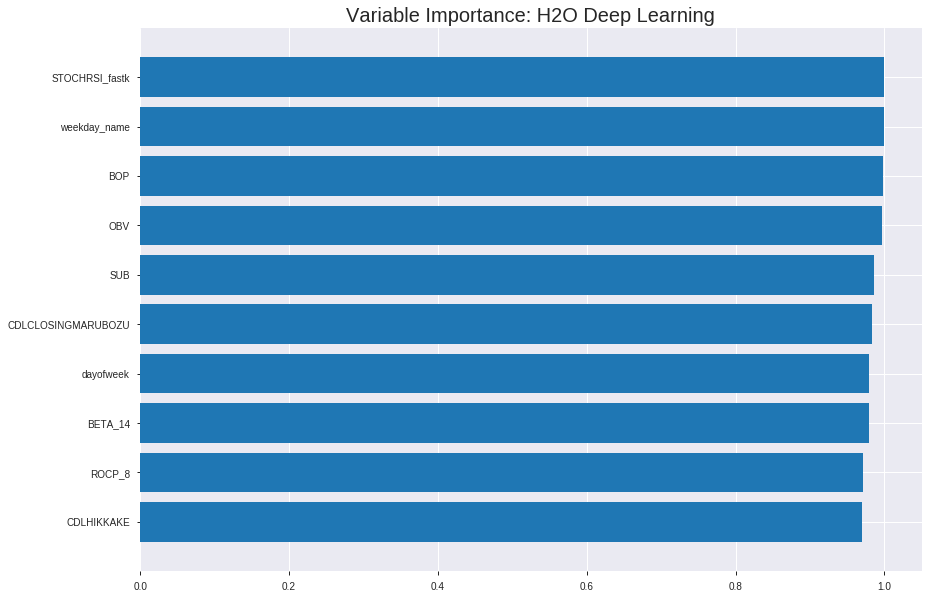

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_120011_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23727795990333345
RMSE: 0.487111855638244
LogLoss: 0.6585914317249445
Mean Per-Class Error: 0.39962220304547835
AUC: 0.6711484755621089
pr_auc: 0.7139579812898112
Gini: 0.34229695112421776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6262162811218877: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      196  552   0.738    (552.0/748.0)
1      56   731   0.0712   (56.0/787.0)
Total  252  1283  0.3961   (608.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.626216     0.70628   221
max f2                       0.204686     0.849036  346
max f0point5                 0.651455     0.619927  204
max accuracy                 0.654635     0.607818  200
max precision                0.999819     1         0
max recall                   0.0686681    1         377
max specificity              0.999819     1         0
max absolute_mcc             0.770852     0.268802  121
max min_per_class_accuracy   0.65545      0.336722  198
max mean_per_class_accuracy  0.659236     0.600378  194

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 64.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.99636            1.95044   1.95044            1                0.998334  1                           0.998334            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.980688           1.95044   1.95044            1                0.988483  1                           0.993567            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.971101           1.95044   1.95044            1                0.976056  1                           0.987606            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.955757           1.82042   1.91899            0.933333         0.962827  0.983871                    0.981611            0.0177891       0.0775095                  82.0415   91.8986
    5        0.0501629                   0.938451           1.56036   1.84912            0.8              0.948157  0.948052                    0.975094            0.0152478       0.0927573                  56.0356   84.9123
    6        0.100326                    0.818016           1.67181   1.76047            0.857143         0.877659  0.902597                    0.926376            0.0838628       0.17662                    67.181    76.0466
    7        0.150489                    0.730619           1.13987   1.5536             0.584416         0.770415  0.796537                    0.874389            0.0571792       0.233799                   13.987    55.3601
    8        0.2                         0.675662           1.2062    1.4676             0.618421         0.700871  0.752443                    0.831434            0.0597205       0.29352                    20.6196   46.7598
    9        0.801303                    0.654864           1.00375   1.11952            0.514626         0.655507  0.573984                    0.699417            0.603558        0.897078                   0.374999  11.9524
    10       0.899674                    0.491253           0.723344  1.0762             0.370861         0.597061  0.551774                    0.688226            0.0711563       0.968234                   -27.6656  7.62048
    11       1                           0.0026096          0.316631  1                  0.162338         0.242423  0.512704                    0.6435              0.0317662       1                          -68.3369  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2620218308373342
RMSE: 0.5118806802735714
LogLoss: 0.7195884984582741
Mean Per-Class Error: 0.4824967879183605
AUC: 0.5073193335720454
pr_auc: 0.6234667609348142
Gini: 0.014638667144090789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24420470476110157: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    195  0.9898   (195.0/197.0)
1      0    241  0        (0.0/241.0)
Total  2    436  0.4452   (195.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.244205     0.711965   53
max f2                       0.244205     0.860714   53
max f0point5                 0.244205     0.607053   53
max accuracy                 0.244205     0.554795   53
max precision                0.953187     1          0
max recall                   0.244205     1          53
max specificity              0.953187     1          0
max absolute_mcc             0.88248      0.086798   3
max min_per_class_accuracy   0.65491      0.0705394  23
max mean_per_class_accuracy  0.65491      0.517503   23

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 65.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.850298           1.45394   1.45394            0.8              0.902945  0.8                         0.902945            0.0165975       0.0165975                  45.3942   45.3942
    2        0.0205479                   0.808527           0.454357  1.00968            0.25             0.813659  0.555556                    0.863262            0.00414938      0.0207469                  -54.5643  0.968188
    3        0.0319635                   0.757959           1.45394   1.16835            0.8              0.782423  0.642857                    0.834391            0.0165975       0.0373444                  45.3942   16.8346
    4        0.0410959                   0.695252           1.36307   1.21162            0.75             0.719944  0.666667                    0.808958            0.0124481       0.0497925                  36.3071   21.1618
    5        0.0502283                   0.656207           1.36307   1.23916            0.75             0.672545  0.681818                    0.784156            0.0124481       0.0622407                  36.3071   23.9155
    6        0.929224                    0.654864           0.977162  0.991324           0.537662         0.654866  0.545455                    0.661855            0.858921        0.921162                   -2.28377  -0.867597
    7        1                           0.22499            1.11391   1                  0.612903         0.501963  0.550228                    0.650538            0.0788382       1                          11.3907   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:13:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:13:21  7.515 sec         104 obs/sec       0.304235  1             467        0.658684         2.53932             -0.736581      0.504458        0.506797           0.85332          0.487296                         0.696691           3.41257               -0.961308        0.517177          0.57122              1.09046            0.447489
    2019-08-28 12:13:48  34.647 sec        165 obs/sec       3.13355   11            4810       0.536392         0.797449            -0.151607      0.548744        0.567924           1.70664          0.479479                         0.587899           0.936272              -0.396592        0.540262          0.581798             1.45394            0.442922
    2019-08-28 12:14:15  1 min  1.226 sec  201 obs/sec       6.94723   24            10664      0.541472         0.807017            -0.173525      0.618214        0.63581            1.82854          0.430619                         0.549273           0.829338              -0.219108        0.5208            0.577175             1.45394            0.440639
    2019-08-28 12:14:41  1 min 28.029 sec  218 obs/sec       11.0065   38            16895      0.487112         0.658591            0.0502751      0.671148        0.713958           1.95044          0.396091                         0.511881           0.719588              -0.058772        0.507319          0.623467             1.45394            0.445205
    2019-08-28 12:15:08  1 min 54.783 sec  230 obs/sec       15.2417   53            23396      0.477789         0.644414            0.0862826      0.680889        0.69769            1.95044          0.393485                         0.51638            0.734663              -0.0774653       0.539535          0.605771             1.81743            0.447489
    2019-08-28 12:15:34  2 min 20.697 sec  236 obs/sec       19.2567   67            29559      0.448904         0.5728              0.19342        0.720525        0.761022           1.95044          0.371987                         0.512397           0.73839               -0.0609093       0.474819          0.537484             1.45394            0.447489
    2019-08-28 12:16:01  2 min 47.769 sec  242 obs/sec       23.6235   82            36262      0.484222         0.657327            0.0615092      0.738386        0.757643           1.95044          0.362215                         0.581109           0.966287              -0.364523        0.518219          0.585349             1.81743            0.449772
    2019-08-28 12:16:28  3 min 14.893 sec  246 obs/sec       27.944    97            42894      0.425263         0.518555            0.276137       0.779096        0.785428           1.95044          0.328339                         0.526864           0.840857              -0.121661        0.519641          0.607997             1.09046            0.449772
    2019-08-28 12:16:55

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastk            1.0                    1.0                  0.0010791493555028697
weekday_name              0.9989694356918335     0.9989694356918335   0.0010780372226939076
BOP                       0.9979928135871887     0.9979928135871887   0.0010769833015791103
OBV                       0.9963366389274597     0.9963366389274597   0.0010751960417624635
SUB                       0.9856512546539307     0.9856512546539307   0.0010636649162103842
---                       ---                    ---                  ---
CDLHARAMICROSS            0.8258720636367798     0.8258720636367798   0.000891239305201456
BBANDS_upperband_12_4_3   0.8252232074737549     0.8252232074737549   0.0008905390924913136
BBANDS_middleband_12_2_2  0.8212231993675232     0.8212231993675232   0.0008862224863214673
BBANDS_middleband_14_6_4  0.8139838576316833     0.8139838576316833   0.0008784101553529708
BBANDS_upperband_14_1_5   0.8088288903236389     0.8088288903236389   0.0008728471757048563


See the whole table with table.as_data_frame()


('accuracy', 0.6136363636363636)

('F1', 0.65)

('auc', 0.5588113395225465)

('logloss', 0.7720073448855683)

('mean_per_class_error', 0.40566976127320953)

('rmse', 0.5340918070378899)

('mse', 0.2852540583449986)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


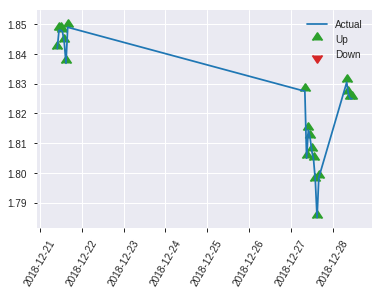


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2852540583449986
RMSE: 0.5340918070378899
LogLoss: 0.7720073448855683
Mean Per-Class Error: 0.40566976127320953
AUC: 0.5588113395225465
pr_auc: 0.5830332696368516
Gini: 0.11762267904509294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5387887600339397: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    112  0.9655   (112.0/116.0)
1      0    104  0        (0.0/104.0)
Total  4    216  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.538789     0.65      110
max f2                       0.538789     0.822785  110
max f0point5                 0.71529      0.555556  54
max accuracy                 0.804164     0.613636  30
max precision                0.965975     1         0
max recall                   0.538789     1         110
max specificity              0.965975     1         0
max absolute_mcc             0.804164     0.270717  30
max min_per_class_accuracy   0.656657     0.413462  82
max mean_per_class_accuracy  0.804164     0.59433   30

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 68.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.939878           2.11538   2.11538            1                0.952527  1                           0.952527            0.0288462       0.0288462                  111.538   111.538
    2        0.0227273                   0.930906           1.05769   1.69231            0.5              0.931586  0.8                         0.944151            0.00961538      0.0384615                  5.76923   69.2308
    3        0.0318182                   0.919534           1.05769   1.51099            0.5              0.927822  0.714286                    0.939486            0.00961538      0.0480769                  5.76923   51.0989
    4        0.0409091                   0.898965           2.11538   1.6453             1                0.912845  0.777778                    0.933565            0.0192308       0.0673077                  111.538   64.5299
    5        0.05                        0.891473           2.11538   1.73077            1                0.893615  0.818182                    0.926302            0.0192308       0.0865385                  111.538   73.0769
    6        0.1                         0.86066            1.53846   1.63462            0.727273         0.875104  0.772727                    0.900703            0.0769231       0.163462                   53.8462   63.4615
    7        0.15                        0.774898           1.53846   1.60256            0.727273         0.817368  0.757576                    0.872925            0.0769231       0.240385                   53.8462   60.2564
    8        0.2                         0.733605           0.961538  1.44231            0.454545         0.752338  0.681818                    0.842778            0.0480769       0.288462                   -3.84615  44.2308
    9        0.3                         0.697417           0.769231  1.21795            0.363636         0.71439   0.575758                    0.799982            0.0769231       0.365385                   -23.0769  21.7949
    10       0.863636                    0.654864           0.887097  1.00202            0.419355         0.657837  0.473684                    0.707213            0.5             0.865385                   -11.2903  0.202429
    11       0.9                         0.63214            0.264423  0.972222           0.125            0.643921  0.459596                    0.704656            0.00961538      0.875                      -73.5577  -2.77778
    12       1                           0.253136           1.25      1                  0.590909         0.543442  0.472727                    0.688535            0.125           1                          25        0

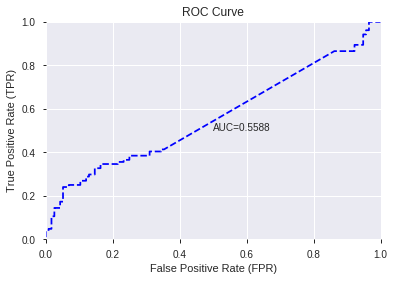

This function is available for GLM models only


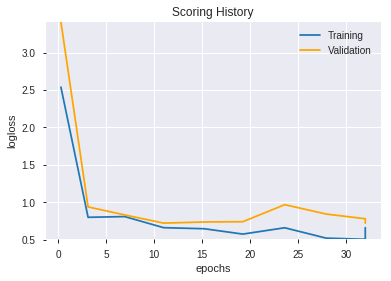

--2019-08-28 12:24:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.6MB/s    in 10s     

2019-08-28 12:24:42 (33.7 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_120011_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_120011_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_122455  0.511688  0.780972              0.495690  0.538102  0.289553
1  DeepLearning_grid_1_AutoML_20190828_122455_model_6  0.505885  0.717970              0.500000  0.511971  0.262115
2  DeepLearning_grid_1_AutoML_20190828_122455_model_8  0.497099  0.699798              0.470325  0.503303  0.253313
3  DeepLearning_grid_1_AutoML_20190828_122455_model_2  0.491835  2.479432              0.463196  0.672314  0.452006
4  DeepLearning_grid_1_AutoML_20190828_122455_model_4  0.491048  1.051337              0.500000  0.598977  0.358773
5  DeepLearning_grid_1_AutoML_20190828_122455_model_1  0.490426  3.031281              0.476127  0.662985  0.439550
6  DeepLearning_grid_1_AutoML_20190828_122455_model_5  0.489970  0.742319              0.495690  0.520605  0.271029
7  DeepLearning_grid_1_AutoML_20190828_122455_model_7  0.487732  0.793620              0.487566  0.540924  0.292599
8  DeepLearning_grid_1_AutoML_20190828_122455_model_3  0.484582  1.469268              0.495690  0.632809  0.400448
9  DeepLearning_grid_1_AutoML_20190828_122455_model_9  0.480230  0.707512              0.495690  0.507086  0.257136

variable  relative_importance  scaled_importance  percentage
0          CDLLONGLEGGEDDOJI             1.000000           1.000000    0.028133
1              CDLHANGINGMAN             0.972047           0.972047    0.027347
2                        BOP             0.937847           0.937847    0.026385
3              days_in_month             0.898625           0.898625    0.025281
4                  MAVP_30_6             0.898150           0.898150    0.025268
5    BBANDS_upperband_14_3_2             0.870795           0.870795    0.024498
6            MACDFIX_hist_14             0.860531           0.860531    0.024210
7    BBANDS_lowerband_20_3_4             0.858479           0.858479    0.024152
8   BBANDS_middleband_20_1_5             0.850544           0.850544    0.023929
9               weekday_name             0.847275           0.847275    0.023837
10                       SUB             0.827775           0.827775    0.023288
11                     MAX_8             0.785759           0.785759    0.022106
12            STOCHRSI_fastk             0.785541           0.785541    0.022100
13             MINMAX_max_14             0.783146           0.783146    0.022033
14                aroonup_20             0.773470           0.773470    0.021760
15   BBANDS_lowerband_14_1_5             0.771528           0.771528    0.021706
16                   BETA_14             0.752667           0.752667    0.021175
17  BBANDS_middleband_14_1_5             0.750425           0.750425    0.021112
18           CDLHOMINGPIGEON             0.748835           0.748835    0.021067
19        CDLCLOSINGMARUBOZU             0.747913           0.747913    0.021041
20            STOCHRSI_fastd             0.737262           0.737262    0.020742
21                AROONOSC_8             0.733059           0.733059    0.020623
22            is_month_start             0.719518           0.719518    0.020242
23                  WCLPRICE             0.719414           0.719414    0.020240
24                 CORREL_24             0.716920           0.716920    0.020169
25   BBANDS_lowerband_24_5_5             0.716058           0.716058    0.020145
26   BBANDS_lowerband_14_4_2             0.692832           0.692832    0.019492
27                    ROCP_8             0.689031           0.689031    0.019385
28                 CORREL_20             0.682676           0.682676    0.019206
29   BBANDS_lowerband_12_4_4             0.678172           0.678172    0.019079
30               CDLBELTHOLD             0.668370           0.668370    0.018804
31   BBANDS_upperband_20_7_5             0.662060           0.662060    0.018626
32            MACDFIX_hist_8             0.652065           0.652065    0.018345
33                       DIV             0.650642           0.650642    0.018305
34                   ADXR_14             0.639701           0.639701    0.017997
35         CDLINVERTEDHAMMER             0.638517           0.638517    0.017964
36               AROONOSC_24             0.637802           0.637802    0.017944
37               CDL3OUTSIDE             0.637756           0.637756    0.017942
38                   CDLDOJI             0.636414           0.636414    0.017904
39                    MFI_12             0.619694           0.619694    0.017434
40                CDLHIKKAKE             0.616974           0.616974    0.017358
41   BBANDS_upperband_20_7_2             0.612847           0.612847    0.017241
42                 dayofweek             0.600621           0.600621    0.016897
43         HT_PHASOR_inphase             0.546911           0.546911    0.015386
44                  CORREL_8             0.535895           0.535895    0.015077
45                 CDLHAMMER             0.535514           0.535514    0.015066
46  BBANDS_middleband_14_7_4             0.531358           0.531358    0.014949
47  BBANDS_middleband_14_3_4             0.492772           0.492772    0.013863
48                       OBV             0.465537  

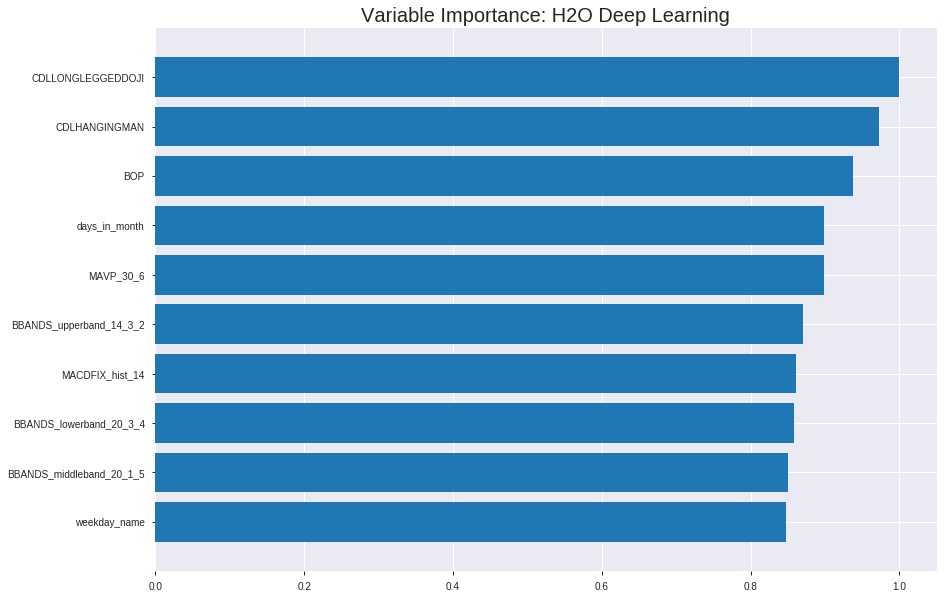

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_122455


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24996631320481316
RMSE: 0.4999663120699365
LogLoss: 0.7039408082519465
Mean Per-Class Error: 0.4017099389137657
AUC: 0.6262247823930311
pr_auc: 0.6074226882502543
Gini: 0.2524495647860623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22190434749525756: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      52   696   0.9305   (696.0/748.0)
1      17   770   0.0216   (17.0/787.0)
Total  69   1466  0.4645   (713.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.221904     0.683533  363
max f2                       0.0373977    0.840273  399
max f0point5                 0.551255     0.613399  220
max accuracy                 0.551255     0.601303  220
max precision                0.999998     1         0
max recall                   0.0373977    1         399
max specificity              0.999998     1         0
max absolute_mcc             0.538487     0.203777  228
max min_per_class_accuracy   0.610204     0.589572  178
max mean_per_class_accuracy  0.567446     0.59829   209

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 58.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.924391           0.85332   0.85332            0.4375           0.943895  0.4375                      0.943895            0.00889454      0.00889454                 -14.668   -14.668
    2        0.0201954                   0.904433           1.04024   0.943764           0.533333         0.91281   0.483871                    0.928854            0.0101652       0.0190597                  4.02372   -5.62364
    3        0.0306189                   0.887597           1.70664   1.20347            0.875            0.89419   0.617021                    0.917053            0.0177891       0.0368488                  70.6639   20.3466
    4        0.0403909                   0.869933           1.43033   1.25835            0.733333         0.876969  0.645161                    0.907356            0.0139771       0.0508259                  43.0326   25.8351
    5        0.0501629                   0.854223           0.910208  1.19053            0.466667         0.86236   0.61039                     0.89859             0.00889454      0.0597205                  -8.97925  19.0531
    6        0.100326                    0.800889           1.44384   1.31718            0.74026          0.824971  0.675325                    0.861781            0.0724269       0.132147                   44.3836   31.7183
    7        0.150489                    0.767033           1.24119   1.29185            0.636364         0.784919  0.662338                    0.83616             0.0622618       0.194409                   24.1192   29.1853
    8        0.2                         0.738601           1.18053   1.26429            0.605263         0.753039  0.648208                    0.815583            0.0584498       0.252859                   18.0532   26.4295
    9        0.300326                    0.693941           1.25386   1.26081            0.642857         0.717743  0.646421                    0.782899            0.125794        0.378653                   25.3857   26.0808
    10       0.4                         0.650156           1.13457   1.22935            0.581699         0.669722  0.630293                    0.754697            0.113088        0.491741                   13.4572   22.9352
    11       0.500326                    0.610191           0.962557  1.17585            0.493506         0.63107   0.602865                    0.729907            0.0965693       0.58831                    -3.74429  17.5854
    12       0.6                         0.564334           1.04534   1.15417            0.535948         0.588614  0.591748                    0.706435            0.104193        0.692503                   4.53364   15.4172
    13       0.699674                    0.514859           0.930604  1.12232            0.477124         0.541465  0.575419                    0.682933            0.0927573       0.78526                    -6.93957  12.2323
    14       0.8                         0.450724           0.772579  1.07846            0.396104         0.485157  0.552932                    0.658131            0.0775095       0.86277                    -22.7421  7.84625
    15       0.899674                    0.337653           0.662896  1.03242            0.339869         0.400297  0.529327                    0.629566            0.0660737       0.928844                   -33.7104  3.24222
    16       1                           0.0367082          0.709253  1                  0.363636         0.227436  0.512704                    0.589222        



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2874985984479826
RMSE: 0.5361889577825923
LogLoss: 0.7856765293412415
Mean Per-Class Error: 0.4786528213661352
AUC: 0.4875939928807633
pr_auc: 0.5382962990105079
Gini: -0.024812014238473346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09531681030436888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    195  0.9898   (195.0/197.0)
1      0    241  0        (0.0/241.0)
Total  2    436  0.4452   (195.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0953168    0.711965   397
max f2                       0.0953168    0.860714   397
max f0point5                 0.0953168    0.607053   397
max accuracy                 0.133204     0.554795   385
max precision                0.663561     0.597938   87
max recall                   0.0953168    1          397
max specificity              0.936005     0.994924   0
max absolute_mcc             0.887673     0.0918526  2
max min_per_class_accuracy   0.528631     0.477178   191
max mean_per_class_accuracy  0.663561     0.521347   87

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.855303           0.726971  0.726971           0.4              0.887367  0.4                         0.887367            0.00829876      0.00829876                 -27.3029   -27.3029
    2        0.0205479                   0.83199            0.908714  0.807746           0.5              0.841046  0.444444                    0.86678             0.00829876      0.0165975                  -9.12863   -19.2254
    3        0.0319635                   0.81478            1.09046   0.908714           0.6              0.820332  0.5                         0.850191            0.0124481       0.0290456                  9.04564    -9.12863
    4        0.0410959                   0.804301           0.908714  0.908714           0.5              0.808957  0.5                         0.841028            0.00829876      0.0373444                  -9.12863   -9.12863
    5        0.0502283                   0.788245           0.454357  0.826103           0.25             0.794005  0.454545                    0.832478            0.00414938      0.0414938                  -54.5643   -17.3897
    6        0.100457                    0.747696           1.07393   0.950019           0.590909         0.772064  0.522727                    0.802271            0.0539419       0.0954357                  7.39344    -4.99811
    7        0.150685                    0.708388           1.15654   1.01886            0.636364         0.729824  0.560606                    0.778122            0.0580913       0.153527                   15.6545    1.88608
    8        0.200913                    0.679376           1.23916   1.07393            0.681818         0.692183  0.590909                    0.756637            0.0622407       0.215768                   23.9155    7.39344
    9        0.30137                     0.619266           0.826103  0.991324           0.454545         0.646264  0.545455                    0.719846            0.0829876       0.298755                   -17.3897   -0.867597
    10       0.399543                    0.578966           0.929847  0.976218           0.511628         0.59678   0.537143                    0.689607            0.0912863       0.390041                   -7.01534   -2.37819
    11       0.5                         0.525593           0.908714  0.962656           0.5              0.55286   0.52968                     0.662133            0.0912863       0.481328                   -9.12863   -3.73444
    12       0.600457                    0.471267           0.867409  0.946721           0.477273         0.496994  0.520913                    0.634505            0.0871369       0.568465                   -13.2591   -5.32793
    13       0.69863                     0.402987           1.09891   0.968107           0.604651         0.439009  0.53268                     0.607033            0.107884        0.676349                   9.89096    -3.18933
    14       0.799087                    0.340985           1.19785   0.996989           0.659091         0.377067  0.548571                    0.578123            0.120332        0.79668                    19.785     -0.301126
    15       0.899543                    0.241578           1.03263   1.00097            0.568182         0.295819  0.550761                    0.546597            0.103734        0.900415                   3.26292    0.096889
    16       1                           0.086952           0.991324  1                  0.545455         0.16731   0.550228     


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:24:55  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:24:55  0.106 sec   52931 obs/sec     1         1             1535       0.560428         0.916042            -0.257129      0.520409        0.513933           0.975222         0.485993                         0.535285           0.806805              -0.157803        0.528782          0.562842             1.81743            0.440639
    2019-08-28 12:24:55  0.418 sec   49516 obs/sec     10        10            15350      0.499966         0.703941            -0.000511107   0.626225        0.607423           0.85332          0.464495                         0.536189           0.785677              -0.161718        0.487594          0.538296             0.726971           0.445205

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLLONGLEGGEDDOJI         1.0                    1.0                  0.028133384273493604
CDLHANGINGMAN             0.9720472097396851     0.9720472097396851   0.027346977683583792
BOP                       0.9378467202186584     0.9378467202186584   0.02638480216954716
days_in_month             0.8986253142356873     0.8986253142356873   0.02528137128328153
MAVP_30_6                 0.8981502056121826     0.8981502056121826   0.025268004869804822
---                       ---                    ---                  ---
CDLHAMMER                 0.5355137586593628     0.5355137586593628   0.015065814356106766
BBANDS_middleband_14_7_4  0.5313577651977539     0.5313577651977539   0.014948892195013195
BBANDS_middleband_14_3_4  0.49277204275131226    0.49277204275131226  0.013863345237957085
OBV                       0.46553686261177063    0.46553686261177063  0.01309712744933354
aroondown_24              0.35721760988235474    0.35721760988235474  0.010049740288079211


See the whole table with table.as_data_frame()


('accuracy', 0.5818181818181818)

('F1', 0.6439628482972136)

('auc', 0.5116876657824934)

('logloss', 0.7809722062800039)

('mean_per_class_error', 0.43783156498673736)

('rmse', 0.5381016216739988)

('mse', 0.28955335524818726)

deeplearning prediction progress: |███████████████████████████████████████| 100%


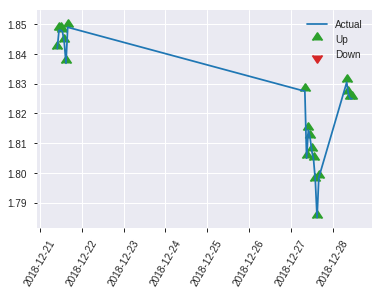


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28955335524818726
RMSE: 0.5381016216739988
LogLoss: 0.7809722062800039
Mean Per-Class Error: 0.43783156498673736
AUC: 0.5116876657824934
pr_auc: 0.5412872704880047
Gini: 0.023375331564986723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12758282630638476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    115  0.9914   (115.0/116.0)
1      0    104  0        (0.0/104.0)
Total  1    219  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.127583     0.643963  218
max f2                       0.127583     0.818898  218
max f0point5                 0.127583     0.530612  218
max accuracy                 0.792704     0.581818  21
max precision                0.909922     1         0
max recall                   0.127583     1         218
max specificity              0.909922     1         0
max absolute_mcc             0.807347     0.21344   14
max min_per_class_accuracy   0.628508     0.491379  110
max mean_per_class_accuracy  0.770421     0.562168  29

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 61.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.856918           2.11538   2.11538            1                0.875869  1                           0.875869            0.0288462       0.0288462                  111.538   111.538
    2        0.0227273                   0.843472           1.05769   1.69231            0.5              0.848829  0.8                         0.865053            0.00961538      0.0384615                  5.76923   69.2308
    3        0.0318182                   0.841451           2.11538   1.81319            1                0.843212  0.857143                    0.858813            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.822913           1.05769   1.6453             0.5              0.833183  0.777778                    0.853117            0.00961538      0.0673077                  5.76923   64.5299
    5        0.05                        0.819661           2.11538   1.73077            1                0.82131   0.818182                    0.847334            0.0192308       0.0865385                  111.538   73.0769
    6        0.1                         0.790102           1.53846   1.63462            0.727273         0.80424   0.772727                    0.825787            0.0769231       0.163462                   53.8462   63.4615
    7        0.15                        0.760043           0.769231  1.34615            0.363636         0.776404  0.636364                    0.809326            0.0384615       0.201923                   -23.0769  34.6154
    8        0.2                         0.739757           0.961538  1.25               0.454545         0.751466  0.590909                    0.794861            0.0480769       0.25                       -3.84615  25
    9        0.3                         0.711493           0.769231  1.08974            0.363636         0.727757  0.515152                    0.772493            0.0769231       0.326923                   -23.0769  8.97436
    10       0.4                         0.664903           0.576923  0.961538           0.272727         0.691128  0.454545                    0.752152            0.0576923       0.384615                   -42.3077  -3.84615
    11       0.5                         0.630327           1.05769   0.980769           0.5              0.649453  0.463636                    0.731612            0.105769        0.490385                   5.76923   -1.92308
    12       0.6                         0.595205           1.25      1.02564            0.590909         0.611997  0.484848                    0.711676            0.125           0.615385                   25        2.5641
    13       0.7                         0.542502           0.384615  0.934066           0.181818         0.572335  0.441558                    0.69177             0.0384615       0.653846                   -61.5385  -6.59341
    14       0.8                         0.490018           1.34615   0.985577           0.636364         0.520089  0.465909                    0.67031             0.134615        0.788462                   34.6154   -1.44231
    15       0.9                         0.431923           0.961538  0.982906           0.454545         0.457744  0.464646                    0.646692            0.0961538       0.884615                   -3.84615  -1.7094
    16       1                           0.127343           1.15385   1                  0.545455         0.310907  0.472727                    0.613113           

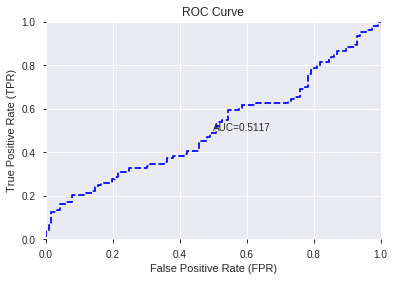

This function is available for GLM models only


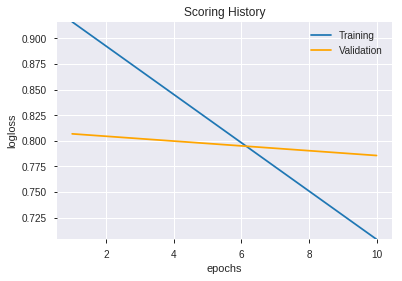

--2019-08-28 12:32:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_122455',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_122455',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_be75'

['CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'BOP',
 'days_in_month',
 'MAVP_30_6',
 'BBANDS_upperband_14_3_2',
 'MACDFIX_hist_14',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_middleband_20_1_5',
 'weekday_name',
 'SUB',
 'MAX_8',
 'STOCHRSI_fastk',
 'MINMAX_max_14',
 'aroonup_20',
 'BBANDS_lowerband_14_1_5',
 'BETA_14',
 'BBANDS_middleband_14_1_5',
 'CDLHOMINGPIGEON',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'is_month_start',
 'WCLPRICE',
 'CORREL_24',
 'BBANDS_lowerband_24_5_5',
 'BBANDS_lowerband_14_4_2',
 'ROCP_8',
 'CORREL_20',
 'BBANDS_lowerband_12_4_4',
 'CDLBELTHOLD',
 'BBANDS_upperband_20_7_5',
 'MACDFIX_hist_8',
 'DIV',
 'ADXR_14',
 'CDLINVERTEDHAMMER',
 'AROONOSC_24',
 'CDL3OUTSIDE',
 'CDLDOJI',
 'MFI_12',
 'CDLHIKKAKE',
 'BBANDS_upperband_20_7_2',
 'dayofweek',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'CDLHAMMER',
 'BBANDS_middleband_14_7_4',
 'BBANDS_middleband_14_3_4',
 'OBV',
 'aroondown_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_123220_model_1  0.496436  0.69604              0.478448  0.501443  0.251445

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk             0.016953           1.000000    0.066872
1                CDLBELTHOLD             0.015739           0.928381    0.062082
2                        BOP             0.014753           0.870245    0.058195
3                CDL3OUTSIDE             0.013977           0.824462    0.055133
4              days_in_month             0.013250           0.781581    0.052266
5         CDLCLOSINGMARUBOZU             0.013093           0.772306    0.051645
6          HT_PHASOR_inphase             0.012584           0.742302    0.049639
7                  CDLHAMMER             0.012092           0.713285    0.047699
8              CDLHANGINGMAN             0.011299           0.666489    0.044569
9                        OBV             0.010934           0.644955    0.043129
10                  CORREL_8             0.009505           0.560670    0.037493
11           CDLHOMINGPIGEON             0.008742           0.515645    0.034482
12              weekday_name             0.008323           0.490968    0.032832
13                    ROCP_8             0.007426           0.438007    0.029290
14            STOCHRSI_fastd             0.006904           0.407230    0.027232
15   BBANDS_lowerband_24_5_5             0.005357           0.316005    0.021132
16         CDLINVERTEDHAMMER             0.005248           0.309584    0.020702
17         CDLLONGLEGGEDDOJI             0.005097           0.300675    0.020107
18                   CDLDOJI             0.005097           0.300635    0.020104
19            is_month_start             0.004711           0.277911    0.018584
20                 CORREL_20             0.004272           0.251969    0.016850
21                       DIV             0.003455           0.203786    0.013628
22                   ADXR_14             0.002825           0.166626    0.011143
23                CDLHIKKAKE             0.002785           0.164264    0.010985
24                    MFI_12             0.002564           0.151214    0.010112
25            MACDFIX_hist_8             0.002500           0.147457    0.009861
26                aroonup_20             0.002497           0.147314    0.009851
27   BBANDS_lowerband_20_3_4             0.002370           0.139822    0.009350
28                       SUB             0.002337           0.137871    0.009220
29                     MAX_8             0.002249           0.132636    0.008870
30              aroondown_24             0.002247           0.132557    0.008864
31                 CORREL_24             0.002070           0.122129    0.008167
32           MACDFIX_hist_14             0.002041           0.120396    0.008051
33                 dayofweek             0.001888           0.111337    0.007445
34             MINMAX_max_14             0.001831           0.108009    0.007223
35               AROONOSC_24             0.001628           0.096051    0.006423
36  BBANDS_middleband_20_1_5             0.001515           0.089339    0.005974
37                  WCLPRICE             0.001448           0.085424    0.005712
38                AROONOSC_8             0.001263           0.074511    0.004983
39  BBANDS_middleband_14_1_5             0.001228           0.072433    0.004844
40   BBANDS_lowerband_14_1_5             0.001136           0.067019    0.004482
41  BBANDS_middleband_14_7_4             0.001106           0.065250    0.004363
42   BBANDS_upperband_20_7_5             0.001025           0.060484    0.004045
43   BBANDS_lowerband_12_4_4             0.001014           0.059823    0.004000
44                 MAVP_30_6             0.000991           0.058466    0.003910
45  BBANDS_middleband_14_3_4             0.000632           0.037301    0.002494
46   BBANDS_upperband_14_3_2             0.000586           0.034549    0.002310
47   BBANDS_lowerband_14_4_2             0.000478           0.028201    0.001886
48   BBANDS_upperband_20_7_2             0.000225  

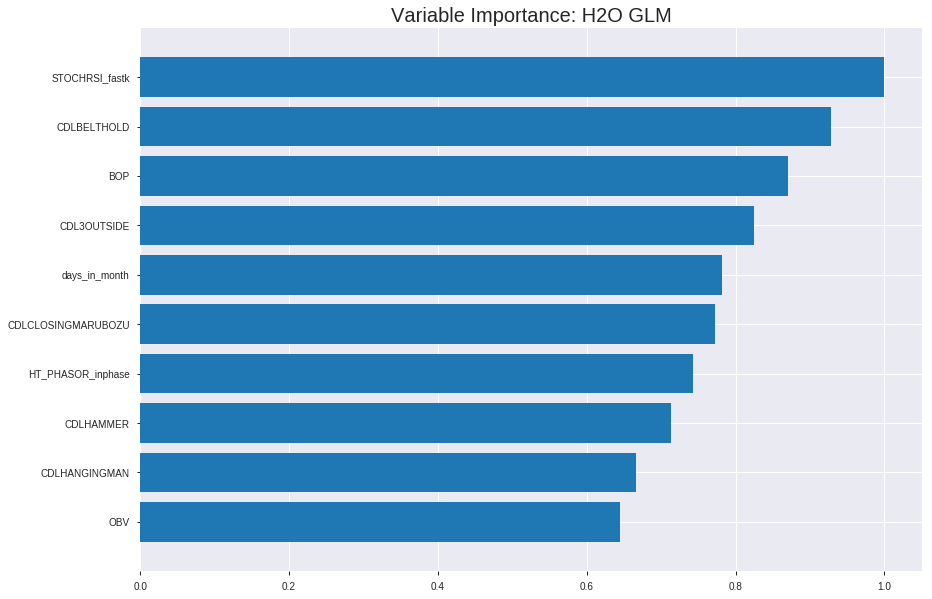

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123220_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24815424543847417
RMSE: 0.4981508259939696
LogLoss: 0.689450302181329
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.970858206576
Residual deviance: 2116.61242769668
AIC: 2218.61242769668
AUC: 0.565286337475963
pr_auc: 0.5580572884674424
Gini: 0.13057267495192604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4791920835059164: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      23   725   0.9693   (725.0/748.0)
1      6    781   0.0076   (6.0/787.0)
Total  29   1506  0.4762   (731.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479192     0.681204  377
max f2                       0.46247      0.840992  396
max f0point5                 0.501187     0.579015  277
max accuracy                 0.510249     0.554397  217
max precision                0.605015     1         0
max recall                   0.46247      1         396
max specificity              0.605015     1         0
max absolute_mcc             0.516235     0.107721  175
max min_per_class_accuracy   0.512448     0.546791  201
max mean_per_class_accuracy  0.510249     0.552983  217

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.55292            1.09713   1.09713            0.5625           0.563992  0.5625                      0.563992            0.0114358       0.0114358                  9.71252   9.71252
    2        0.0201954                   0.546031           1.3003    1.19543            0.666667         0.548831  0.612903                    0.556656            0.0127065       0.0241423                  30.0296   19.5434
    3        0.0306189                   0.543345           0.85332   1.07897            0.4375           0.544464  0.553191                    0.552506            0.00889454      0.0330368                  -14.668   7.89694
    4        0.0403909                   0.541461           1.17027   1.10106            0.6              0.542168  0.564516                    0.550005            0.0114358       0.0444727                  17.0267   10.1058
    5        0.0501629                   0.540021           1.17027   1.11454            0.6              0.540894  0.571429                    0.54823             0.0114358       0.0559085                  17.0267   11.454
    6        0.100326                    0.533631           1.19053   1.15254            0.61039          0.537001  0.590909                    0.542616            0.0597205       0.115629                   19.0531   15.2536
    7        0.150489                    0.529936           0.987888  1.09765            0.506494         0.531687  0.562771                    0.538973            0.0495553       0.165184                   -1.21124  9.76529
    8        0.2                         0.527013           1.1292    1.10546            0.578947         0.528468  0.566775                    0.536372            0.0559085       0.221093                   12.9205   10.5464
    9        0.300326                    0.521376           1.13987   1.11696            0.584416         0.524201  0.572668                    0.532306            0.114358        0.335451                   13.987    11.6958
    10       0.4                         0.516515           1.14732   1.12452            0.588235         0.518909  0.576547                    0.528968            0.114358        0.449809                   14.732    12.4524
    11       0.500326                    0.512437           0.987888  1.09713            0.506494         0.514225  0.5625                      0.526012            0.0991105       0.54892                    -1.21124  9.71252
    12       0.6                         0.508507           0.968848  1.07582            0.496732         0.510519  0.551574                    0.523438            0.0965693       0.645489                   -3.11516  7.58153
    13       0.699674                    0.504122           0.930604  1.05513            0.477124         0.506314  0.540968                    0.520999            0.0927573       0.738247                   -6.93957  5.51289
    14       0.8                         0.49849            0.987888  1.0467             0.506494         0.501432  0.536645                    0.518545            0.0991105       0.837357                   -1.21124  4.66963
    15       0.899674                    0.491125           0.854116  1.02536            0.437908         0.4951    0.525706                    0.515947            0.0851334       0.92249                    -14.5884  2.53605
    16       1                           0.46086            0.772579  1                  0.396104         0.483614  0.512704                    0.512704          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24873505399831322
RMSE: 0.4987334498490283
LogLoss: 0.6906141571926007
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 605.243449119525
Residual deviance: 604.9780017007182
AIC: 706.9780017007182
AUC: 0.5146386671440908
pr_auc: 0.5692427720690895
Gini: 0.029277334288181578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4745197726165046: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.47452      0.710914   398
max f2                       0.47452      0.8601     398
max f0point5                 0.47452      0.605832   398
max accuracy                 0.486738     0.552511   378
max precision                0.541261     0.666667   17
max recall                   0.47452      1          398
max specificity              0.557805     0.994924   0
max absolute_mcc             0.527855     0.0927251  79
max min_per_class_accuracy   0.513247     0.502538   202
max mean_per_class_accuracy  0.527855     0.536354   79

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.54885            0.726971  0.726971           0.4              0.552269  0.4                         0.552269            0.00829876      0.00829876                 -27.3029   -27.3029
    2        0.0205479                   0.545215           0.908714  0.807746           0.5              0.547579  0.444444                    0.550184            0.00829876      0.0165975                  -9.12863   -19.2254
    3        0.0319635                   0.541927           1.45394   1.03853            0.8              0.543669  0.571429                    0.547858            0.0165975       0.033195                   45.3942    3.85299
    4        0.0410959                   0.540973           1.81743   1.21162            1                0.541462  0.666667                    0.546436            0.0165975       0.0497925                  81.7427    21.1618
    5        0.0502283                   0.538142           0.454357  1.07393            0.25             0.539632  0.590909                    0.545199            0.00414938      0.0539419                  -54.5643   7.39344
    6        0.100457                    0.533367           1.23916   1.15654            0.681818         0.535584  0.636364                    0.540392            0.0622407       0.116183                   23.9155    15.6545
    7        0.150685                    0.529798           1.15654   1.15654            0.636364         0.531613  0.636364                    0.537465            0.0580913       0.174274                   15.6545    15.6545
    8        0.200913                    0.527014           0.991324  1.11524            0.545455         0.528126  0.613636                    0.53513             0.0497925       0.224066                   -0.867597  11.524
    9        0.30137                     0.520714           0.950019  1.06017            0.522727         0.523703  0.583333                    0.531321            0.0954357       0.319502                   -4.99811   6.0166
    10       0.399543                    0.516653           0.929847  1.02814            0.511628         0.51856   0.565714                    0.528186            0.0912863       0.410788                   -7.01534   2.81446
    11       0.5                         0.513348           0.908714  1.00415            0.5              0.515027  0.552511                    0.525542            0.0912863       0.502075                   -9.12863   0.414938
    12       0.600457                    0.508827           1.11524   1.02273            0.613636         0.510886  0.562738                    0.52309             0.112033        0.614108                   11.524     2.27348
    13       0.69863                     0.505264           0.887581  1.00374            0.488372         0.506922  0.552288                    0.520818            0.0871369       0.701245                   -11.2419   0.374258
    14       0.799087                    0.500531           0.826103  0.981411           0.454545         0.503058  0.54                        0.518585            0.0829876       0.784232                   -17.3897   -1.85892
    15       0.899543                    0.493619           1.15654   1.00097            0.636364         0.497495  0.550761                    0.51623             0.116183        0.900415                   15.6545    0.096889
    16       1                           0.473546           0.991324  1                  0.545455         0.484946  0.550228                


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:32:21  0.000 sec   2            3         51            1.38219           1.38153
    2019-08-28 12:32:21  0.047 sec   4            1.9       51            1.38072           1.38135
    2019-08-28 12:32:21  0.080 sec   6            1.2       51            1.3789            1.38123
    2019-08-28 12:32:21  0.106 sec   8            0.72      51            1.37687           1.38131
    2019-08-28 12:32:21  0.124 sec   10           0.44      51            1.37483           1.38176
    2019-08-28 12:32:21  0.154 sec   12           0.28      51            1.37298           1.38266
    2019-08-28 12:32:21  0.180 sec   14           0.17      51            1.37143           1.38394
    2019-08-28 12:32:21  0.207 sec   16           0.11      51            1.37018           1.38546

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.652037617554859)

('auc', 0.4964356763925729)

('logloss', 0.6960401558559972)

('mean_per_class_error', 0.4761273209549072)

('rmse', 0.5014429841393268)

('mse', 0.25144506634255315)

glm prediction progress: |████████████████████████████████████████████████| 100%


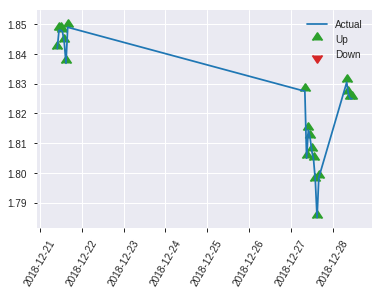


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25144506634255315
RMSE: 0.5014429841393268
LogLoss: 0.6960401558559972
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.73672384847293
Residual deviance: 306.25766857663876
AIC: 408.25766857663876
AUC: 0.4964356763925729
pr_auc: 0.47824282511009397
Gini: -0.007128647214854178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4938025843840895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    111  0.9569   (111.0/116.0)
1      0    104  0        (0.0/104.0)
Total  5    215  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493803     0.652038  214
max f2                       0.493803     0.824089  214
max f0point5                 0.493803     0.539419  214
max accuracy                 0.542835     0.545455  17
max precision                0.572312     1         0
max recall                   0.493803     1         214
max specificity              0.572312     1         0
max absolute_mcc             0.493803     0.144395  214
max min_per_class_accuracy   0.520488     0.480769  109
max mean_per_class_accuracy  0.498004     0.523873  205

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.56011            1.41026   1.41026            0.666667         0.566749  0.666667                    0.566749            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.552687           1.05769   1.26923            0.5              0.554524  0.6                         0.561859            0.00961538      0.0288462                  5.76923   26.9231
    3        0.0318182                   0.548274           1.05769   1.20879            0.5              0.549569  0.571429                    0.558348            0.00961538      0.0384615                  5.76923   20.8791
    4        0.0409091                   0.545213           2.11538   1.41026            1                0.548012  0.666667                    0.556051            0.0192308       0.0576923                  111.538   41.0256
    5        0.05                        0.544236           1.05769   1.34615            0.5              0.5444    0.636364                    0.553933            0.00961538      0.0673077                  5.76923   34.6154
    6        0.1                         0.541334           0.769231  1.05769            0.363636         0.543047  0.5                         0.54849             0.0384615       0.105769                   -23.0769  5.76923
    7        0.15                        0.534512           0.769231  0.961538           0.363636         0.537664  0.454545                    0.544881            0.0384615       0.144231                   -23.0769  -3.84615
    8        0.2                         0.532447           1.34615   1.05769            0.636364         0.533742  0.5                         0.542096            0.0673077       0.211538                   34.6154   5.76923
    9        0.3                         0.528273           0.865385  0.99359            0.409091         0.530326  0.469697                    0.538173            0.0865385       0.298077                   -13.4615  -0.641026
    10       0.4                         0.523806           0.865385  0.961538           0.409091         0.526388  0.454545                    0.535227            0.0865385       0.384615                   -13.4615  -3.84615
    11       0.5                         0.52046            0.961538  0.961538           0.454545         0.522253  0.454545                    0.532632            0.0961538       0.480769                   -3.84615  -3.84615
    12       0.6                         0.515815           0.865385  0.945513           0.409091         0.517823  0.44697                     0.530164            0.0865385       0.567308                   -13.4615  -5.44872
    13       0.7                         0.511392           1.34615   1.00275            0.636364         0.513532  0.474026                    0.527788            0.134615        0.701923                   34.6154   0.274725
    14       0.8                         0.507606           1.05769   1.00962            0.5              0.509693  0.477273                    0.525526            0.105769        0.807692                   5.76923   0.961538
    15       0.9                         0.503286           1.05769   1.01496            0.5              0.505673  0.479798                    0.52332             0.105769        0.913462                   5.76923   1.49573
    16       1                           0.480532           0.865385  1                  0.409091         0.494679  0.472727                    0.520456 

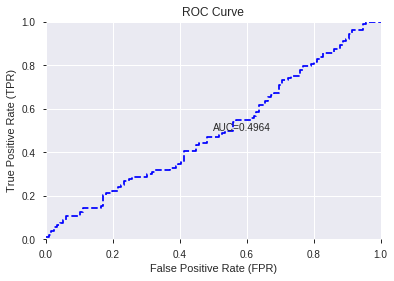

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


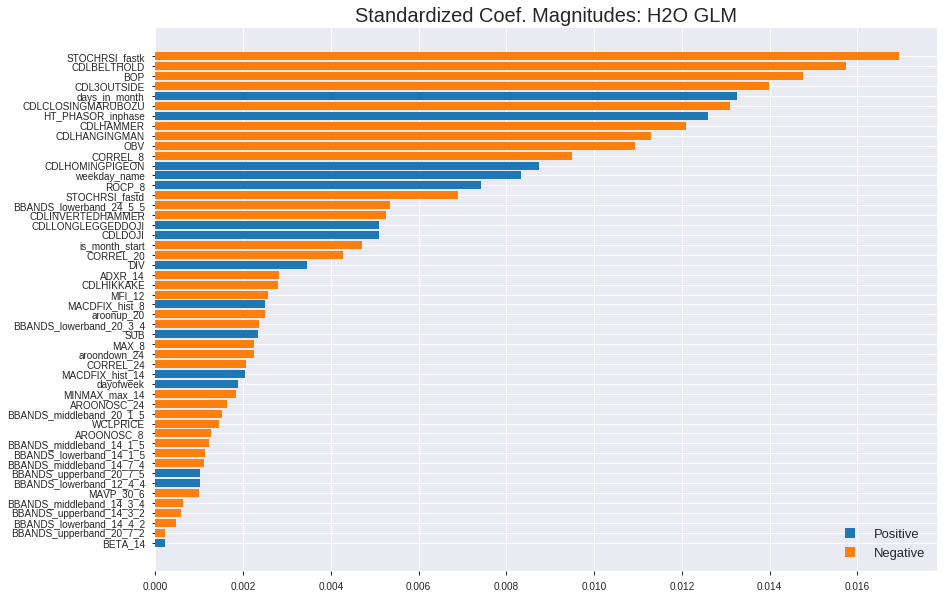

'log_likelihood'
--2019-08-28 12:32:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123220_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123220_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['STOCHRSI_fastk',
 'CDLBELTHOLD',
 'BOP',
 'CDL3OUTSIDE',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'HT_PHASOR_inphase',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'OBV',
 'CORREL_8',
 'CDLHOMINGPIGEON',
 'weekday_name',
 'ROCP_8',
 'STOCHRSI_fastd',
 'BBANDS_lowerband_24_5_5',
 'CDLINVERTEDHAMMER',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'is_month_start',
 'CORREL_20',
 'DIV',
 'ADXR_14',
 'CDLHIKKAKE',
 'MFI_12',
 'MACDFIX_hist_8',
 'aroonup_20',
 'BBANDS_lowerband_20_3_4',
 'SUB',
 'MAX_8',
 'aroondown_24',
 'CORREL_24',
 'MACDFIX_hist_14',
 'dayofweek',
 'MINMAX_max_14',
 'AROONOSC_24',
 'BBANDS_middleband_20_1_5',
 'WCLPRICE',
 'AROONOSC_8',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_20_7_5',
 'BBANDS_lowerband_12_4_4',
 'MAVP_30_6',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_14_3_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_20_7_2',
 'BETA_14']

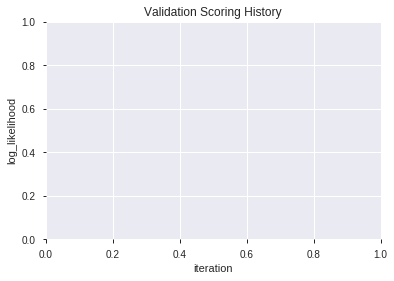

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123237_model_1  0.562003  0.693458              0.495690  0.500104  0.250104
1               XGBoost_1_AutoML_20190828_123237  0.543186  0.720753              0.495690  0.512928  0.263095
2               XGBoost_3_AutoML_20190828_123237  0.542938  0.705556              0.452255  0.505951  0.255986
3  XGBoost_grid_1_AutoML_20190828_123237_model_5  0.531499  0.725890              0.495690  0.515009  0.265234
4  XGBoost_grid_1_AutoML_20190828_123237_model_2  0.531167  0.703092              0.495690  0.504813  0.254836
5  XGBoost_grid_1_AutoML_20190828_123237_model_7  0.529261  0.720450              0.500000  0.512725  0.262887
6  XGBoost_grid_1_AutoML_20190828_123237_model_4  0.525779  0.704998              0.495690  0.505792  0.255826
7  XGBoost_grid_1_AutoML_20190828_123237_model_6  0.513677  0.708352              0.491877  0.507341  0.257395
8               XGBoost_2_AutoML_20190828_123237  0.506300  0.717029              0.500000  0.511118  0.261242
9  XGBoost_grid_1_AutoML_20190828_123237_model_3  0.470822  0.715781              0.495690  0.510902  0.261021

variable  relative_importance  scaled_importance  percentage
0          HT_PHASOR_inphase           257.134613           1.000000    0.073209
1                        OBV           241.106323           0.937666    0.068645
2                  CORREL_20           194.044373           0.754641    0.055246
3                  CORREL_24           190.334732           0.740214    0.054190
4                AROONOSC_24           178.315140           0.693470    0.050768
5                   CORREL_8           169.133926           0.657764    0.048154
6                    BETA_14           157.115402           0.611024    0.044732
7                        SUB           156.275345           0.607757    0.044493
8                        BOP           147.664780           0.574270    0.042042
9             STOCHRSI_fastd           141.994263           0.552218    0.040427
10            STOCHRSI_fastk           138.914566           0.540241    0.039550
11                       DIV           117.982491           0.458836    0.033591
12                   ADXR_14           112.635269           0.438040    0.032068
13                    MFI_12           104.298943           0.405620    0.029695
14           MACDFIX_hist_14            98.400337           0.382680    0.028016
15            MACDFIX_hist_8            96.059654           0.373577    0.027349
16  BBANDS_middleband_20_1_5            86.958336           0.338182    0.024758
17   BBANDS_lowerband_20_3_4            85.819031           0.333751    0.024433
18   BBANDS_upperband_20_7_5            73.082230           0.284218    0.020807
19                aroonup_20            71.128128           0.276618    0.020251
20        CDLCLOSINGMARUBOZU            69.684502           0.271004    0.019840
21   BBANDS_upperband_20_7_2            68.756401           0.267395    0.019576
22                    ROCP_8            66.302170           0.257850    0.018877
23   BBANDS_lowerband_24_5_5            60.820827           0.236533    0.017316
24                 MAVP_30_6            50.894680           0.197930    0.014490
25   BBANDS_lowerband_12_4_4            49.513767           0.192560    0.014097
26   BBANDS_lowerband_14_1_5            42.306091           0.164529    0.012045
27  BBANDS_middleband_14_7_4            39.009819           0.151710    0.011106
28              aroondown_24            32.222027           0.125312    0.009174
29   BBANDS_upperband_14_3_2            30.188808           0.117405    0.008595
30                AROONOSC_8            28.803211           0.112016    0.008201
31  BBANDS_middleband_14_1_5            26.184608           0.101832    0.007455
32  BBANDS_middleband_14_3_4            22.825169           0.088767    0.006499
33             MINMAX_max_14            22.125528           0.086046    0.006299
34                     MAX_8            20.524107           0.079819    0.005843
35   BBANDS_lowerband_14_4_2            19.337006           0.075202    0.005505
36                 dayofweek            18.943235           0.073670    0.005393
37              weekday_name            18.067972           0.070267    0.005144
38                  WCLPRICE             5.929749           0.023061    0.001688
39             days_in_month             1.513885           0.005888    0.000431

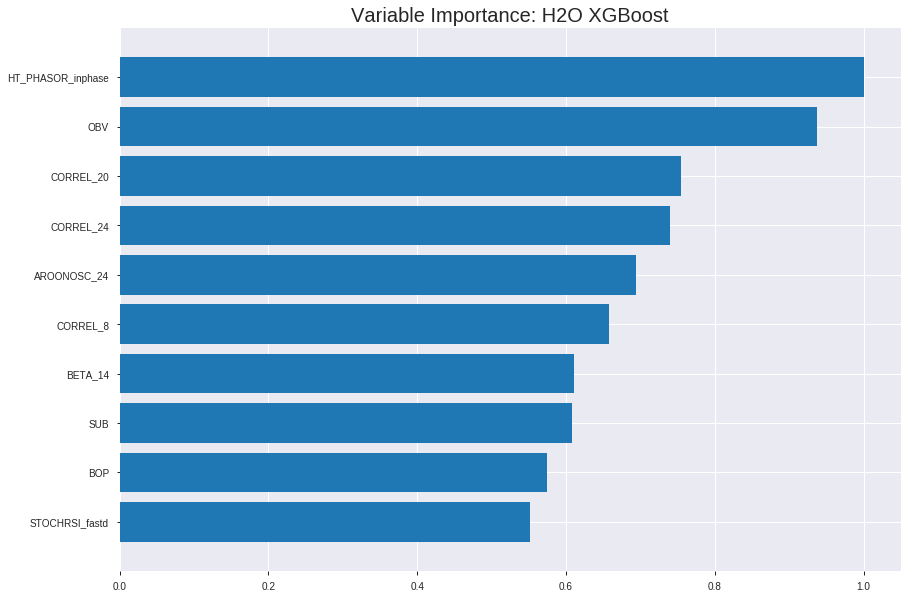

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123237_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19540516970662553
RMSE: 0.44204656961300526
LogLoss: 0.5814840282340988
Mean Per-Class Error: 0.16989991098668877
AUC: 0.9113094469623358
pr_auc: 0.9200024459064075
Gini: 0.8226188939246717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5140468733651298: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      603  145  0.1939   (145.0/748.0)
1      120  667  0.1525   (120.0/787.0)
Total  723  812  0.1726   (265.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514047     0.834271  197
max f2                       0.467432     0.888391  253
max f0point5                 0.546058     0.857866  158
max accuracy                 0.526201     0.829316  183
max precision                0.75696      1         0
max recall                   0.339599     1         361
max specificity              0.75696      1         0
max absolute_mcc             0.526201     0.660655  183
max min_per_class_accuracy   0.519204     0.824866  192
max mean_per_class_accuracy  0.526201     0.8301    183

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.697123           1.95044    1.95044            1                0.711517  1                           0.711517            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.678666           1.95044    1.95044            1                0.687252  1                           0.699776            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.665981           1.95044    1.95044            1                0.671838  1                           0.690265            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.658304           1.95044    1.95044            1                0.663106  1                           0.683694            0.0190597       0.0787802                  95.0445   95.0445
    5        0.0501629                   0.650221           1.95044    1.95044            1                0.653864  1                           0.677883            0.0190597       0.0978399                  95.0445   95.0445
    6        0.100326                    0.623637           1.95044    1.95044            1                0.637065  1                           0.657474            0.0978399       0.19568                    95.0445   95.0445
    7        0.150489                    0.604933           1.89978    1.93356            0.974026         0.614447  0.991342                    0.643132            0.0952986       0.290978                   89.9784   93.3558
    8        0.2                         0.592219           1.79646    1.89962            0.921053         0.598909  0.973941                    0.632184            0.0889454       0.379924                   79.6462   89.9619
    9        0.300326                    0.567576           1.79846    1.86583            0.922078         0.579535  0.956616                    0.614596            0.180432        0.560356                   79.8462   86.5827
    10       0.4                         0.541949           1.45327    1.76302            0.745098         0.554186  0.903909                    0.599543            0.144854        0.70521                    45.3273   76.3024
    11       0.500326                    0.521041           1.11454    1.63299            0.571429         0.531753  0.83724                     0.58595             0.111817        0.817027                   11.454    63.299
    12       0.6                         0.496089           0.82862    1.49936            0.424837         0.50751   0.76873                     0.572919            0.0825921       0.899619                   -17.138   49.9365
    13       0.699674                    0.469831           0.522668   1.36023            0.267974         0.482841  0.697393                    0.560087            0.0520966       0.951715                   -47.7332  36.0226
    14       0.8                         0.43532            0.316631   1.22935            0.162338         0.454509  0.630293                    0.546846            0.0317662       0.983482                   -68.3369  22.9352
    15       0.899674                    0.376969           0.114732   1.10586            0.0588235        0.407811  0.56698                     0.531443            0.0114358       0.994917                   -88.5268  10.5864
    16       1                           0.23001            0.0506609  1                  0.025974         0.335425  0.512704                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25457362049516447
RMSE: 0.5045528916725822
LogLoss: 0.7027735674238937
Mean Per-Class Error: 0.47328179960823136
AUC: 0.507329864987257
pr_auc: 0.5665983427703553
Gini: 0.014659729974513924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30733662843704224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    195  0.9898   (195.0/197.0)
1      0    241  0        (0.0/241.0)
Total  2    436  0.4452   (195.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.307337     0.711965   397
max f2                       0.307337     0.860714   397
max f0point5                 0.307337     0.607053   397
max accuracy                 0.307337     0.554795   397
max precision                0.71256      1          0
max recall                   0.307337     1          397
max specificity              0.71256      1          0
max absolute_mcc             0.46411      0.0849575  324
max min_per_class_accuracy   0.530287     0.497462   194
max mean_per_class_accuracy  0.517899     0.526718   224

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.689043           1.09046   1.09046            0.6              0.697747  0.6                         0.697747            0.0124481       0.0124481                  9.04564   9.04564
    2        0.0205479                   0.671042           1.36307   1.21162            0.75             0.682792  0.666667                    0.6911              0.0124481       0.0248963                  36.3071   21.1618
    3        0.0319635                   0.659305           1.45394   1.29816            0.8              0.665049  0.714286                    0.681796            0.0165975       0.0414938                  45.3942   29.8162
    4        0.0410959                   0.652075           0.454357  1.11065            0.25             0.655951  0.611111                    0.676053            0.00414938      0.0456432                  -54.5643  11.065
    5        0.0502283                   0.649255           1.81743   1.23916            1                0.650427  0.681818                    0.671394            0.0165975       0.0622407                  81.7427   23.9155
    6        0.100457                    0.617926           1.07393   1.15654            0.590909         0.631646  0.636364                    0.65152             0.0539419       0.116183                   7.39344   15.6545
    7        0.150685                    0.598036           0.908714  1.07393            0.5              0.607161  0.590909                    0.636734            0.0456432       0.161826                   -9.12863  7.39344
    8        0.200913                    0.586568           1.15654   1.09459            0.636364         0.59153   0.602273                    0.625433            0.0580913       0.219917                   15.6545   9.45869
    9        0.30137                     0.562309           0.867409  1.01886            0.477273         0.572815  0.560606                    0.607893            0.0871369       0.307054                   -13.2591  1.88608
    10       0.399543                    0.547703           1.01438   1.01776            0.55814          0.555139  0.56                        0.594931            0.0995851       0.406639                   1.43781   1.77593
    11       0.5                         0.529763           0.908714  0.995851           0.5              0.538384  0.547945                    0.58357             0.0912863       0.497925                   -9.12863  -0.414938
    12       0.600457                    0.514175           1.15654   1.02273            0.636364         0.521141  0.562738                    0.573125            0.116183        0.614108                   15.6545   2.27348
    13       0.69863                     0.497561           0.887581  1.00374            0.488372         0.506842  0.552288                    0.563811            0.0871369       0.701245                   -11.2419  0.374258
    14       0.799087                    0.469558           0.702188  0.965833           0.386364         0.48555   0.531429                    0.553973            0.0705394       0.771784                   -29.7812  -3.41672
    15       0.899543                    0.419917           1.15654   0.987131           0.636364         0.452639  0.543147                    0.542656            0.116183        0.887967                   15.6545   -1.28694
    16       1                           0.289633           1.11524   1                  0.613636         0.362022  0.550228                    0.52451      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:32:41  0.049 sec   0                  0.5              0.693147            0.5             0                  1                0.487296                         0.5                0.693147              0.5               0                    1                  0.449772
    2019-08-28 12:32:41  0.196 sec   5                  0.490451         0.674195            0.768131        0.772072           1.70664          0.332248                         0.499888           0.692923              0.510173          0.56983              1.13589            0.445205
    2019-08-28 12:32:42  0.275 sec   10                 0.48344          0.660413            0.790985        0.796549           1.95044          0.308143                         0.498922           0.690996              0.53488           0.585318             1.81743            0.445205
    2019-08-28 12:32:42  0.364 sec   15                 0.476435         0.646766            0.826751        0.841636           1.95044          0.251466                         0.499631           0.692431              0.526086          0.584158             1.81743            0.442922
    2019-08-28 12:32:42  0.478 sec   20                 0.470538         0.635372            0.844465        0.857948           1.95044          0.240391                         0.500371           0.69398               0.524117          0.57474              1.45394            0.447489
    2019-08-28 12:32:42  0.561 sec   25                 0.465972         0.626633            0.861181        0.87133            1.95044          0.218241                         0.500964           0.695175              0.516513          0.575856             1.45394            0.445205
    2019-08-28 12:32:42  0.652 sec   30                 0.460755         0.616679            0.874935        0.885915           1.95044          0.20456                          0.50199            0.697288              0.512743          0.576322             1.81743            0.445205
    2019-08-28 12:32:42  0.742 sec   35                 0.455544         0.60679             0.889473        0.901434           1.95044          0.196743                         0.502868           0.699134              0.508794          0.569376             1.45394            0.445205
    2019-08-28 12:32:42  0.841 sec   40                 0.449875         0.596133            0.900296        0.911418           1.95044          0.181759                         0.503487           0.700421              0.505455          0.568515             1.45394            0.445205
    2019-08-28 12:32:42  0.937 sec   45                 0.444756         0.586566            0.910336        0.919812           1.95044          0.171336                         0.503451           0.700444              0.512501          0.570211             1.09046            0.445205
    2019-08-28 12:32:42  1.042 sec   50                 0.442047         0.581484            0.911309        0.920002           1.95044          0.172638                         0.504553           0.702774              0.50733           0.566598             1.09046            0.445205

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_inphase        257.1346130371094      1.0                   0.0732086800257463
OBV                      241.1063232421875      0.9376657634473788    0.06864527284731628
CORREL_20                194.04437255859375     0.7546411985016949    0.05524628603535628
CORREL_24                190.33473205566406     0.7402143562375835    0.05419011595626104
AROONOSC_24              178.3151397705078      0.6934699987075391    0.050768023242834935
---                      ---                    ---                   ---
BBANDS_lowerband_14_4_2  19.337005615234375     0.07520187728457887   0.005505430171462174
dayofweek                18.943235397338867     0.07367049956283016   0.005393320029832116
weekday_name             18.06797218322754      0.07026658904384837   0.005144124233811706
WCLPRICE                 5.929749011993408      0.023060874387757488  0.001688256174167266
days_in_month            1.513885259628296      0.005887520321543851  0.00043101759136498276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6439628482972136)

('auc', 0.5620026525198939)

('logloss', 0.6934577480671541)

('mean_per_class_error', 0.4389920424403183)

('rmse', 0.5001041729563855)

('mse', 0.25010418380839033)

xgboost prediction progress: |████████████████████████████████████████████| 100%


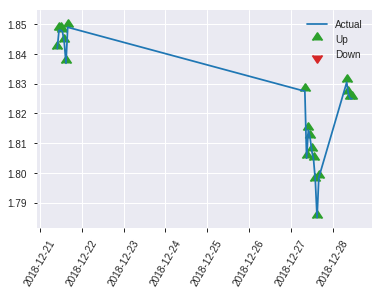


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25010418380839033
RMSE: 0.5001041729563855
LogLoss: 0.6934577480671541
Mean Per-Class Error: 0.4389920424403183
AUC: 0.5620026525198939
pr_auc: 0.53072197850774
Gini: 0.1240053050397878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34090283513069153: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    115  0.9914   (115.0/116.0)
1      0    104  0        (0.0/104.0)
Total  1    219  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340903     0.643963  218
max f2                       0.340903     0.818898  218
max f0point5                 0.490892     0.542582  155
max accuracy                 0.581064     0.572727  37
max precision                0.717023     1         0
max recall                   0.340903     1         218
max specificity              0.717023     1         0
max absolute_mcc             0.581064     0.145387  37
max min_per_class_accuracy   0.526992     0.538462  108
max mean_per_class_accuracy  0.522005     0.561008  116

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.707963           1.41026   1.41026            0.666667         0.714188  0.666667                    0.714188            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.689151           1.05769   1.26923            0.5              0.694228  0.6                         0.706204            0.00961538      0.0288462                  5.76923   26.9231
    3        0.0318182                   0.669356           1.05769   1.20879            0.5              0.679182  0.571429                    0.698483            0.00961538      0.0384615                  5.76923   20.8791
    4        0.0409091                   0.656754           1.05769   1.17521            0.5              0.664818  0.555556                    0.691002            0.00961538      0.0480769                  5.76923   17.5214
    5        0.05                        0.641793           1.05769   1.15385            0.5              0.652313  0.545455                    0.683968            0.00961538      0.0576923                  5.76923   15.3846
    6        0.1                         0.608408           1.53846   1.34615            0.727273         0.622715  0.636364                    0.653341            0.0769231       0.134615                   53.8462   34.6154
    7        0.15                        0.58682            1.15385   1.28205            0.545455         0.596841  0.606061                    0.634508            0.0576923       0.192308                   15.3846   28.2051
    8        0.2                         0.57375            0.961538  1.20192            0.454545         0.580002  0.568182                    0.620881            0.0480769       0.240385                   -3.84615  20.1923
    9        0.3                         0.560147           1.05769   1.15385            0.5              0.566963  0.545455                    0.602909            0.105769        0.346154                   5.76923   15.3846
    10       0.4                         0.541399           1.05769   1.12981            0.5              0.553539  0.534091                    0.590566            0.105769        0.451923                   5.76923   12.9808
    11       0.5                         0.525755           0.865385  1.07692            0.409091         0.533085  0.509091                    0.57907             0.0865385       0.538462                   -13.4615  7.69231
    12       0.6                         0.509729           1.05769   1.07372            0.5              0.518766  0.507576                    0.569019            0.105769        0.644231                   5.76923   7.37179
    13       0.7                         0.492629           0.961538  1.05769            0.454545         0.502673  0.5                         0.559541            0.0961538       0.740385                   -3.84615  5.76923
    14       0.8                         0.46861            0.480769  0.985577           0.227273         0.483067  0.465909                    0.549982            0.0480769       0.788462                   -51.9231  -1.44231
    15       0.9                         0.427381           1.05769   0.99359            0.5              0.452119  0.469697                    0.539108            0.105769        0.894231                   5.76923   -0.641026
    16       1                           0.306439           1.05769   1                  0.5              0.380793  0.472727                    0.523277      

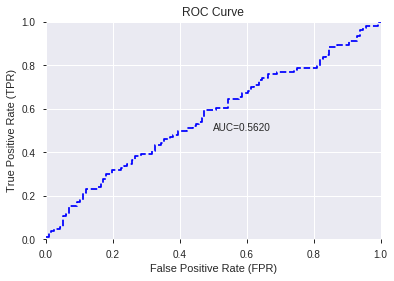

This function is available for GLM models only


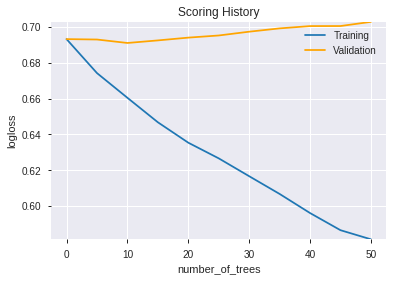

--2019-08-28 12:32:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123237_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123237_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_inphase',
 'OBV',
 'CORREL_20',
 'CORREL_24',
 'AROONOSC_24',
 'CORREL_8',
 'BETA_14',
 'SUB',
 'BOP',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'DIV',
 'ADXR_14',
 'MFI_12',
 'MACDFIX_hist_14',
 'MACDFIX_hist_8',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_upperband_20_7_5',
 'aroonup_20',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_upperband_20_7_2',
 'ROCP_8',
 'BBANDS_lowerband_24_5_5',
 'MAVP_30_6',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_7_4',
 'aroondown_24',
 'BBANDS_upperband_14_3_2',
 'AROONOSC_8',
 'BBANDS_middleband_14_1_5',
 'BBANDS_middleband_14_3_4',
 'MINMAX_max_14',
 'MAX_8',
 'BBANDS_lowerband_14_4_2',
 'dayofweek',
 'weekday_name',
 'WCLPRICE',
 'days_in_month']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_123308_model_1  0.507875  0.695286              0.491379  0.50107  0.251071

variable  relative_importance  scaled_importance    percentage
0                         hour         7.215365e-03       1.000000e+00  1.138211e-02
1               STOCHRSI_fastk         6.908468e-03       9.574663e-01  1.089798e-02
2                  CDLBELTHOLD         6.838350e-03       9.477484e-01  1.078737e-02
3                          BOP         6.725159e-03       9.320609e-01  1.060882e-02
4               CDLMATCHINGLOW         6.514695e-03       9.028921e-01  1.027681e-02
...                        ...                  ...                ...           ...
1031                   MA_20_7         3.952442e-07       5.477813e-05  6.234905e-07
1032  BBANDS_middleband_30_6_4         1.485446e-07       2.058727e-05  2.343264e-07
1033                    SUM_24         9.798885e-08       1.358058e-05  1.545756e-07
1034                   MA_30_7         1.785077e-10       2.473994e-08  2.815926e-10
1035                       ADD         0.000000e+00       0.000000e+00  0.000000e+00

[1036 rows x 4 columns]

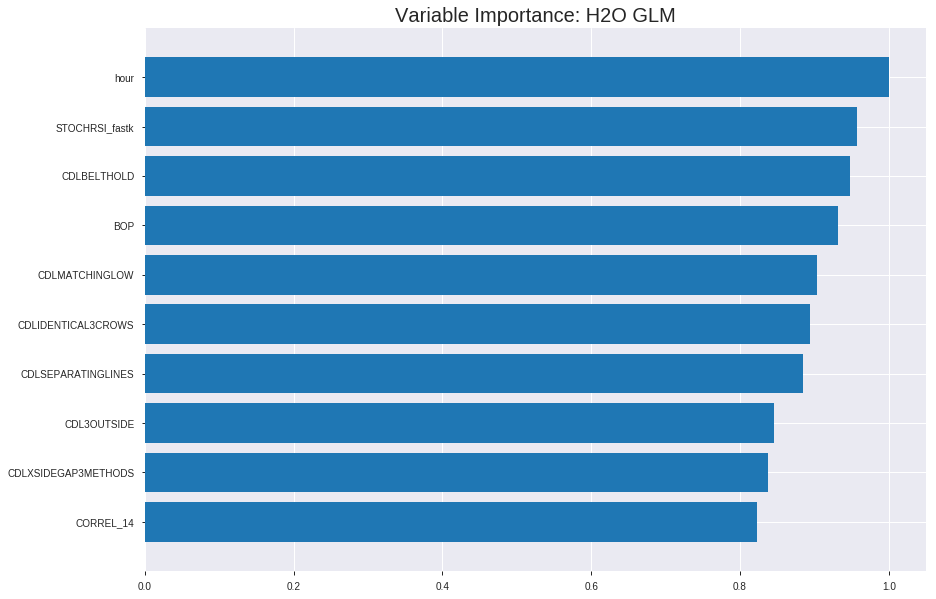

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123308_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24733684915235288
RMSE: 0.49732971875040094
LogLoss: 0.6878052415671114
Null degrees of freedom: 1534
Residual degrees of freedom: 499
Null deviance: 2126.970858206576
Residual deviance: 2111.562091611032
AIC: 4183.562091611032
AUC: 0.5846017163940775
pr_auc: 0.5927521397802473
Gini: 0.16920343278815508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4801019100945452: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   717   0.9586   (717.0/748.0)
1      11   776   0.014    (11.0/787.0)
Total  42   1493  0.4743   (728.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480102     0.680702  370
max f2                       0.463413     0.841171  394
max f0point5                 0.496498     0.583319  306
max accuracy                 0.509558     0.566124  223
max precision                0.591946     1         0
max recall                   0.463413     1         394
max specificity              0.591946     1         0
max absolute_mcc             0.516752     0.136645  177
max min_per_class_accuracy   0.512047     0.559085  208
max mean_per_class_accuracy  0.515586     0.567461  184

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.565392           1.70664   1.70664            0.875            0.576036  0.875                       0.576036            0.0177891       0.0177891                  70.6639   70.6639
    2        0.0201954                   0.557985           1.17027   1.4471             0.6              0.561475  0.741935                    0.56899             0.0114358       0.0292249                  17.0267   44.7104
    3        0.0306189                   0.551771           1.46283   1.45246            0.75             0.553965  0.744681                    0.563875            0.0152478       0.0444727                  46.2834   45.2459
    4        0.0403909                   0.545965           0.780178  1.28981            0.4              0.548307  0.66129                     0.560109            0.00762389      0.0520966                  -21.9822  28.981
    5        0.0501629                   0.54231            1.3003    1.29185            0.666667         0.544261  0.662338                    0.557022            0.0127065       0.064803                   30.0296   29.1853
    6        0.100326                    0.534432           1.1652    1.22853            0.597403         0.537988  0.62987                     0.547505            0.0584498       0.123253                   16.5201   22.8527
    7        0.150489                    0.529472           1.19053   1.21586            0.61039          0.531554  0.623377                    0.542188            0.0597205       0.182973                   19.0531   21.5862
    8        0.2                         0.526097           1.18053   1.20712            0.605263         0.527913  0.618893                    0.538654            0.0584498       0.241423                   18.0532   20.7116
    9        0.300326                    0.520995           1.1652    1.19311            0.597403         0.523268  0.611714                    0.533514            0.1169          0.358323                   16.5201   19.3114
    10       0.4                         0.516507           1.07083   1.16264            0.54902          0.518888  0.596091                    0.52987             0.106734        0.465057                   7.08324   16.2643
    11       0.500326                    0.51202            0.937227  1.11744            0.480519         0.514185  0.572917                    0.526724            0.094028        0.559085                   -6.27733  11.7442
    12       0.6                         0.507855           0.9561    1.09064            0.490196         0.509859  0.559175                    0.523923            0.0952986       0.654384                   -4.38996  9.06396
    13       0.699674                    0.503045           0.943352  1.06966            0.48366          0.505587  0.548417                    0.521311            0.094028        0.748412                   -5.66476  6.96573
    14       0.8                         0.498281           0.924561  1.05146            0.474026         0.500559  0.539088                    0.518708            0.0927573       0.841169                   -7.54385  5.14612
    15       0.899674                    0.491373           0.803124  1.02395            0.411765         0.49484   0.524982                    0.516064            0.0800508       0.92122                    -19.6876  2.39482
    16       1                           0.432057           0.785244  1                  0.402597         0.48257   0.512704                    0.512704          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24967519066032634
RMSE: 0.499675085090628
LogLoss: 0.692500790580265
Null degrees of freedom: 437
Residual degrees of freedom: -598
Null deviance: 605.243449119525
Residual deviance: 606.6306925483121
AIC: 2678.6306925483123
AUC: 0.487204330517935
pr_auc: 0.5446164851055341
Gini: -0.025591338964130017
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4694395342848814: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46944      0.710914  398
max f2                       0.46944      0.8601    398
max f0point5                 0.46944      0.605832  398
max accuracy                 0.46944      0.552511  398
max precision                0.552215     0.666667  2
max recall                   0.46944      1         398
max specificity              0.590864     0.994924  0
max absolute_mcc             0.485986     0.110397  382
max min_per_class_accuracy   0.510609     0.477157  202
max mean_per_class_accuracy  0.532378     0.519336  34

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.543775           0.726971  0.726971           0.4              0.558177  0.4                         0.558177            0.00829876      0.00829876                 -27.3029   -27.3029
    2        0.0205479                   0.541373           0         0.403873           0                0.542487  0.222222                    0.551204            0               0.00829876                 -100       -59.6127
    3        0.0319635                   0.540487           1.81743   0.908714           1                0.540898  0.5                         0.547523            0.0207469       0.0290456                  81.7427    -9.12863
    4        0.0410959                   0.53846            1.36307   1.00968            0.75             0.539493  0.555556                    0.545738            0.0124481       0.0414938                  36.3071    0.968188
    5        0.0502283                   0.536183           0.454357  0.908714           0.25             0.537626  0.5                         0.544264            0.00414938      0.0456432                  -54.5643   -9.12863
    6        0.100457                    0.53069            1.32177   1.11524            0.727273         0.533314  0.613636                    0.538789            0.06639         0.112033                   32.1765    11.524
    7        0.150685                    0.526888           0.826103  1.01886            0.454545         0.529098  0.560606                    0.535558            0.0414938       0.153527                   -17.3897   1.88608
    8        0.200913                    0.524371           0.991324  1.01198            0.545455         0.525677  0.556818                    0.533088            0.0497925       0.20332                    -0.867597  1.19766
    9        0.30137                     0.518545           1.07393   1.03263            0.590909         0.521132  0.568182                    0.529103            0.107884        0.311203                   7.39344    3.26292
    10       0.399543                    0.514253           0.676252  0.945062           0.372093         0.516549  0.52                        0.526018            0.06639         0.377593                   -32.3748   -5.49378
    11       0.5                         0.510378           0.991324  0.954357           0.545455         0.512141  0.525114                    0.52323             0.0995851       0.477178                   -0.867597  -4.56432
    12       0.600457                    0.50729            1.11524   0.981273           0.613636         0.508974  0.539924                    0.520845            0.112033        0.589212                   11.524     -1.87274
    13       0.69863                     0.503355           0.972112  0.979985           0.534884         0.50545   0.539216                    0.518682            0.0954357       0.684647                   -2.78877   -2.00146
    14       0.799087                    0.499144           1.07393   0.991796           0.590909         0.501239  0.545714                    0.516489            0.107884        0.792531                   7.39344    -0.820391
    15       0.899543                    0.493728           1.03263   0.996356           0.568182         0.496433  0.548223                    0.514249            0.103734        0.896266                   3.26292    -0.364387
    16       1                           0.467169           1.03263   1                  0.568182         0.485736  0.550228        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:33:11  0.000 sec   2            3         1036          1.37561           1.385
    2019-08-28 12:33:13  1.965 sec   4            2.2       1037          1.3731            1.38591
    2019-08-28 12:33:15  3.945 sec   6            1.6       1037          1.37016           1.38725
    2019-08-28 12:33:17  5.872 sec   8            1.2       1037          1.36678           1.38917
    2019-08-28 12:33:19  7.845 sec   10           0.84      1037          1.36298           1.39183

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6459627329192547)

('auc', 0.5078746684350133)

('logloss', 0.6952860461865351)

('mean_per_class_error', 0.45905172413793105)

('rmse', 0.5010700421430833)

('mse', 0.25107118713327126)

glm prediction progress: |████████████████████████████████████████████████| 100%


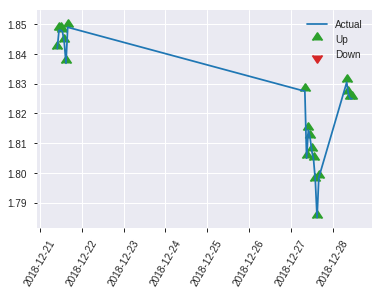


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25107118713327126
RMSE: 0.5010700421430833
LogLoss: 0.6952860461865351
Null degrees of freedom: 219
Residual degrees of freedom: -816
Null deviance: 305.73672384847293
Residual deviance: 305.92586032207544
AIC: 2377.9258603220756
AUC: 0.5078746684350133
pr_auc: 0.5088613582311797
Gini: 0.015749336870026553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4891560473876949: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    114  0.9828   (114.0/116.0)
1      0    104  0        (0.0/104.0)
Total  2    218  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489156     0.645963  217
max f2                       0.489156     0.820189  217
max f0point5                 0.506283     0.545455  193
max accuracy                 0.547236     0.563636  11
max precision                0.574488     1         0
max recall                   0.489156     1         217
max specificity              0.574488     1         0
max absolute_mcc             0.547236     0.173488  11
max min_per_class_accuracy   0.522591     0.509615  107
max mean_per_class_accuracy  0.541931     0.540948  17

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.562494           1.41026   1.41026            0.666667         0.567363  0.666667                    0.567363            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.556831           2.11538   1.69231            1                0.55728   0.8                         0.56333             0.0192308       0.0384615                  111.538   69.2308
    3        0.0318182                   0.551973           2.11538   1.81319            1                0.555432  0.857143                    0.561073            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.548981           2.11538   1.88034            1                0.54968   0.888889                    0.558541            0.0192308       0.0769231                  111.538   88.0342
    5        0.05                        0.547247           1.05769   1.73077            0.5              0.548169  0.818182                    0.556655            0.00961538      0.0865385                  5.76923   73.0769
    6        0.1                         0.541151           0.769231  1.25               0.363636         0.543239  0.590909                    0.549947            0.0384615       0.125                      -23.0769  25
    7        0.15                        0.537731           0.576923  1.02564            0.272727         0.539673  0.484848                    0.546523            0.0288462       0.153846                   -42.3077  2.5641
    8        0.2                         0.535347           0.961538  1.00962            0.454545         0.536947  0.477273                    0.544129            0.0480769       0.201923                   -3.84615  0.961538
    9        0.3                         0.529359           0.961538  0.99359            0.454545         0.532234  0.469697                    0.540164            0.0961538       0.298077                   -3.84615  -0.641026
    10       0.4                         0.525271           0.865385  0.961538           0.409091         0.526775  0.454545                    0.536816            0.0865385       0.384615                   -13.4615  -3.84615
    11       0.5                         0.52235            1.25      1.01923            0.590909         0.523876  0.481818                    0.534228            0.125           0.509615                   25        1.92308
    12       0.6                         0.518991           0.673077  0.961538           0.318182         0.520903  0.454545                    0.532008            0.0673077       0.576923                   -32.6923  -3.84615
    13       0.7                         0.51563            1.05769   0.975275           0.5              0.517137  0.461039                    0.529883            0.105769        0.682692                   5.76923   -2.47253
    14       0.8                         0.511092           1.25      1.00962            0.590909         0.513228  0.477273                    0.527801            0.125           0.807692                   25        0.961538
    15       0.9                         0.505103           1.25      1.03632            0.590909         0.508503  0.489899                    0.525657            0.125           0.932692                   25        3.63248
    16       1                           0.486671           0.673077  1                  0.318182         0.496803  0.472727                    0.522772        

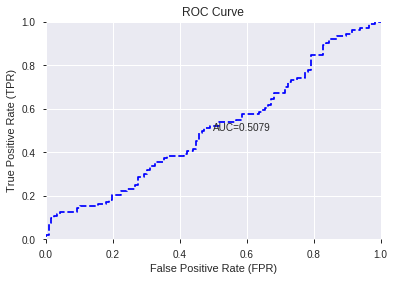

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


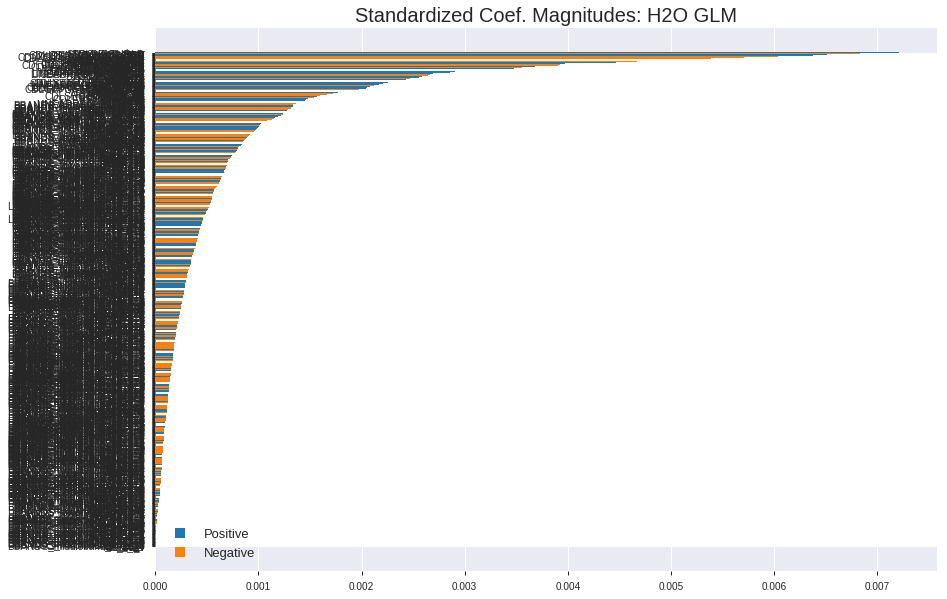

'log_likelihood'
--2019-08-28 12:33:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.82.114
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.82.114|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123308_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123308_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

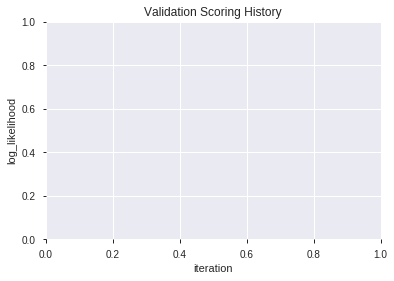

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123353_model_7  0.527934  0.724266              0.491379  0.514463  0.264672
1  XGBoost_grid_1_AutoML_20190828_123353_model_2  0.523707  0.701990              0.491379  0.504269  0.254287
2  XGBoost_grid_1_AutoML_20190828_123353_model_3  0.523044  0.724411              0.487069  0.514708  0.264924
3               XGBoost_2_AutoML_20190828_123353  0.521883  0.713608              0.487069  0.509834  0.259931
4  XGBoost_grid_1_AutoML_20190828_123353_model_5  0.521137  0.747453              0.484251  0.523242  0.273783
5  XGBoost_grid_1_AutoML_20190828_123353_model_6  0.511273  0.718288              0.500000  0.512249  0.262399
6  XGBoost_grid_1_AutoML_20190828_123353_model_4  0.507626  0.702078              0.488064  0.504370  0.254389
7               XGBoost_1_AutoML_20190828_123353  0.496270  0.741596              0.495690  0.522259  0.272754
8               XGBoost_3_AutoML_20190828_123353  0.493534  0.719391              0.500000  0.512577  0.262735
9  XGBoost_grid_1_AutoML_20190828_123353_model_1  0.493369  0.718958              0.479940  0.512113  0.262260

variable  relative_importance  scaled_importance  percentage
0                        BOP           171.949249           1.000000    0.019913
1          HT_PHASOR_inphase           140.728226           0.818429    0.016297
2             STOCHRSI_fastd           130.555466           0.759267    0.015119
3                      ADOSC           128.522110           0.747442    0.014883
4                       hour           127.741478           0.742902    0.014793
..                       ...                  ...                ...         ...
361  BBANDS_upperband_14_5_4             2.506950           0.014580    0.000290
362                  ROCP_12             2.173074           0.012638    0.000252
363                     mama             1.735502           0.010093    0.000201
364   BBANDS_upperband_8_5_2             1.633044           0.009497    0.000189
365               aroonup_14             0.497116           0.002891    0.000058

[366 rows x 4 columns]

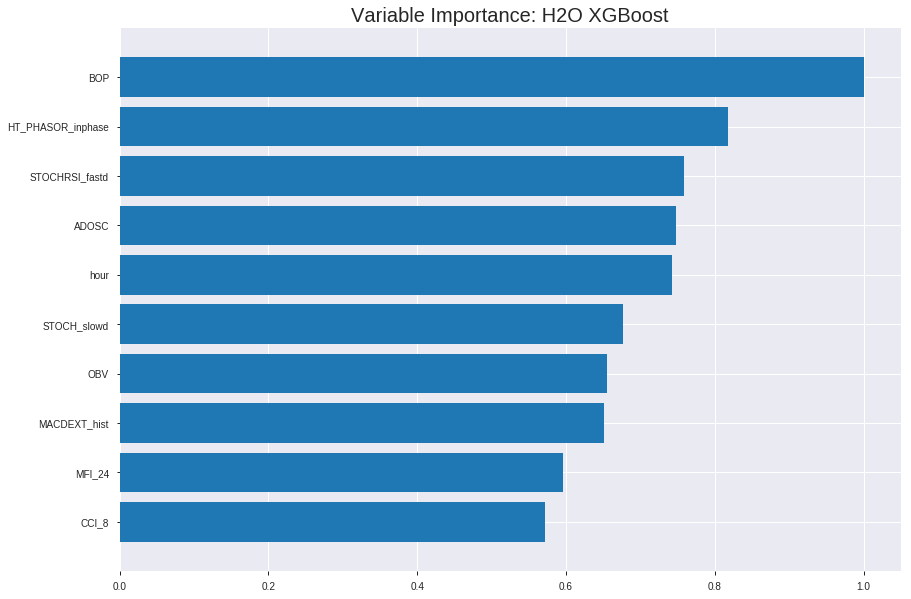

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123353_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1320067568298459
RMSE: 0.3633273411537396
LogLoss: 0.4443101957212584
Mean Per-Class Error: 0.059774816707322875
AUC: 0.9867524750456957
pr_auc: 0.9866778852194864
Gini: 0.9735049500913915
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138948410749435: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      708  40   0.0535   (40.0/748.0)
1      52   735  0.0661   (52.0/787.0)
Total  760  775  0.0599   (92.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513895     0.941101  195
max f2                       0.46001      0.959194  225
max f0point5                 0.545765     0.957447  176
max accuracy                 0.513895     0.940065  195
max precision                0.870634     1         0
max recall                   0.339876     1         304
max specificity              0.870634     1         0
max absolute_mcc             0.513895     0.880208  195
max min_per_class_accuracy   0.510283     0.935829  198
max mean_per_class_accuracy  0.513895     0.940225  195

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.808515           1.95044    1.95044            1                0.835047  1                           0.835047            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.793949           1.95044    1.95044            1                0.800279  1                           0.818224            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.779736           1.95044    1.95044            1                0.786768  1                           0.807515            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.773264           1.95044    1.95044            1                0.776904  1                           0.800109            0.0190597       0.0787802                  95.0445   95.0445
    5        0.0501629                   0.767466           1.95044    1.95044            1                0.770221  1                           0.794287            0.0190597       0.0978399                  95.0445   95.0445
    6        0.100326                    0.736935           1.95044    1.95044            1                0.750548  1                           0.772418            0.0978399       0.19568                    95.0445   95.0445
    7        0.150489                    0.707915           1.95044    1.95044            1                0.722527  1                           0.755787            0.0978399       0.29352                    95.0445   95.0445
    8        0.2                         0.685333           1.95044    1.95044            1                0.697974  1                           0.741475            0.0965693       0.390089                   95.0445   95.0445
    9        0.300326                    0.63922            1.93778    1.94621            0.993506         0.663573  0.997831                    0.715452            0.194409        0.584498                   93.778    94.6214
    10       0.4                         0.585728           1.89945    1.93456            0.973856         0.613642  0.991857                    0.690082            0.189327        0.773825                   89.9453   93.4562
    11       0.500326                    0.515803           1.54516    1.85648            0.792208         0.55164   0.951823                    0.662322            0.155019        0.928844                   54.5158   85.6478
    12       0.6                         0.434465           0.57366    1.64337            0.294118         0.472958  0.842562                    0.630864            0.0571792       0.986023                   -42.634   64.3371
    13       0.699674                    0.378754           0.114732   1.4256             0.0588235        0.407955  0.730912                    0.599109            0.0114358       0.997459                   -88.5268  42.5604
    14       0.8                         0.332065           0.0253305  1.25               0.012987         0.353088  0.640879                    0.568256            0.0025413       1                          -97.467   25
    15       0.899674                    0.281389           0          1.11151            0                0.308105  0.569877                    0.539434            0               1                          -100      11.1513
    16       1                           0.141872           0          1                  0                0.245388  0.512704                    0.50



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26019415088034736
RMSE: 0.5100922964330548
LogLoss: 0.7154291544803425
Mean Per-Class Error: 0.47973755713292754
AUC: 0.48979505865998274
pr_auc: 0.5531047245590609
Gini: -0.02040988268003452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2853747010231018: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    197  1        (197.0/197.0)
1      0    241  0        (0.0/241.0)
Total  0    438  0.4498   (197.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.285375     0.709867   399
max f2                       0.285375     0.859486   399
max f0point5                 0.285375     0.604616   399
max accuracy                 0.310744     0.550228   397
max precision                0.722554     0.6875     31
max recall                   0.285375     1          399
max specificity              0.841259     0.994924   0
max absolute_mcc             0.722554     0.0774686  31
max min_per_class_accuracy   0.572489     0.502075   195
max mean_per_class_accuracy  0.722554     0.520262   31

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 56.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.787711           1.09046   1.09046            0.6              0.807338  0.6                         0.807338            0.0124481       0.0124481                  9.04564    9.04564
    2        0.0205479                   0.772641           0.908714  1.00968            0.5              0.78139   0.555556                    0.795806            0.00829876      0.0207469                  -9.12863   0.968188
    3        0.0319635                   0.756472           1.45394   1.16835            0.8              0.762933  0.642857                    0.784065            0.0165975       0.0373444                  45.3942    16.8346
    4        0.0410959                   0.748633           0.454357  1.00968            0.25             0.752681  0.555556                    0.777091            0.00414938      0.0414938                  -54.5643   0.968188
    5        0.0502283                   0.735625           1.81743   1.15654            1                0.74445   0.636364                    0.771156            0.0165975       0.0580913                  81.7427    15.6545
    6        0.100457                    0.700302           0.908714  1.03263            0.5              0.719522  0.568182                    0.745339            0.0456432       0.103734                   -9.12863   3.26292
    7        0.150685                    0.670514           1.07393   1.0464             0.590909         0.683702  0.575758                    0.724793            0.0539419       0.157676                   7.39344    4.63976
    8        0.200913                    0.653339           0.826103  0.991324           0.454545         0.661282  0.545455                    0.708916            0.0414938       0.19917                    -17.3897   -0.867597
    9        0.30137                     0.625963           0.908714  0.963787           0.5              0.638687  0.530303                    0.685506            0.0912863       0.290456                   -9.12863   -3.62127
    10       0.399543                    0.594003           1.14118   1.00737            0.627907         0.609123  0.554286                    0.666738            0.112033        0.40249                    14.1175    0.737404
    11       0.5                         0.570375           0.991324  1.00415            0.545455         0.583287  0.552511                    0.649971            0.0995851       0.502075                   -0.867597  0.414938
    12       0.600457                    0.540299           0.743493  0.960541           0.409091         0.554074  0.528517                    0.633928            0.0746888       0.576763                   -25.6507   -3.94585
    13       0.69863                     0.511096           1.09891   0.979985           0.604651         0.526857  0.539216                    0.618882            0.107884        0.684647                   9.89096    -2.00146
    14       0.799087                    0.470617           1.19785   1.00737            0.659091         0.492328  0.554286                    0.602972            0.120332        0.804979                   19.785     0.737404
    15       0.899543                    0.419135           0.826103  0.987131           0.454545         0.448489  0.543147                    0.58572             0.0829876       0.887967                   -17.3897   -1.28694
    16       1                           0.285375           1.11524   1                  0.613636         0.381503  0.550228         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:34:39  29.826 sec  0                  0.5              0.693147            0.5             0                  1                0.487296                         0.5                0.693147              0.5               0                    1                  0.449772
    2019-08-28 12:34:41  30.990 sec  5                  0.483588         0.66076             0.812605        0.814424           1.95044          0.280782                         0.499922           0.69298               0.483782          0.553294             1.45394            0.440639
    2019-08-28 12:34:41  31.315 sec  10                 0.465112         0.625263            0.891545        0.897108           1.95044          0.18241                          0.500297           0.693718              0.486878          0.562824             1.45394            0.449772
    2019-08-28 12:34:41  31.692 sec  15                 0.450782         0.598305            0.916338        0.919694           1.95044          0.166775                         0.502473           0.698165              0.480822          0.552304             1.09046            0.447489
    2019-08-28 12:34:42  31.982 sec  20                 0.435178         0.569563            0.940249        0.942863           1.95044          0.141368                         0.503612           0.700582              0.482002          0.55085              1.45394            0.449772
    2019-08-28 12:34:42  32.286 sec  25                 0.420177         0.542527            0.9584          0.960659           1.95044          0.110749                         0.504499           0.702492              0.482813          0.552447             1.45394            0.449772
    2019-08-28 12:34:42  32.570 sec  30                 0.407717         0.520351            0.965699        0.967539           1.95044          0.0983713                        0.505812           0.705399              0.483002          0.552808             0.726971           0.449772
    2019-08-28 12:34:42  32.859 sec  35                 0.394994         0.498058            0.972279        0.973986           1.95044          0.086645                         0.506933           0.708065              0.489016          0.556001             0.726971           0.449772
    2019-08-28 12:34:43  33.149 sec  40                 0.38374          0.4787              0.977106        0.978024           1.95044          0.0736156                        0.508291           0.711101              0.487583          0.554326             1.09046            0.449772
    2019-08-28 12:34:43  33.416 sec  45                 0.372733         0.459923            0.982354        0.98281            1.95044          0.0631922                        0.51021            0.715459              0.485077          0.552904             0.726971           0.449772
    2019-08-28 12:34:43  33.683 sec  50                 0.363327         0.44431             0.986752        0.986678           1.95044          0.0599349                        0.510092           0.715429              0.489795          0.553105             1.09046            0.449772

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      171.94924926757812     1.0                   0.019912521169979342
HT_PHASOR_inphase        140.7282257080078      0.81842884634532      0.016296981728972953
STOCHRSI_fastd           130.5554656982422      0.7592674364927225    0.01511892890283728
ADOSC                    128.52210998535156     0.7474421117439856    0.014883456873436177
hour                     127.7414779663086      0.7429022139406042    0.014793056062316802
---                      ---                    ---                   ---
BBANDS_upperband_14_5_4  2.5069503784179688     0.014579594787976003  0.00029031648986529263
ROCP_12                  2.1730737686157227     0.012637878780349327  0.0002516520287573387
mama                     1.7355022430419922     0.01009310741648716   0.00020097921510167606
BBANDS_upperband_8_5_2   1.6330437660217285     0.009497242779353309  0.0001891140479003062
aroonup_14               0.4971160888671875     0.002891062862935809  5.756835046195038e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6459627329192547)

('auc', 0.527934350132626)

('logloss', 0.7242664849850219)

('mean_per_class_error', 0.4529177718832891)

('rmse', 0.5144626683112631)

('mse', 0.2646718370859447)

xgboost prediction progress: |████████████████████████████████████████████| 100%


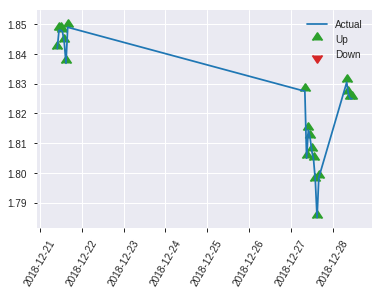


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2646718370859447
RMSE: 0.5144626683112631
LogLoss: 0.7242664849850219
Mean Per-Class Error: 0.4529177718832891
AUC: 0.527934350132626
pr_auc: 0.5127709234742288
Gini: 0.055868700265252036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33403781056404114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    114  0.9828   (114.0/116.0)
1      0    104  0        (0.0/104.0)
Total  2    218  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334038     0.645963  217
max f2                       0.334038     0.820189  217
max f0point5                 0.334038     0.532787  217
max accuracy                 0.70858      0.563636  17
max precision                0.817714     1         0
max recall                   0.334038     1         217
max specificity              0.817714     1         0
max absolute_mcc             0.70858      0.149176  17
max min_per_class_accuracy   0.582044     0.525862  109
max mean_per_class_accuracy  0.573368     0.547082  115

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 56.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.810461           1.41026   1.41026            0.666667         0.814693  0.666667                    0.814693            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.774633           2.11538   1.69231            1                0.793563  0.8                         0.806241            0.0192308       0.0384615                  111.538   69.2308
    3        0.0318182                   0.755163           1.05769   1.51099            0.5              0.760613  0.714286                    0.793204            0.00961538      0.0480769                  5.76923   51.0989
    4        0.0409091                   0.738341           1.05769   1.41026            0.5              0.746046  0.666667                    0.782725            0.00961538      0.0576923                  5.76923   41.0256
    5        0.05                        0.72701            2.11538   1.53846            1                0.732429  0.727273                    0.77358             0.0192308       0.0769231                  111.538   53.8462
    6        0.1                         0.699427           0.961538  1.25               0.454545         0.713585  0.590909                    0.743583            0.0480769       0.125                      -3.84615  25
    7        0.15                        0.680986           0.961538  1.15385            0.454545         0.690138  0.545455                    0.725768            0.0480769       0.173077                   -3.84615  15.3846
    8        0.2                         0.663852           0.769231  1.05769            0.363636         0.673316  0.5                         0.712655            0.0384615       0.211538                   -23.0769  5.76923
    9        0.3                         0.634356           0.865385  0.99359            0.409091         0.649834  0.469697                    0.691715            0.0865385       0.298077                   -13.4615  -0.641026
    10       0.4                         0.605593           1.15385   1.03365            0.545455         0.622358  0.488636                    0.674376            0.115385        0.413462                   15.3846   3.36538
    11       0.5                         0.581796           1.15385   1.05769            0.545455         0.591546  0.5                         0.65781             0.115385        0.528846                   15.3846   5.76923
    12       0.6                         0.558667           1.05769   1.05769            0.5              0.568058  0.5                         0.642851            0.105769        0.634615                   5.76923   5.76923
    13       0.7                         0.508393           0.769231  1.01648            0.363636         0.531474  0.480519                    0.62694             0.0769231       0.711538                   -23.0769  1.64835
    14       0.8                         0.467727           1.05769   1.02163            0.5              0.488644  0.482955                    0.609653            0.105769        0.817308                   5.76923   2.16346
    15       0.9                         0.419306           0.673077  0.982906           0.318182         0.444406  0.464646                    0.591292            0.0673077       0.884615                   -32.6923  -1.7094
    16       1                           0.267186           1.15385   1                  0.545455         0.375347  0.472727                    0.569698            

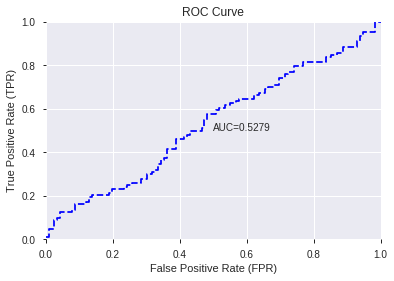

This function is available for GLM models only


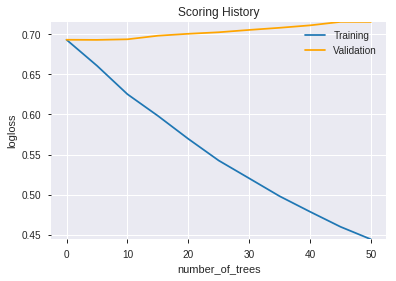

--2019-08-28 12:34:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123353_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123353_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_123457  0.553796  0.774736              0.491379  0.530093  0.280998
1  DeepLearning_grid_1_AutoML_20190828_123457_model_9  0.531582  0.706946              0.487069  0.506811  0.256858
2  DeepLearning_grid_1_AutoML_20190828_123457_model_6  0.493700  0.719374              0.500000  0.512695  0.262856
3  DeepLearning_grid_1_AutoML_20190828_123457_model_2  0.492374  2.294047              0.487069  0.677046  0.458392
4  DeepLearning_grid_1_AutoML_20190828_123457_model_3  0.491628  1.306888              0.483256  0.620817  0.385414
5  DeepLearning_grid_1_AutoML_20190828_123457_model_1  0.491338  3.176551              0.488064  0.669474  0.448196
6  DeepLearning_grid_1_AutoML_20190828_123457_model_8  0.483919  0.699862              0.500000  0.503334  0.253345
7  DeepLearning_grid_1_AutoML_20190828_123457_model_4  0.477868  1.636503              0.491379  0.654982  0.429002
8  DeepLearning_grid_1_AutoML_20190828_123457_model_5  0.474096  0.731734              0.495690  0.518177  0.268507
9  DeepLearning_grid_1_AutoML_20190828_123457_model_7  0.473143  0.788750              0.500000  0.539454  0.291010

variable  relative_importance  scaled_importance  percentage
0          CDLLONGLEGGEDDOJI             1.000000           1.000000    0.028176
1              CDLHANGINGMAN             0.989367           0.989367    0.027877
2                        BOP             0.931838           0.931838    0.026256
3                    BETA_14             0.876500           0.876500    0.024696
4    BBANDS_upperband_14_3_2             0.868243           0.868243    0.024464
5   BBANDS_middleband_20_1_5             0.852635           0.852635    0.024024
6                      MAX_8             0.845414           0.845414    0.023821
7                  CORREL_24             0.829975           0.829975    0.023386
8    BBANDS_lowerband_20_3_4             0.815004           0.815004    0.022964
9                  MAVP_30_6             0.814206           0.814206    0.022941
10            STOCHRSI_fastd             0.810897           0.810897    0.022848
11             days_in_month             0.804310           0.804310    0.022662
12        CDLCLOSINGMARUBOZU             0.790003           0.790003    0.022259
13                       SUB             0.789963           0.789963    0.022258
14                 dayofweek             0.784162           0.784162    0.022095
15   BBANDS_lowerband_14_1_5             0.778853           0.778853    0.021945
16            is_month_start             0.771430           0.771430    0.021736
17                   ADXR_14             0.761890           0.761890    0.021467
18                aroonup_20             0.761375           0.761375    0.021453
19             MINMAX_max_14             0.733741           0.733741    0.020674
20           MACDFIX_hist_14             0.727671           0.727671    0.020503
21            STOCHRSI_fastk             0.721487           0.721487    0.020329
22                   CDLDOJI             0.720095           0.720095    0.020290
23                AROONOSC_8             0.707132           0.707132    0.019924
24  BBANDS_middleband_14_1_5             0.700156           0.700156    0.019728
25               CDLBELTHOLD             0.699233           0.699233    0.019702
26            MACDFIX_hist_8             0.693072           0.693072    0.019528
27                  WCLPRICE             0.687825           0.687825    0.019380
28           CDLHOMINGPIGEON             0.684670           0.684670    0.019291
29                       DIV             0.684554           0.684554    0.019288
30                    ROCP_8             0.679756           0.679756    0.019153
31   BBANDS_lowerband_14_4_2             0.677895           0.677895    0.019101
32   BBANDS_lowerband_24_5_5             0.674998           0.674998    0.019019
33                 CORREL_20             0.673146           0.673146    0.018967
34   BBANDS_lowerband_12_4_4             0.671252           0.671252    0.018913
35              weekday_name             0.667157           0.667157    0.018798
36   BBANDS_upperband_20_7_5             0.660591           0.660591    0.018613
37         CDLINVERTEDHAMMER             0.633129           0.633129    0.017839
38               AROONOSC_24             0.609431           0.609431    0.017171
39               CDL3OUTSIDE             0.600231           0.600231    0.016912
40                  CORREL_8             0.596253           0.596253    0.016800
41                 CDLHAMMER             0.582497           0.582497    0.016413
42                    MFI_12             0.567937           0.567937    0.016002
43         HT_PHASOR_inphase             0.567469           0.567469    0.015989
44  BBANDS_middleband_14_7_4             0.559160           0.559160    0.015755
45   BBANDS_upperband_20_7_2             0.550809           0.550809    0.015520
46  BBANDS_middleband_14_3_4             0.529067           0.529067    0.014907
47                CDLHIKKAKE             0.525591           0.525591    0.014809
48                       OBV             0.432122  

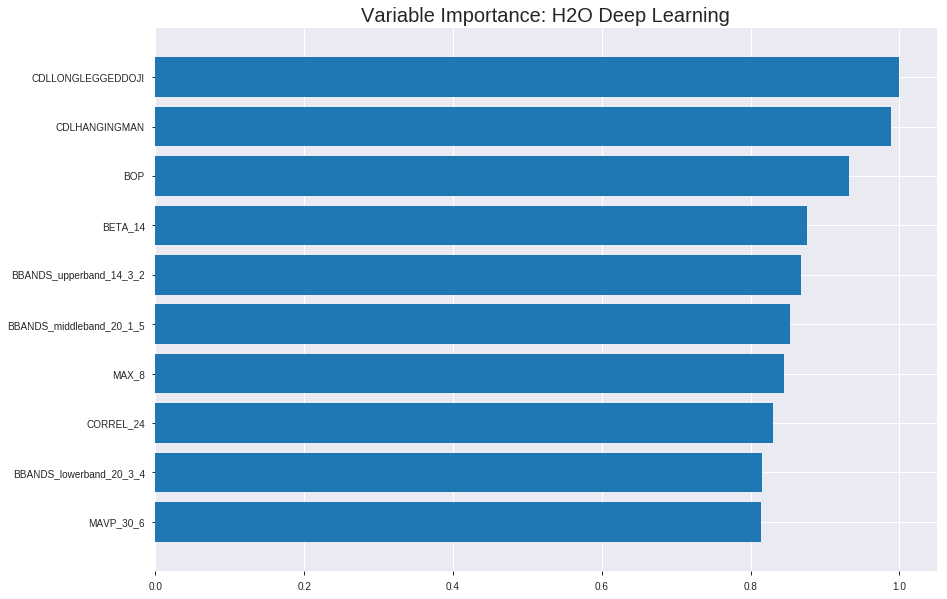

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_123457


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3065615100603226
RMSE: 0.5536799707956959
LogLoss: 0.8809745533457997
Mean Per-Class Error: 0.4700786171000686
AUC: 0.5229532034599678
pr_auc: 0.5222498671161692
Gini: 0.04590640691993553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08128784219606477: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    741   0.9906   (741.0/748.0)
1      3    784   0.0038   (3.0/787.0)
Total  10   1525  0.4847   (744.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0812878    0.678201   393
max f2                       0.0310196    0.840273   399
max f0point5                 0.163316     0.570221   374
max accuracy                 0.492513     0.535505   254
max precision                0.993243     0.666667   2
max recall                   0.0310196    1          399
max specificity              0.998255     0.998663   0
max absolute_mcc             0.488868     0.0667008  255
max min_per_class_accuracy   0.665249     0.513342   168
max mean_per_class_accuracy  0.492513     0.529921   254

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 62.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.982084           1.09713   1.09713            0.5625           0.989839  0.5625                      0.989839            0.0114358       0.0114358                  9.71252   9.71252
    2        0.0201954                   0.971129           0.390089  0.755011           0.2              0.976626  0.387097                    0.983445            0.00381194      0.0152478                  -60.9911  -24.4989
    3        0.0306189                   0.95676            1.09713   0.871475           0.5625           0.962136  0.446809                    0.976191            0.0114358       0.0266836                  9.71252   -12.8525
    4        0.0403909                   0.946868           1.04024   0.912305           0.533333         0.951611  0.467742                    0.970245            0.0101652       0.0368488                  4.02372   -8.76952
    5        0.0501629                   0.940315           0.780178  0.886566           0.4              0.943833  0.454545                    0.965099            0.00762389      0.0444727                  -21.9822  -11.3434
    6        0.100326                    0.912972           1.06388   0.975222           0.545455         0.926197  0.5                         0.945648            0.0533672       0.0978399                  6.38789   -2.47776
    7        0.150489                    0.87858            1.13987   1.03011            0.584416         0.894273  0.528139                    0.928523            0.0571792       0.155019                   13.987    3.0105
    8        0.2                         0.84784            1.28319   1.09276            0.657895         0.864246  0.560261                    0.912611            0.0635324       0.218551                   28.3187   9.27573
    9        0.300326                    0.791851           0.924561  1.03657            0.474026         0.818574  0.531453                    0.881197            0.0927573       0.311309                   -7.54385  3.65704
    10       0.4                         0.730999           0.930604  1.01017            0.477124         0.762808  0.517915                    0.851696            0.0927573       0.404066                   -6.93957  1.01652
    11       0.500326                    0.663896           1.08921   1.02602            0.558442         0.697082  0.526042                    0.820693            0.109276        0.513342                   8.92094   2.60152
    12       0.6                         0.5842             1.04534   1.02922            0.535948         0.625169  0.527687                    0.788212            0.104193        0.617535                   4.53364   2.92249
    13       0.699674                    0.507474           1.10908   1.0406             0.568627         0.545924  0.53352                     0.753696            0.110546        0.728081                   10.9076   4.06004
    14       0.8                         0.399578           0.873901  1.0197             0.448052         0.460087  0.522801                    0.716875            0.0876747       0.815756                   -12.6099  1.9695
    15       0.899674                    0.279071           0.905108  1.007              0.464052         0.342501  0.516293                    0.675399            0.090216        0.905972                   -9.48917  0.700007
    16       1                           0.0310196          0.937227  1                  0.480519         0.192859  0.512704                    0.626987     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29312601008327044
RMSE: 0.5414111285181257
LogLoss: 0.8122909081890396
Mean Per-Class Error: 0.455799650357015
AUC: 0.5219580007161362
pr_auc: 0.5675278941759955
Gini: 0.04391600143227237
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03169004337939932: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    197  1        (197.0/197.0)
1      0    241  0        (0.0/241.0)
Total  0    438  0.4498   (197.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.03169      0.709867  399
max f2                       0.03169      0.859486  399
max f0point5                 0.105851     0.605519  391
max accuracy                 0.358964     0.561644  266
max precision                0.969059     1         0
max recall                   0.03169      1         399
max specificity              0.969059     1         0
max absolute_mcc             0.358964     0.094126  266
max min_per_class_accuracy   0.448598     0.514523  199
max mean_per_class_accuracy  0.358964     0.5442    266

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 47.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.947304           1.09046   1.09046            0.6              0.95871   0.6                         0.95871             0.0124481       0.0124481                  9.04564    9.04564
    2        0.0205479                   0.923553           1.81743   1.41355            1                0.93461   0.777778                    0.947999            0.0165975       0.0290456                  81.7427    41.3555
    3        0.0319635                   0.901869           0.726971  1.16835            0.4              0.913514  0.642857                    0.935683            0.00829876      0.0373444                  -27.3029   16.8346
    4        0.0410959                   0.875799           0.908714  1.11065            0.5              0.890111  0.611111                    0.925556            0.00829876      0.0456432                  -9.12863   11.065
    5        0.0502283                   0.862217           0.908714  1.07393            0.5              0.869774  0.590909                    0.915414            0.00829876      0.0539419                  -9.12863   7.39344
    6        0.100457                    0.801818           1.15654   1.11524            0.636364         0.832596  0.613636                    0.874005            0.0580913       0.112033                   15.6545    11.524
    7        0.150685                    0.721583           0.908714  1.0464             0.5              0.762695  0.575758                    0.836902            0.0456432       0.157676                   -9.12863   4.63976
    8        0.200913                    0.670635           1.07393   1.05328            0.590909         0.695063  0.579545                    0.801442            0.0539419       0.211618                   7.39344    5.32818
    9        0.30137                     0.58303            0.991324  1.03263            0.545455         0.625689  0.568182                    0.742858            0.0995851       0.311203                   -0.867597  3.26292
    10       0.399543                    0.516431           0.972112  1.01776            0.534884         0.548615  0.56                        0.69513             0.0954357       0.406639                   -2.78877   1.77593
    11       0.5                         0.447841           1.07393   1.02905            0.590909         0.478499  0.56621                     0.651606            0.107884        0.514523                   7.39344    2.90456
    12       0.600457                    0.39657            0.991324  1.02273            0.545455         0.42527   0.562738                    0.61374             0.0995851       0.614108                   -0.867597  2.27348
    13       0.69863                     0.339451           1.14118   1.03938            0.627907         0.370614  0.571895                    0.579575            0.112033        0.726141                   14.1175    3.93784
    14       0.799087                    0.261238           0.908714  1.02295            0.5              0.298378  0.562857                    0.544225            0.0912863       0.817427                   -9.12863   2.2952
    15       0.899543                    0.195687           0.702188  0.987131           0.386364         0.227985  0.543147                    0.508908            0.0705394       0.887967                   -29.7812   -1.28694
    16       1                           0.03169            1.11524   1                  0.613636         0.138134  0.550228                    0.


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:34:58  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:34:58  0.096 sec   45147 obs/sec     1         1             1535       0.55368          0.880975            -0.227038      0.522953        0.52225            1.09713          0.484691                         0.541411           0.812291              -0.184457        0.521958          0.567528             1.09046            0.449772
    2019-08-28 12:34:58  0.307 sec   70412 obs/sec     10        10            15350      0.521942         0.750883            -0.0903971     0.623367        0.61904            1.95044          0.467752                         0.541043           0.821856              -0.182849        0.493597          0.554979             1.09046            0.449772
    2019-08-28 12:34:58  0.339 sec   69457 obs/sec     10        10            15350      0.55368          0.880975            -0.227038      0.522953        0.52225            1.09713          0.484691                         0.541411           0.812291              -0.184457        0.521958          0.567528             1.09046            0.449772

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLLONGLEGGEDDOJI         1.0                    1.0                  0.028176245258923253
CDLHANGINGMAN             0.9893669486045837     0.9893669486045837   0.027876645794955267
BOP                       0.9318382740020752     0.9318382740020752   0.026255703749934196
BETA_14                   0.8764997124671936     0.8764997124671936   0.02469647086785136
BBANDS_upperband_14_3_2   0.8682432770729065     0.8682432770729065   0.02446383551921747
---                       ---                    ---                  ---
BBANDS_upperband_20_7_2   0.5508087873458862     0.5508087873458862   0.015519723483027792
BBANDS_middleband_14_3_4  0.5290665030479431     0.5290665030479431   0.014907107548159711
CDLHIKKAKE                0.5255913734436035     0.5255913734436035   0.014809191444121295
OBV                       0.4321224093437195     0.4321224093437195   0.01217558698754547
aroondown_24              0.39669740200042725    0.39669740200042725  0.01117744329234171


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5863636363636363)

('F1', 0.6459627329192547)

('auc', 0.5537964190981433)

('logloss', 0.774735631368402)

('mean_per_class_error', 0.43053713527851456)

('rmse', 0.5300928574609811)

('mse', 0.280998437531148)

deeplearning prediction progress: |███████████████████████████████████████| 100%


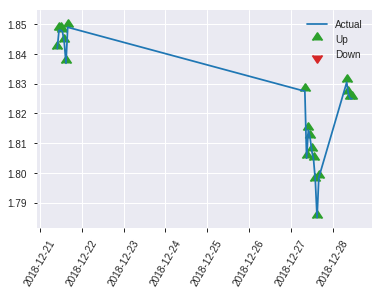


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.280998437531148
RMSE: 0.5300928574609811
LogLoss: 0.774735631368402
Mean Per-Class Error: 0.43053713527851456
AUC: 0.5537964190981433
pr_auc: 0.5426630389356508
Gini: 0.10759283819628651
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12642605515606964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    114  0.9828   (114.0/116.0)
1      0    104  0        (0.0/104.0)
Total  2    218  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.126426     0.645963  217
max f2                       0.126426     0.820189  217
max f0point5                 0.513862     0.536859  129
max accuracy                 0.752044     0.586364  40
max precision                0.964998     1         0
max recall                   0.126426     1         217
max specificity              0.964998     1         0
max absolute_mcc             0.752044     0.178119  40
max min_per_class_accuracy   0.591854     0.548077  107
max mean_per_class_accuracy  0.752044     0.569463  40

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 56.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.935828           2.11538   2.11538            1                0.946761  1                           0.946761            0.0288462       0.0288462                  111.538   111.538
    2        0.0227273                   0.925605           2.11538   2.11538            1                0.932452  1                           0.941038            0.0192308       0.0480769                  111.538   111.538
    3        0.0318182                   0.905431           0         1.51099            0                0.914934  0.714286                    0.93358             0               0.0480769                  -100      51.0989
    4        0.0409091                   0.883755           2.11538   1.6453             1                0.891217  0.777778                    0.924166            0.0192308       0.0673077                  111.538   64.5299
    5        0.05                        0.879396           0         1.34615            0                0.881888  0.636364                    0.916479            0               0.0673077                  -100      34.6154
    6        0.1                         0.846631           0.961538  1.15385            0.454545         0.867651  0.545455                    0.892065            0.0480769       0.115385                   -3.84615  15.3846
    7        0.15                        0.77896            1.34615   1.21795            0.636364         0.805354  0.575758                    0.863161            0.0673077       0.182692                   34.6154   21.7949
    8        0.2                         0.744062           1.53846   1.29808            0.727273         0.760319  0.613636                    0.837451            0.0769231       0.259615                   53.8462   29.8077
    9        0.3                         0.677272           1.05769   1.21795            0.5              0.713217  0.575758                    0.796039            0.105769        0.365385                   5.76923   21.7949
    10       0.4                         0.632565           0.865385  1.12981            0.409091         0.65603   0.534091                    0.761037            0.0865385       0.451923                   -13.4615  12.9808
    11       0.5                         0.58807            0.961538  1.09615            0.454545         0.607996  0.518182                    0.730429            0.0961538       0.548077                   -3.84615  9.61538
    12       0.6                         0.51071            0.961538  1.07372            0.454545         0.543537  0.507576                    0.69928             0.0961538       0.644231                   -3.84615  7.37179
    13       0.7                         0.45225            0.769231  1.03022            0.363636         0.481423  0.487013                    0.668158            0.0769231       0.721154                   -23.0769  3.02198
    14       0.8                         0.365501           0.865385  1.00962            0.409091         0.407891  0.477273                    0.635624            0.0865385       0.807692                   -13.4615  0.961538
    15       0.9                         0.286192           0.961538  1.00427            0.454545         0.326781  0.474747                    0.601308            0.0961538       0.903846                   -3.84615  0.42735
    16       1                           0.0791317          0.961538  1                  0.454545         0.21935   0.472727                    0.563113        

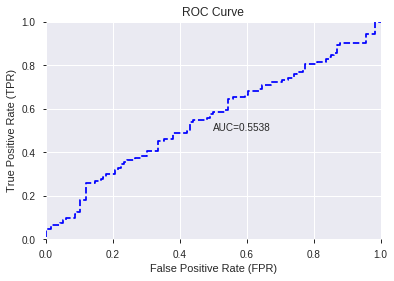

This function is available for GLM models only


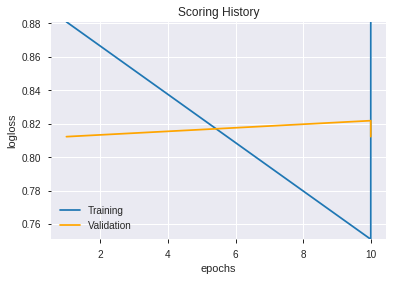

--2019-08-28 12:41:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_123457',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_123457',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_be75'

['CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'BOP',
 'BETA_14',
 'BBANDS_upperband_14_3_2',
 'BBANDS_middleband_20_1_5',
 'MAX_8',
 'CORREL_24',
 'BBANDS_lowerband_20_3_4',
 'MAVP_30_6',
 'STOCHRSI_fastd',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'dayofweek',
 'BBANDS_lowerband_14_1_5',
 'is_month_start',
 'ADXR_14',
 'aroonup_20',
 'MINMAX_max_14',
 'MACDFIX_hist_14',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'AROONOSC_8',
 'BBANDS_middleband_14_1_5',
 'CDLBELTHOLD',
 'MACDFIX_hist_8',
 'WCLPRICE',
 'CDLHOMINGPIGEON',
 'DIV',
 'ROCP_8',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_lowerband_24_5_5',
 'CORREL_20',
 'BBANDS_lowerband_12_4_4',
 'weekday_name',
 'BBANDS_upperband_20_7_5',
 'CDLINVERTEDHAMMER',
 'AROONOSC_24',
 'CDL3OUTSIDE',
 'CORREL_8',
 'CDLHAMMER',
 'MFI_12',
 'HT_PHASOR_inphase',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_20_7_2',
 'BBANDS_middleband_14_3_4',
 'CDLHIKKAKE',
 'OBV',
 'aroondown_24']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_124201_model_1  0.496436  0.69604              0.478448  0.501443  0.251445

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk             0.016953           1.000000    0.066872
1                CDLBELTHOLD             0.015739           0.928381    0.062082
2                        BOP             0.014753           0.870245    0.058195
3                CDL3OUTSIDE             0.013977           0.824462    0.055133
4              days_in_month             0.013250           0.781581    0.052266
5         CDLCLOSINGMARUBOZU             0.013093           0.772306    0.051645
6          HT_PHASOR_inphase             0.012584           0.742302    0.049639
7                  CDLHAMMER             0.012092           0.713285    0.047699
8              CDLHANGINGMAN             0.011299           0.666489    0.044569
9                        OBV             0.010934           0.644955    0.043129
10                  CORREL_8             0.009505           0.560670    0.037493
11           CDLHOMINGPIGEON             0.008742           0.515645    0.034482
12              weekday_name             0.008323           0.490968    0.032832
13                    ROCP_8             0.007426           0.438007    0.029290
14            STOCHRSI_fastd             0.006904           0.407230    0.027232
15   BBANDS_lowerband_24_5_5             0.005357           0.316005    0.021132
16         CDLINVERTEDHAMMER             0.005248           0.309584    0.020702
17         CDLLONGLEGGEDDOJI             0.005097           0.300675    0.020107
18                   CDLDOJI             0.005097           0.300635    0.020104
19            is_month_start             0.004711           0.277911    0.018584
20                 CORREL_20             0.004272           0.251969    0.016850
21                       DIV             0.003455           0.203786    0.013628
22                   ADXR_14             0.002825           0.166626    0.011143
23                CDLHIKKAKE             0.002785           0.164264    0.010985
24                    MFI_12             0.002564           0.151214    0.010112
25            MACDFIX_hist_8             0.002500           0.147457    0.009861
26                aroonup_20             0.002497           0.147314    0.009851
27   BBANDS_lowerband_20_3_4             0.002370           0.139822    0.009350
28                       SUB             0.002337           0.137871    0.009220
29                     MAX_8             0.002249           0.132636    0.008870
30              aroondown_24             0.002247           0.132557    0.008864
31                 CORREL_24             0.002070           0.122129    0.008167
32           MACDFIX_hist_14             0.002041           0.120396    0.008051
33                 dayofweek             0.001888           0.111337    0.007445
34             MINMAX_max_14             0.001831           0.108009    0.007223
35               AROONOSC_24             0.001628           0.096051    0.006423
36  BBANDS_middleband_20_1_5             0.001515           0.089339    0.005974
37                  WCLPRICE             0.001448           0.085424    0.005712
38                AROONOSC_8             0.001263           0.074511    0.004983
39  BBANDS_middleband_14_1_5             0.001228           0.072433    0.004844
40   BBANDS_lowerband_14_1_5             0.001136           0.067019    0.004482
41  BBANDS_middleband_14_7_4             0.001106           0.065250    0.004363
42   BBANDS_upperband_20_7_5             0.001025           0.060484    0.004045
43   BBANDS_lowerband_12_4_4             0.001014           0.059823    0.004000
44                 MAVP_30_6             0.000991           0.058466    0.003910
45  BBANDS_middleband_14_3_4             0.000632           0.037301    0.002494
46   BBANDS_upperband_14_3_2             0.000586           0.034549    0.002310
47   BBANDS_lowerband_14_4_2             0.000478           0.028201    0.001886
48   BBANDS_upperband_20_7_2             0.000225  

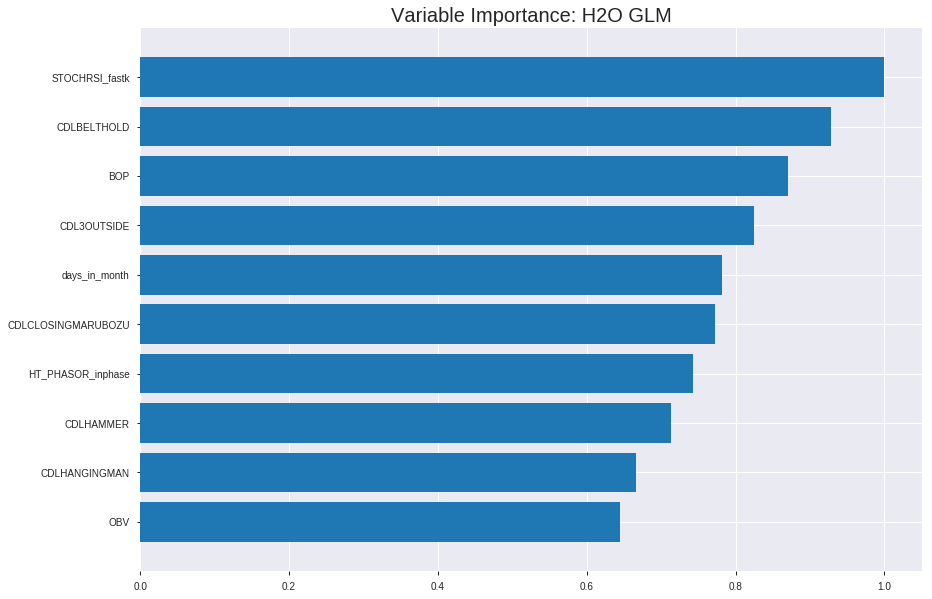

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_124201_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24815424543847417
RMSE: 0.4981508259939696
LogLoss: 0.689450302181329
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.970858206576
Residual deviance: 2116.61242769668
AIC: 2218.61242769668
AUC: 0.565286337475963
pr_auc: 0.5580572884674424
Gini: 0.13057267495192604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4791920835059164: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      23   725   0.9693   (725.0/748.0)
1      6    781   0.0076   (6.0/787.0)
Total  29   1506  0.4762   (731.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479192     0.681204  377
max f2                       0.46247      0.840992  396
max f0point5                 0.501187     0.579015  277
max accuracy                 0.510249     0.554397  217
max precision                0.605015     1         0
max recall                   0.46247      1         396
max specificity              0.605015     1         0
max absolute_mcc             0.516235     0.107721  175
max min_per_class_accuracy   0.512448     0.546791  201
max mean_per_class_accuracy  0.510249     0.552983  217

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.55292            1.09713   1.09713            0.5625           0.563992  0.5625                      0.563992            0.0114358       0.0114358                  9.71252   9.71252
    2        0.0201954                   0.546031           1.3003    1.19543            0.666667         0.548831  0.612903                    0.556656            0.0127065       0.0241423                  30.0296   19.5434
    3        0.0306189                   0.543345           0.85332   1.07897            0.4375           0.544464  0.553191                    0.552506            0.00889454      0.0330368                  -14.668   7.89694
    4        0.0403909                   0.541461           1.17027   1.10106            0.6              0.542168  0.564516                    0.550005            0.0114358       0.0444727                  17.0267   10.1058
    5        0.0501629                   0.540021           1.17027   1.11454            0.6              0.540894  0.571429                    0.54823             0.0114358       0.0559085                  17.0267   11.454
    6        0.100326                    0.533631           1.19053   1.15254            0.61039          0.537001  0.590909                    0.542616            0.0597205       0.115629                   19.0531   15.2536
    7        0.150489                    0.529936           0.987888  1.09765            0.506494         0.531687  0.562771                    0.538973            0.0495553       0.165184                   -1.21124  9.76529
    8        0.2                         0.527013           1.1292    1.10546            0.578947         0.528468  0.566775                    0.536372            0.0559085       0.221093                   12.9205   10.5464
    9        0.300326                    0.521376           1.13987   1.11696            0.584416         0.524201  0.572668                    0.532306            0.114358        0.335451                   13.987    11.6958
    10       0.4                         0.516515           1.14732   1.12452            0.588235         0.518909  0.576547                    0.528968            0.114358        0.449809                   14.732    12.4524
    11       0.500326                    0.512437           0.987888  1.09713            0.506494         0.514225  0.5625                      0.526012            0.0991105       0.54892                    -1.21124  9.71252
    12       0.6                         0.508507           0.968848  1.07582            0.496732         0.510519  0.551574                    0.523438            0.0965693       0.645489                   -3.11516  7.58153
    13       0.699674                    0.504122           0.930604  1.05513            0.477124         0.506314  0.540968                    0.520999            0.0927573       0.738247                   -6.93957  5.51289
    14       0.8                         0.49849            0.987888  1.0467             0.506494         0.501432  0.536645                    0.518545            0.0991105       0.837357                   -1.21124  4.66963
    15       0.899674                    0.491125           0.854116  1.02536            0.437908         0.4951    0.525706                    0.515947            0.0851334       0.92249                    -14.5884  2.53605
    16       1                           0.46086            0.772579  1                  0.396104         0.483614  0.512704                    0.512704          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24873505399831322
RMSE: 0.4987334498490283
LogLoss: 0.6906141571926007
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 605.243449119525
Residual deviance: 604.9780017007182
AIC: 706.9780017007182
AUC: 0.5146386671440908
pr_auc: 0.5692427720690895
Gini: 0.029277334288181578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4745197726165046: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.47452      0.710914   398
max f2                       0.47452      0.8601     398
max f0point5                 0.47452      0.605832   398
max accuracy                 0.486738     0.552511   378
max precision                0.541261     0.666667   17
max recall                   0.47452      1          398
max specificity              0.557805     0.994924   0
max absolute_mcc             0.527855     0.0927251  79
max min_per_class_accuracy   0.513247     0.502538   202
max mean_per_class_accuracy  0.527855     0.536354   79

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.54885            0.726971  0.726971           0.4              0.552269  0.4                         0.552269            0.00829876      0.00829876                 -27.3029   -27.3029
    2        0.0205479                   0.545215           0.908714  0.807746           0.5              0.547579  0.444444                    0.550184            0.00829876      0.0165975                  -9.12863   -19.2254
    3        0.0319635                   0.541927           1.45394   1.03853            0.8              0.543669  0.571429                    0.547858            0.0165975       0.033195                   45.3942    3.85299
    4        0.0410959                   0.540973           1.81743   1.21162            1                0.541462  0.666667                    0.546436            0.0165975       0.0497925                  81.7427    21.1618
    5        0.0502283                   0.538142           0.454357  1.07393            0.25             0.539632  0.590909                    0.545199            0.00414938      0.0539419                  -54.5643   7.39344
    6        0.100457                    0.533367           1.23916   1.15654            0.681818         0.535584  0.636364                    0.540392            0.0622407       0.116183                   23.9155    15.6545
    7        0.150685                    0.529798           1.15654   1.15654            0.636364         0.531613  0.636364                    0.537465            0.0580913       0.174274                   15.6545    15.6545
    8        0.200913                    0.527014           0.991324  1.11524            0.545455         0.528126  0.613636                    0.53513             0.0497925       0.224066                   -0.867597  11.524
    9        0.30137                     0.520714           0.950019  1.06017            0.522727         0.523703  0.583333                    0.531321            0.0954357       0.319502                   -4.99811   6.0166
    10       0.399543                    0.516653           0.929847  1.02814            0.511628         0.51856   0.565714                    0.528186            0.0912863       0.410788                   -7.01534   2.81446
    11       0.5                         0.513348           0.908714  1.00415            0.5              0.515027  0.552511                    0.525542            0.0912863       0.502075                   -9.12863   0.414938
    12       0.600457                    0.508827           1.11524   1.02273            0.613636         0.510886  0.562738                    0.52309             0.112033        0.614108                   11.524     2.27348
    13       0.69863                     0.505264           0.887581  1.00374            0.488372         0.506922  0.552288                    0.520818            0.0871369       0.701245                   -11.2419   0.374258
    14       0.799087                    0.500531           0.826103  0.981411           0.454545         0.503058  0.54                        0.518585            0.0829876       0.784232                   -17.3897   -1.85892
    15       0.899543                    0.493619           1.15654   1.00097            0.636364         0.497495  0.550761                    0.51623             0.116183        0.900415                   15.6545    0.096889
    16       1                           0.473546           0.991324  1                  0.545455         0.484946  0.550228                


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:42:02  0.000 sec   2            3         51            1.38219           1.38153
    2019-08-28 12:42:02  0.014 sec   4            1.9       51            1.38072           1.38135
    2019-08-28 12:42:02  0.033 sec   6            1.2       51            1.3789            1.38123
    2019-08-28 12:42:02  0.048 sec   8            0.72      51            1.37687           1.38131
    2019-08-28 12:42:02  0.059 sec   10           0.44      51            1.37483           1.38176
    2019-08-28 12:42:02  0.070 sec   12           0.28      51            1.37298           1.38266
    2019-08-28 12:42:02  0.086 sec   14           0.17      51            1.37143           1.38394
    2019-08-28 12:42:02  0.097 sec   16           0.11      51            1.37018           1.38546

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.652037617554859)

('auc', 0.4964356763925729)

('logloss', 0.6960401558559972)

('mean_per_class_error', 0.4761273209549072)

('rmse', 0.5014429841393268)

('mse', 0.25144506634255315)

glm prediction progress: |████████████████████████████████████████████████| 100%


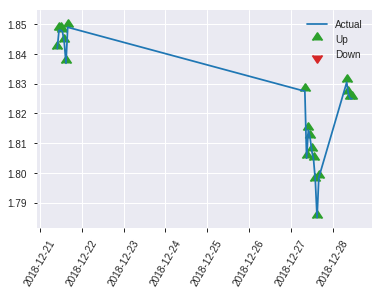


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25144506634255315
RMSE: 0.5014429841393268
LogLoss: 0.6960401558559972
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.73672384847293
Residual deviance: 306.25766857663876
AIC: 408.25766857663876
AUC: 0.4964356763925729
pr_auc: 0.47824282511009397
Gini: -0.007128647214854178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4938025843840895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    111  0.9569   (111.0/116.0)
1      0    104  0        (0.0/104.0)
Total  5    215  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493803     0.652038  214
max f2                       0.493803     0.824089  214
max f0point5                 0.493803     0.539419  214
max accuracy                 0.542835     0.545455  17
max precision                0.572312     1         0
max recall                   0.493803     1         214
max specificity              0.572312     1         0
max absolute_mcc             0.493803     0.144395  214
max min_per_class_accuracy   0.520488     0.480769  109
max mean_per_class_accuracy  0.498004     0.523873  205

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.56011            1.41026   1.41026            0.666667         0.566749  0.666667                    0.566749            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.552687           1.05769   1.26923            0.5              0.554524  0.6                         0.561859            0.00961538      0.0288462                  5.76923   26.9231
    3        0.0318182                   0.548274           1.05769   1.20879            0.5              0.549569  0.571429                    0.558348            0.00961538      0.0384615                  5.76923   20.8791
    4        0.0409091                   0.545213           2.11538   1.41026            1                0.548012  0.666667                    0.556051            0.0192308       0.0576923                  111.538   41.0256
    5        0.05                        0.544236           1.05769   1.34615            0.5              0.5444    0.636364                    0.553933            0.00961538      0.0673077                  5.76923   34.6154
    6        0.1                         0.541334           0.769231  1.05769            0.363636         0.543047  0.5                         0.54849             0.0384615       0.105769                   -23.0769  5.76923
    7        0.15                        0.534512           0.769231  0.961538           0.363636         0.537664  0.454545                    0.544881            0.0384615       0.144231                   -23.0769  -3.84615
    8        0.2                         0.532447           1.34615   1.05769            0.636364         0.533742  0.5                         0.542096            0.0673077       0.211538                   34.6154   5.76923
    9        0.3                         0.528273           0.865385  0.99359            0.409091         0.530326  0.469697                    0.538173            0.0865385       0.298077                   -13.4615  -0.641026
    10       0.4                         0.523806           0.865385  0.961538           0.409091         0.526388  0.454545                    0.535227            0.0865385       0.384615                   -13.4615  -3.84615
    11       0.5                         0.52046            0.961538  0.961538           0.454545         0.522253  0.454545                    0.532632            0.0961538       0.480769                   -3.84615  -3.84615
    12       0.6                         0.515815           0.865385  0.945513           0.409091         0.517823  0.44697                     0.530164            0.0865385       0.567308                   -13.4615  -5.44872
    13       0.7                         0.511392           1.34615   1.00275            0.636364         0.513532  0.474026                    0.527788            0.134615        0.701923                   34.6154   0.274725
    14       0.8                         0.507606           1.05769   1.00962            0.5              0.509693  0.477273                    0.525526            0.105769        0.807692                   5.76923   0.961538
    15       0.9                         0.503286           1.05769   1.01496            0.5              0.505673  0.479798                    0.52332             0.105769        0.913462                   5.76923   1.49573
    16       1                           0.480532           0.865385  1                  0.409091         0.494679  0.472727                    0.520456 

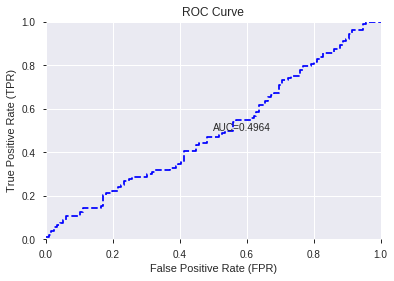

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


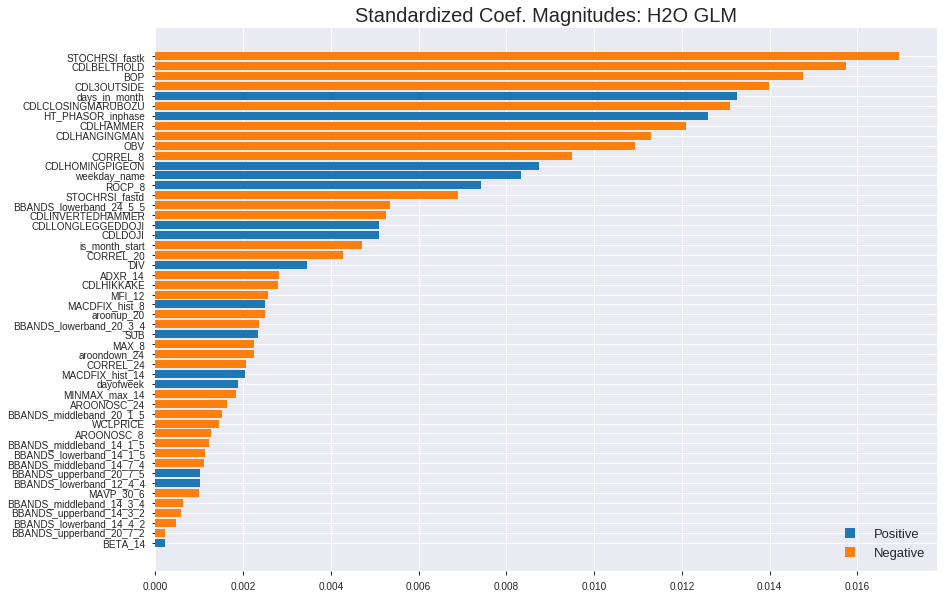

'log_likelihood'
--2019-08-28 12:42:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_124201_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_124201_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['STOCHRSI_fastk',
 'CDLBELTHOLD',
 'BOP',
 'CDL3OUTSIDE',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'HT_PHASOR_inphase',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'OBV',
 'CORREL_8',
 'CDLHOMINGPIGEON',
 'weekday_name',
 'ROCP_8',
 'STOCHRSI_fastd',
 'BBANDS_lowerband_24_5_5',
 'CDLINVERTEDHAMMER',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'is_month_start',
 'CORREL_20',
 'DIV',
 'ADXR_14',
 'CDLHIKKAKE',
 'MFI_12',
 'MACDFIX_hist_8',
 'aroonup_20',
 'BBANDS_lowerband_20_3_4',
 'SUB',
 'MAX_8',
 'aroondown_24',
 'CORREL_24',
 'MACDFIX_hist_14',
 'dayofweek',
 'MINMAX_max_14',
 'AROONOSC_24',
 'BBANDS_middleband_20_1_5',
 'WCLPRICE',
 'AROONOSC_8',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_20_7_5',
 'BBANDS_lowerband_12_4_4',
 'MAVP_30_6',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_14_3_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_20_7_2',
 'BETA_14']

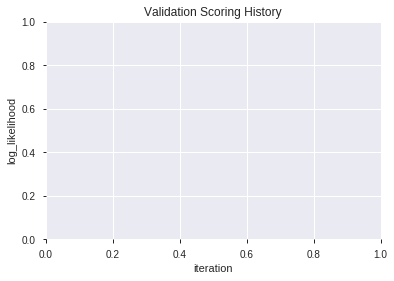

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_124217_model_1  0.562003  0.693458              0.495690  0.500104  0.250104
1               XGBoost_1_AutoML_20190828_124217  0.543186  0.720753              0.495690  0.512928  0.263095
2               XGBoost_3_AutoML_20190828_124217  0.542938  0.705556              0.452255  0.505951  0.255986
3  XGBoost_grid_1_AutoML_20190828_124217_model_5  0.531499  0.725890              0.495690  0.515009  0.265234
4  XGBoost_grid_1_AutoML_20190828_124217_model_2  0.531167  0.703092              0.495690  0.504813  0.254836
5  XGBoost_grid_1_AutoML_20190828_124217_model_7  0.529261  0.720450              0.500000  0.512725  0.262887
6  XGBoost_grid_1_AutoML_20190828_124217_model_4  0.525779  0.704998              0.495690  0.505792  0.255826
7  XGBoost_grid_1_AutoML_20190828_124217_model_6  0.513677  0.708352              0.491877  0.507341  0.257395
8               XGBoost_2_AutoML_20190828_124217  0.506300  0.717029              0.500000  0.511118  0.261242
9  XGBoost_grid_1_AutoML_20190828_124217_model_3  0.470822  0.715781              0.495690  0.510902  0.261021

variable  relative_importance  scaled_importance  percentage
0          HT_PHASOR_inphase           257.134613           1.000000    0.073209
1                        OBV           241.106323           0.937666    0.068645
2                  CORREL_20           194.044373           0.754641    0.055246
3                  CORREL_24           190.334732           0.740214    0.054190
4                AROONOSC_24           178.315140           0.693470    0.050768
5                   CORREL_8           169.133926           0.657764    0.048154
6                    BETA_14           157.115402           0.611024    0.044732
7                        SUB           156.275345           0.607757    0.044493
8                        BOP           147.664780           0.574270    0.042042
9             STOCHRSI_fastd           141.994263           0.552218    0.040427
10            STOCHRSI_fastk           138.914566           0.540241    0.039550
11                       DIV           117.982491           0.458836    0.033591
12                   ADXR_14           112.635269           0.438040    0.032068
13                    MFI_12           104.298943           0.405620    0.029695
14           MACDFIX_hist_14            98.400337           0.382680    0.028016
15            MACDFIX_hist_8            96.059654           0.373577    0.027349
16  BBANDS_middleband_20_1_5            86.958336           0.338182    0.024758
17   BBANDS_lowerband_20_3_4            85.819031           0.333751    0.024433
18   BBANDS_upperband_20_7_5            73.082230           0.284218    0.020807
19                aroonup_20            71.128128           0.276618    0.020251
20        CDLCLOSINGMARUBOZU            69.684502           0.271004    0.019840
21   BBANDS_upperband_20_7_2            68.756401           0.267395    0.019576
22                    ROCP_8            66.302170           0.257850    0.018877
23   BBANDS_lowerband_24_5_5            60.820827           0.236533    0.017316
24                 MAVP_30_6            50.894680           0.197930    0.014490
25   BBANDS_lowerband_12_4_4            49.513767           0.192560    0.014097
26   BBANDS_lowerband_14_1_5            42.306091           0.164529    0.012045
27  BBANDS_middleband_14_7_4            39.009819           0.151710    0.011106
28              aroondown_24            32.222027           0.125312    0.009174
29   BBANDS_upperband_14_3_2            30.188808           0.117405    0.008595
30                AROONOSC_8            28.803211           0.112016    0.008201
31  BBANDS_middleband_14_1_5            26.184608           0.101832    0.007455
32  BBANDS_middleband_14_3_4            22.825169           0.088767    0.006499
33             MINMAX_max_14            22.125528           0.086046    0.006299
34                     MAX_8            20.524107           0.079819    0.005843
35   BBANDS_lowerband_14_4_2            19.337006           0.075202    0.005505
36                 dayofweek            18.943235           0.073670    0.005393
37              weekday_name            18.067972           0.070267    0.005144
38                  WCLPRICE             5.929749           0.023061    0.001688
39             days_in_month             1.513885           0.005888    0.000431

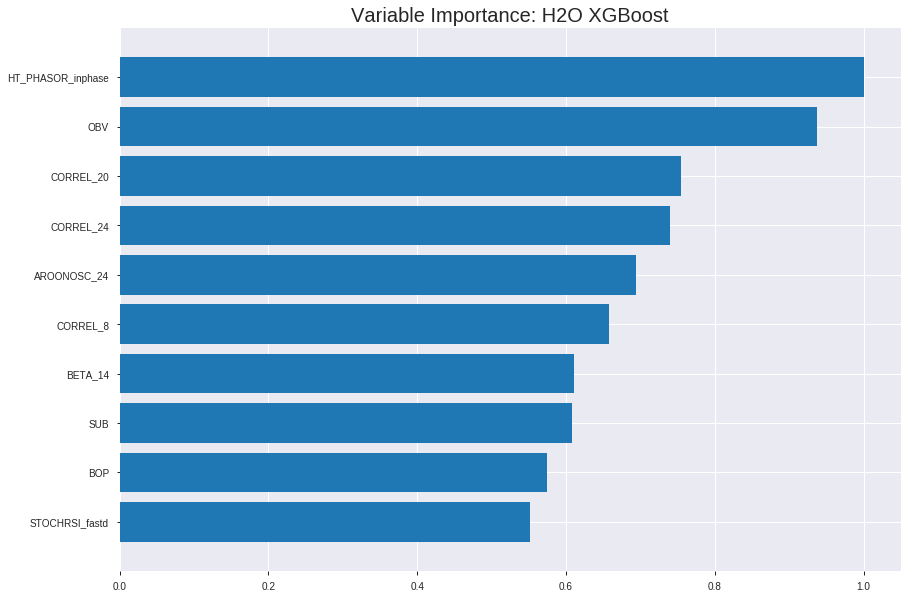

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_124217_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19540516970662553
RMSE: 0.44204656961300526
LogLoss: 0.5814840282340988
Mean Per-Class Error: 0.16989991098668877
AUC: 0.9113094469623358
pr_auc: 0.9200024459064075
Gini: 0.8226188939246717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5140468733651298: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      603  145  0.1939   (145.0/748.0)
1      120  667  0.1525   (120.0/787.0)
Total  723  812  0.1726   (265.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514047     0.834271  197
max f2                       0.467432     0.888391  253
max f0point5                 0.546058     0.857866  158
max accuracy                 0.526201     0.829316  183
max precision                0.75696      1         0
max recall                   0.339599     1         361
max specificity              0.75696      1         0
max absolute_mcc             0.526201     0.660655  183
max min_per_class_accuracy   0.519204     0.824866  192
max mean_per_class_accuracy  0.526201     0.8301    183

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.697123           1.95044    1.95044            1                0.711517  1                           0.711517            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.678666           1.95044    1.95044            1                0.687252  1                           0.699776            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.665981           1.95044    1.95044            1                0.671838  1                           0.690265            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.658304           1.95044    1.95044            1                0.663106  1                           0.683694            0.0190597       0.0787802                  95.0445   95.0445
    5        0.0501629                   0.650221           1.95044    1.95044            1                0.653864  1                           0.677883            0.0190597       0.0978399                  95.0445   95.0445
    6        0.100326                    0.623637           1.95044    1.95044            1                0.637065  1                           0.657474            0.0978399       0.19568                    95.0445   95.0445
    7        0.150489                    0.604933           1.89978    1.93356            0.974026         0.614447  0.991342                    0.643132            0.0952986       0.290978                   89.9784   93.3558
    8        0.2                         0.592219           1.79646    1.89962            0.921053         0.598909  0.973941                    0.632184            0.0889454       0.379924                   79.6462   89.9619
    9        0.300326                    0.567576           1.79846    1.86583            0.922078         0.579535  0.956616                    0.614596            0.180432        0.560356                   79.8462   86.5827
    10       0.4                         0.541949           1.45327    1.76302            0.745098         0.554186  0.903909                    0.599543            0.144854        0.70521                    45.3273   76.3024
    11       0.500326                    0.521041           1.11454    1.63299            0.571429         0.531753  0.83724                     0.58595             0.111817        0.817027                   11.454    63.299
    12       0.6                         0.496089           0.82862    1.49936            0.424837         0.50751   0.76873                     0.572919            0.0825921       0.899619                   -17.138   49.9365
    13       0.699674                    0.469831           0.522668   1.36023            0.267974         0.482841  0.697393                    0.560087            0.0520966       0.951715                   -47.7332  36.0226
    14       0.8                         0.43532            0.316631   1.22935            0.162338         0.454509  0.630293                    0.546846            0.0317662       0.983482                   -68.3369  22.9352
    15       0.899674                    0.376969           0.114732   1.10586            0.0588235        0.407811  0.56698                     0.531443            0.0114358       0.994917                   -88.5268  10.5864
    16       1                           0.23001            0.0506609  1                  0.025974         0.335425  0.512704                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25457362049516447
RMSE: 0.5045528916725822
LogLoss: 0.7027735674238937
Mean Per-Class Error: 0.47328179960823136
AUC: 0.507329864987257
pr_auc: 0.5665983427703553
Gini: 0.014659729974513924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30733662843704224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    195  0.9898   (195.0/197.0)
1      0    241  0        (0.0/241.0)
Total  2    436  0.4452   (195.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.307337     0.711965   397
max f2                       0.307337     0.860714   397
max f0point5                 0.307337     0.607053   397
max accuracy                 0.307337     0.554795   397
max precision                0.71256      1          0
max recall                   0.307337     1          397
max specificity              0.71256      1          0
max absolute_mcc             0.46411      0.0849575  324
max min_per_class_accuracy   0.530287     0.497462   194
max mean_per_class_accuracy  0.517899     0.526718   224

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.689043           1.09046   1.09046            0.6              0.697747  0.6                         0.697747            0.0124481       0.0124481                  9.04564   9.04564
    2        0.0205479                   0.671042           1.36307   1.21162            0.75             0.682792  0.666667                    0.6911              0.0124481       0.0248963                  36.3071   21.1618
    3        0.0319635                   0.659305           1.45394   1.29816            0.8              0.665049  0.714286                    0.681796            0.0165975       0.0414938                  45.3942   29.8162
    4        0.0410959                   0.652075           0.454357  1.11065            0.25             0.655951  0.611111                    0.676053            0.00414938      0.0456432                  -54.5643  11.065
    5        0.0502283                   0.649255           1.81743   1.23916            1                0.650427  0.681818                    0.671394            0.0165975       0.0622407                  81.7427   23.9155
    6        0.100457                    0.617926           1.07393   1.15654            0.590909         0.631646  0.636364                    0.65152             0.0539419       0.116183                   7.39344   15.6545
    7        0.150685                    0.598036           0.908714  1.07393            0.5              0.607161  0.590909                    0.636734            0.0456432       0.161826                   -9.12863  7.39344
    8        0.200913                    0.586568           1.15654   1.09459            0.636364         0.59153   0.602273                    0.625433            0.0580913       0.219917                   15.6545   9.45869
    9        0.30137                     0.562309           0.867409  1.01886            0.477273         0.572815  0.560606                    0.607893            0.0871369       0.307054                   -13.2591  1.88608
    10       0.399543                    0.547703           1.01438   1.01776            0.55814          0.555139  0.56                        0.594931            0.0995851       0.406639                   1.43781   1.77593
    11       0.5                         0.529763           0.908714  0.995851           0.5              0.538384  0.547945                    0.58357             0.0912863       0.497925                   -9.12863  -0.414938
    12       0.600457                    0.514175           1.15654   1.02273            0.636364         0.521141  0.562738                    0.573125            0.116183        0.614108                   15.6545   2.27348
    13       0.69863                     0.497561           0.887581  1.00374            0.488372         0.506842  0.552288                    0.563811            0.0871369       0.701245                   -11.2419  0.374258
    14       0.799087                    0.469558           0.702188  0.965833           0.386364         0.48555   0.531429                    0.553973            0.0705394       0.771784                   -29.7812  -3.41672
    15       0.899543                    0.419917           1.15654   0.987131           0.636364         0.452639  0.543147                    0.542656            0.116183        0.887967                   15.6545   -1.28694
    16       1                           0.289633           1.11524   1                  0.613636         0.362022  0.550228                    0.52451      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:42:22  0.020 sec   0                  0.5              0.693147            0.5             0                  1                0.487296                         0.5                0.693147              0.5               0                    1                  0.449772
    2019-08-28 12:42:22  0.131 sec   5                  0.490451         0.674195            0.768131        0.772072           1.70664          0.332248                         0.499888           0.692923              0.510173          0.56983              1.13589            0.445205
    2019-08-28 12:42:22  0.191 sec   10                 0.48344          0.660413            0.790985        0.796549           1.95044          0.308143                         0.498922           0.690996              0.53488           0.585318             1.81743            0.445205
    2019-08-28 12:42:22  0.252 sec   15                 0.476435         0.646766            0.826751        0.841636           1.95044          0.251466                         0.499631           0.692431              0.526086          0.584158             1.81743            0.442922
    2019-08-28 12:42:22  0.308 sec   20                 0.470538         0.635372            0.844465        0.857948           1.95044          0.240391                         0.500371           0.69398               0.524117          0.57474              1.45394            0.447489
    2019-08-28 12:42:22  0.364 sec   25                 0.465972         0.626633            0.861181        0.87133            1.95044          0.218241                         0.500964           0.695175              0.516513          0.575856             1.45394            0.445205
    2019-08-28 12:42:22  0.419 sec   30                 0.460755         0.616679            0.874935        0.885915           1.95044          0.20456                          0.50199            0.697288              0.512743          0.576322             1.81743            0.445205
    2019-08-28 12:42:22  0.476 sec   35                 0.455544         0.60679             0.889473        0.901434           1.95044          0.196743                         0.502868           0.699134              0.508794          0.569376             1.45394            0.445205
    2019-08-28 12:42:22  0.547 sec   40                 0.449875         0.596133            0.900296        0.911418           1.95044          0.181759                         0.503487           0.700421              0.505455          0.568515             1.45394            0.445205
    2019-08-28 12:42:22  0.607 sec   45                 0.444756         0.586566            0.910336        0.919812           1.95044          0.171336                         0.503451           0.700444              0.512501          0.570211             1.09046            0.445205
    2019-08-28 12:42:22  0.660 sec   50                 0.442047         0.581484            0.911309        0.920002           1.95044          0.172638                         0.504553           0.702774              0.50733           0.566598             1.09046            0.445205

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_inphase        257.1346130371094      1.0                   0.0732086800257463
OBV                      241.1063232421875      0.9376657634473788    0.06864527284731628
CORREL_20                194.04437255859375     0.7546411985016949    0.05524628603535628
CORREL_24                190.33473205566406     0.7402143562375835    0.05419011595626104
AROONOSC_24              178.3151397705078      0.6934699987075391    0.050768023242834935
---                      ---                    ---                   ---
BBANDS_lowerband_14_4_2  19.337005615234375     0.07520187728457887   0.005505430171462174
dayofweek                18.943235397338867     0.07367049956283016   0.005393320029832116
weekday_name             18.06797218322754      0.07026658904384837   0.005144124233811706
WCLPRICE                 5.929749011993408      0.023060874387757488  0.001688256174167266
days_in_month            1.513885259628296      0.005887520321543851  0.00043101759136498276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6439628482972136)

('auc', 0.5620026525198939)

('logloss', 0.6934577480671541)

('mean_per_class_error', 0.4389920424403183)

('rmse', 0.5001041729563855)

('mse', 0.25010418380839033)

xgboost prediction progress: |████████████████████████████████████████████| 100%


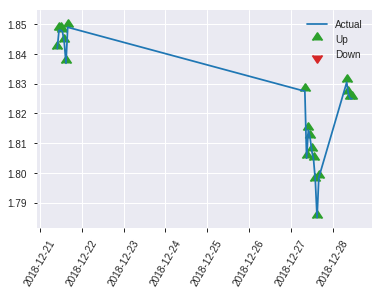


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25010418380839033
RMSE: 0.5001041729563855
LogLoss: 0.6934577480671541
Mean Per-Class Error: 0.4389920424403183
AUC: 0.5620026525198939
pr_auc: 0.53072197850774
Gini: 0.1240053050397878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34090283513069153: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    115  0.9914   (115.0/116.0)
1      0    104  0        (0.0/104.0)
Total  1    219  0.5227   (115.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340903     0.643963  218
max f2                       0.340903     0.818898  218
max f0point5                 0.490892     0.542582  155
max accuracy                 0.581064     0.572727  37
max precision                0.717023     1         0
max recall                   0.340903     1         218
max specificity              0.717023     1         0
max absolute_mcc             0.581064     0.145387  37
max min_per_class_accuracy   0.526992     0.538462  108
max mean_per_class_accuracy  0.522005     0.561008  116

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.707963           1.41026   1.41026            0.666667         0.714188  0.666667                    0.714188            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.689151           1.05769   1.26923            0.5              0.694228  0.6                         0.706204            0.00961538      0.0288462                  5.76923   26.9231
    3        0.0318182                   0.669356           1.05769   1.20879            0.5              0.679182  0.571429                    0.698483            0.00961538      0.0384615                  5.76923   20.8791
    4        0.0409091                   0.656754           1.05769   1.17521            0.5              0.664818  0.555556                    0.691002            0.00961538      0.0480769                  5.76923   17.5214
    5        0.05                        0.641793           1.05769   1.15385            0.5              0.652313  0.545455                    0.683968            0.00961538      0.0576923                  5.76923   15.3846
    6        0.1                         0.608408           1.53846   1.34615            0.727273         0.622715  0.636364                    0.653341            0.0769231       0.134615                   53.8462   34.6154
    7        0.15                        0.58682            1.15385   1.28205            0.545455         0.596841  0.606061                    0.634508            0.0576923       0.192308                   15.3846   28.2051
    8        0.2                         0.57375            0.961538  1.20192            0.454545         0.580002  0.568182                    0.620881            0.0480769       0.240385                   -3.84615  20.1923
    9        0.3                         0.560147           1.05769   1.15385            0.5              0.566963  0.545455                    0.602909            0.105769        0.346154                   5.76923   15.3846
    10       0.4                         0.541399           1.05769   1.12981            0.5              0.553539  0.534091                    0.590566            0.105769        0.451923                   5.76923   12.9808
    11       0.5                         0.525755           0.865385  1.07692            0.409091         0.533085  0.509091                    0.57907             0.0865385       0.538462                   -13.4615  7.69231
    12       0.6                         0.509729           1.05769   1.07372            0.5              0.518766  0.507576                    0.569019            0.105769        0.644231                   5.76923   7.37179
    13       0.7                         0.492629           0.961538  1.05769            0.454545         0.502673  0.5                         0.559541            0.0961538       0.740385                   -3.84615  5.76923
    14       0.8                         0.46861            0.480769  0.985577           0.227273         0.483067  0.465909                    0.549982            0.0480769       0.788462                   -51.9231  -1.44231
    15       0.9                         0.427381           1.05769   0.99359            0.5              0.452119  0.469697                    0.539108            0.105769        0.894231                   5.76923   -0.641026
    16       1                           0.306439           1.05769   1                  0.5              0.380793  0.472727                    0.523277      

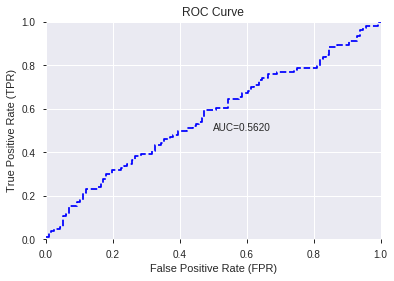

This function is available for GLM models only


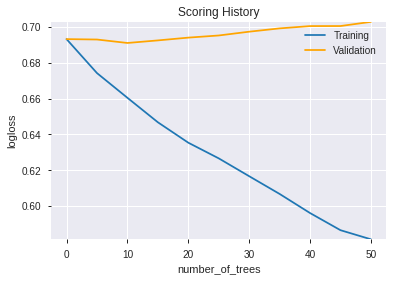

--2019-08-28 12:42:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.83.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.83.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_124217_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_124217_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_inphase',
 'OBV',
 'CORREL_20',
 'CORREL_24',
 'AROONOSC_24',
 'CORREL_8',
 'BETA_14',
 'SUB',
 'BOP',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'DIV',
 'ADXR_14',
 'MFI_12',
 'MACDFIX_hist_14',
 'MACDFIX_hist_8',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_upperband_20_7_5',
 'aroonup_20',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_upperband_20_7_2',
 'ROCP_8',
 'BBANDS_lowerband_24_5_5',
 'MAVP_30_6',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_7_4',
 'aroondown_24',
 'BBANDS_upperband_14_3_2',
 'AROONOSC_8',
 'BBANDS_middleband_14_1_5',
 'BBANDS_middleband_14_3_4',
 'MINMAX_max_14',
 'MAX_8',
 'BBANDS_lowerband_14_4_2',
 'dayofweek',
 'weekday_name',
 'WCLPRICE',
 'days_in_month']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 891 926] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_124245  0.573607  0.900700              0.470325  0.534756  0.285964
1  DeepLearning_grid_1_AutoML_20190828_124245_model_7  0.543808  0.777958              0.491877  0.536428  0.287755
2  DeepLearning_grid_1_AutoML_20190828_124245_model_3  0.539788  0.735237              0.495690  0.519179  0.269547
3  DeepLearning_grid_1_AutoML_20190828_124245_model_4  0.532245  1.394177              0.500000  0.623737  0.389048
4  DeepLearning_grid_1_AutoML_20190828_124245_model_5  0.518899  0.757576              0.500000  0.519818  0.270210
5  DeepLearning_grid_1_AutoML_20190828_124245_model_2  0.515003  0.788655              0.491379  0.539320  0.290866
6  DeepLearning_grid_1_AutoML_20190828_124245_model_9  0.500000  0.704114              0.500000  0.505430  0.255459
7  DeepLearning_grid_1_AutoML_20190828_124245_model_8  0.500000  0.702842              0.500000  0.504806  0.254830
8  DeepLearning_grid_1_AutoML_20190828_124245_model_6  0.498591  0.702912              0.495690  0.504842  0.254865
9  DeepLearning_grid_1_AutoML_20190828_124245_model_1  0.451882  3.251332              0.487566  0.676623  0.457818

variable  relative_importance  scaled_importance  percentage
0               days_in_month             1.000000           1.000000    0.001993
1             CDLHOMINGPIGEON             0.982068           0.982068    0.001957
2         CDLRISEFALL3METHODS             0.939825           0.939825    0.001873
3                       ADOSC             0.938403           0.938403    0.001870
4         CDLGAPSIDESIDEWHITE             0.928813           0.928813    0.001851
...                       ...                  ...                ...         ...
1031             aroondown_20             0.222037           0.222037    0.000442
1032   BBANDS_lowerband_8_1_3             0.216172           0.216172    0.000431
1033  BBANDS_lowerband_14_7_5             0.210343           0.210343    0.000419
1034                   ADX_14             0.209262           0.209262    0.000417
1035  BBANDS_middleband_8_6_3             0.197022           0.197022    0.000393

[1036 rows x 4 columns]

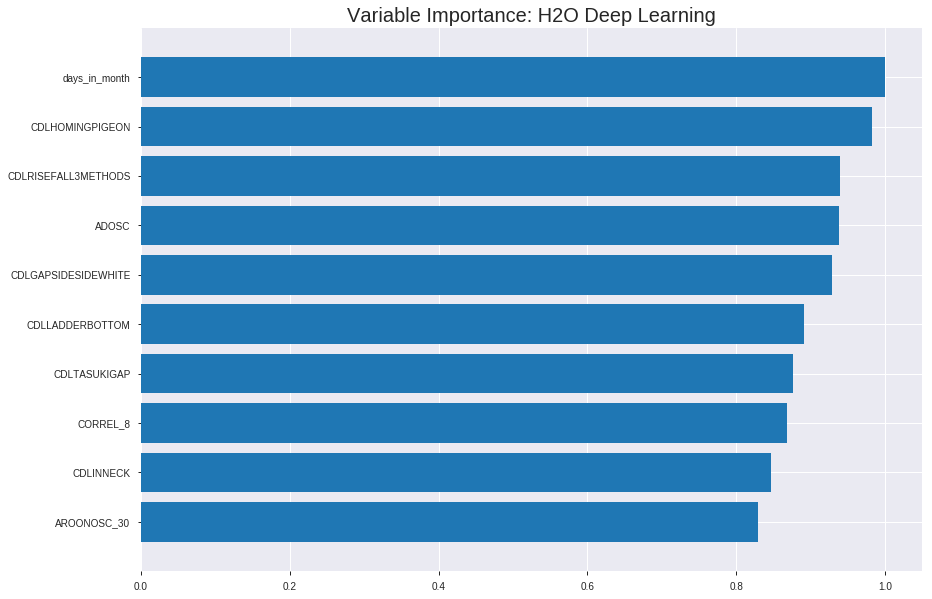

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_124245


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2375842988788655
RMSE: 0.48742619839198786
LogLoss: 0.6679821000013972
Mean Per-Class Error: 0.42729362161868334
AUC: 0.6107476778397625
pr_auc: 0.6349697080819415
Gini: 0.22149535567952494
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2650032505315609: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      44   704   0.9412   (704.0/748.0)
1      11   776   0.014    (11.0/787.0)
Total  55   1480  0.4658   (715.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265003     0.684605  352
max f2                       0.0317812    0.841171  395
max f0point5                 0.487317     0.595259  234
max accuracy                 0.487317     0.570684  234
max precision                1            1         0
max recall                   0.0317812    1         395
max specificity              1            1         0
max absolute_mcc             0.572887     0.185     131
max min_per_class_accuracy   0.493252     0.47014   227
max mean_per_class_accuracy  0.532784     0.572706  177

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.982502           1.95044   1.95044            1                0.996105  1                           0.996105            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.905011           1.82042   1.88753            0.933333         0.947577  0.967742                    0.972624            0.0177891       0.0381194                  82.0415   88.7527
    3        0.0306189                   0.861472           1.58474   1.78445            0.8125           0.885638  0.914894                    0.943012            0.0165184       0.0546379                  58.4736   78.4449
    4        0.0403909                   0.789986           1.3003    1.66732            0.666667         0.832369  0.854839                    0.916244            0.0127065       0.0673443                  30.0296   66.7316
    5        0.0501629                   0.725067           1.56036   1.64648            0.8              0.754206  0.844156                    0.884678            0.0152478       0.0825921                  56.0356   64.6479
    6        0.100326                    0.609153           1.36784   1.50716            0.701299         0.648659  0.772727                    0.766668            0.068615        0.151207                   36.7844   50.7162
    7        0.150489                    0.574903           1.21586   1.41006            0.623377         0.590149  0.722944                    0.707828            0.0609911       0.212198                   21.5862   41.0062
    8        0.2                         0.553842           1.1292    1.34053            0.578947         0.563955  0.687296                    0.672212            0.0559085       0.268107                   12.9205   34.0534
    9        0.300326                    0.521408           0.962557  1.21427            0.493506         0.537605  0.62256                     0.627245            0.0965693       0.364676                   -3.74429  21.4268
    10       0.4                         0.494378           1.01984   1.16582            0.522876         0.507375  0.59772                     0.597375            0.101652        0.466328                   1.98404   16.582
    11       0.796743                    0.492409           0.980026  1.0733             0.502463         0.492425  0.550286                    0.545115            0.388818        0.855146                   -1.99736  7.33028
    12       0.8                         0.490974           1.17027   1.0737             0.6              0.491613  0.550489                    0.544897            0.00381194      0.858958                   17.0267   7.36976
    13       0.899674                    0.403013           0.790376  1.04231            0.405229         0.457366  0.534395                    0.535199            0.0787802       0.937738                   -20.9624  4.23086
    14       1                           0.00402746         0.620596  1                  0.318182         0.27594   0.512704                    0.509189            0.0622618       1                          -37.9404  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2536650169977445
RMSE: 0.503651682214747
LogLoss: 0.7229085096963282
Mean Per-Class Error: 0.4695852728689681
AUC: 0.5088569201929355
pr_auc: 0.6197712592401208
Gini: 0.017713840385870983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18162413526348967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    189  0.9594   (189.0/197.0)
1      3    238  0.0124   (3.0/241.0)
Total  11   427  0.4384   (192.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.181624     0.712575   54
max f2                       0.0294325    0.859486   65
max f0point5                 0.181624     0.61057    54
max accuracy                 0.241908     0.561644   50
max precision                0.625615     0.875      7
max recall                   0.0294325    1          65
max specificity              0.999945     0.994924   0
max absolute_mcc             0.498668     0.123704   27
max min_per_class_accuracy   0.498668     0.0912863  27
max mean_per_class_accuracy  0.498668     0.530415   27

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0114155                   0.804809           1.45394   1.45394            0.8              0.959645  0.8                         0.959645            0.0165975       0.0165975                  45.3942  45.3942
    2        0.0205479                   0.557685           1.36307   1.41355            0.75             0.64939   0.777778                    0.821754            0.0124481       0.0290456                  36.3071  41.3555
    3        0.0319635                   0.514908           1.09046   1.29816            0.6              0.529097  0.714286                    0.717233            0.0124481       0.0414938                  9.04564  29.8162
    4        0.0410959                   0.512504           1.36307   1.31259            0.75             0.514159  0.722222                    0.672106            0.0124481       0.0539419                  36.3071  31.2586
    5        0.0502283                   0.503402           1.81743   1.40438            1                0.50788   0.772727                    0.642247            0.0165975       0.0705394                  81.7427  40.4376
    6        0.924658                    0.492409           0.963284  0.987245           0.530026         0.492567  0.54321                     0.500698            0.842324        0.912863                   -3.6716  -1.27555
    7        1                           0.0294325          1.15654   1                  0.636364         0.26713   0.550228                    0.4831              0.0871369       1                          15.6545  0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:42:46  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:42:47  0.878 sec   8480 obs/sec      1         1             1535       0.568523         1.03012             -0.293707      0.525313        0.521466           1.34093          0.485342                         0.587464           1.02114               -0.394531        0.510342          0.572351             1.09046            0.445205
    2019-08-28 12:42:48  2.265 sec   10470 obs/sec     10        10            15350      0.487426         0.667982            0.0490489      0.610748        0.63497            1.95044          0.465798                         0.503652           0.722909              -0.0250039       0.508857          0.619771             1.45394            0.438356

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ----------------------
days_in_month            1.0                    1.0                  0.001992584809216978
CDLHOMINGPIGEON          0.9820675849914551     0.9820675849914551   0.001956852951478377
CDLRISEFALL3METHODS      0.9398253560066223     0.9398253560066223   0.001872681727695734
ADOSC                    0.9384027719497681     0.9384027719497681   0.0018698471083142118
CDLGAPSIDESIDEWHITE      0.9288133382797241     0.9288133382797241   0.0018507393484542883
---                      ---                    ---                  ---
aroondown_20             0.22203680872917175    0.22203680872917175  0.0004424271721607633
BBANDS_lowerband_8_1_3   0.21617192029953003    0.21617192029953003  0.0004307408845681068
BBANDS_lowerband_14_7_5  0.21034324169158936    0.21034324169158936  0.00041912674811611623
ADX_14                   0.2092621773481369     0.2092621773481369   0.00041697263572756677
BBANDS_middleband_8_6_3  0.19702236354351044    0.19702236354351044  0.0003925837686728238


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5909090909090909)

('F1', 0.6539682539682539)

('auc', 0.5736074270557029)

('logloss', 0.9007004633537384)

('mean_per_class_error', 0.41876657824933683)

('rmse', 0.5347557042653267)

('mse', 0.2859636632443056)

deeplearning prediction progress: |███████████████████████████████████████| 100%


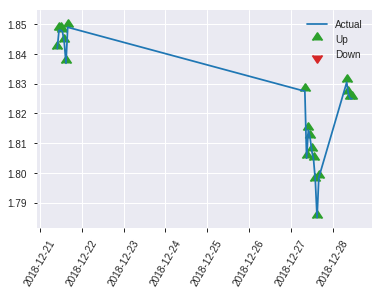


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2859636632443056
RMSE: 0.5347557042653267
LogLoss: 0.9007004633537384
Mean Per-Class Error: 0.41876657824933683
AUC: 0.5736074270557029
pr_auc: 0.5686408565460707
Gini: 0.14721485411140578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45627134834388955: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    108  0.931    (108.0/116.0)
1      1    103  0.0096   (1.0/104.0)
Total  9    211  0.4955   (109.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456271     0.653968  140
max f2                       0.43102      0.822785  145
max f0point5                 0.675818     0.546875  69
max accuracy                 0.675818     0.590909  69
max precision                0.999965     1         0
max recall                   0.43102      1         145
max specificity              0.999965     1         0
max absolute_mcc             0.991989     0.177319  14
max min_per_class_accuracy   0.55283      0.538462  107
max mean_per_class_accuracy  0.675818     0.581233  69

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 64.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.999896           2.11538   2.11538            1                0.99994   1                           0.99994             0.0288462       0.0288462                  111.538   111.538
    2        0.0227273                   0.999811           1.05769   1.69231            0.5              0.999873  0.8                         0.999913            0.00961538      0.0384615                  5.76923   69.2308
    3        0.0318182                   0.999373           2.11538   1.81319            1                0.999705  0.857143                    0.999854            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.998167           2.11538   1.88034            1                0.999127  0.888889                    0.999692            0.0192308       0.0769231                  111.538   88.0342
    5        0.05                        0.997393           1.05769   1.73077            0.5              0.997639  0.818182                    0.999319            0.00961538      0.0865385                  5.76923   73.0769
    6        0.1                         0.977212           1.15385   1.44231            0.545455         0.987824  0.681818                    0.993571            0.0576923       0.144231                   15.3846   44.2308
    7        0.15                        0.947383           1.34615   1.41026            0.636364         0.963107  0.666667                    0.983417            0.0673077       0.211538                   34.6154   41.0256
    8        0.2                         0.901173           0.961538  1.29808            0.454545         0.932183  0.613636                    0.970608            0.0480769       0.259615                   -3.84615  29.8077
    9        0.3                         0.692742           1.15385   1.25               0.545455         0.801506  0.590909                    0.914241            0.115385        0.375                      15.3846   25
    10       0.4                         0.597178           0.961538  1.17788            0.454545         0.647341  0.556818                    0.847516            0.0961538       0.471154                   -3.84615  17.7885
    11       0.5                         0.539497           0.673077  1.07692            0.318182         0.5714    0.509091                    0.792293            0.0673077       0.538462                   -32.6923  7.69231
    12       0.6                         0.495963           0.865385  1.04167            0.409091         0.511376  0.492424                    0.745473            0.0865385       0.625                      -13.4615  4.16667
    13       0.931818                    0.492409           0.985248  1.02158            0.465753         0.492441  0.482927                    0.655369            0.326923        0.951923                   -1.47524  2.1576
    14       1                           0.407106           0.705128  1                  0.333333         0.450017  0.472727                    0.641368            0.0480769       1                          -29.4872  0

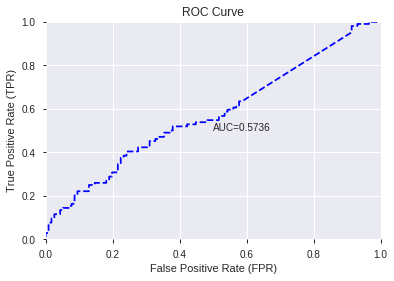

This function is available for GLM models only


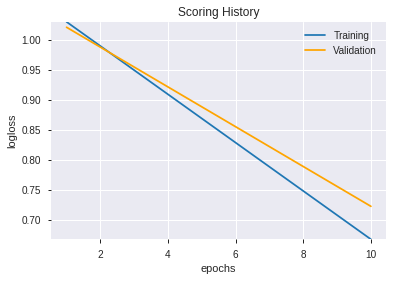

--2019-08-28 13:07:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_124245',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_124245',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_be75'

['days_in_month',
 'CDLHOMINGPIGEON',
 'CDLRISEFALL3METHODS',
 'ADOSC',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'CDLTASUKIGAP',
 'CORREL_8',
 'CDLINNECK',
 'AROONOSC_30',
 'AD',
 'ADX_24',
 'quarter',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'BOP',
 'NATR_14',
 'MAX_30',
 'aroondown_12',
 'BETA_24',
 'BBANDS_upperband_20_3_5',
 'HT_DCPERIOD',
 'BBANDS_middleband_14_5_5',
 'TYPPRICE',
 'BBANDS_upperband_20_2_2',
 'DX_12',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_upperband_20_7_2',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_upperband_24_2_5',
 'DX_8',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_14_5_3',
 'BBANDS_middleband_20_0_2',
 'HT_TRENDMODE',
 'AROONOSC_12',
 'day',
 'BBANDS_middleband_30_1_3',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_8_0_2',
 'ATR_8',
 'FLOOR',
 'BETA_14',
 'BBANDS_lowerband_24_7_3',
 'MA_20_5',
 'aroondown_8',
 'CDL3OUTSIDE',
 'MIN_24',
 'STOCHRSI_fastk',
 'BBANDS_upperband_20_2_5',
 

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_130732_model_1  0.507875  0.695286              0.491379  0.50107  0.251071

variable  relative_importance  scaled_importance    percentage
0                         hour         7.215365e-03       1.000000e+00  1.138211e-02
1               STOCHRSI_fastk         6.908468e-03       9.574663e-01  1.089798e-02
2                  CDLBELTHOLD         6.838350e-03       9.477484e-01  1.078737e-02
3                          BOP         6.725159e-03       9.320609e-01  1.060882e-02
4               CDLMATCHINGLOW         6.514695e-03       9.028921e-01  1.027681e-02
...                        ...                  ...                ...           ...
1031                   MA_20_7         3.952442e-07       5.477813e-05  6.234905e-07
1032  BBANDS_middleband_30_6_4         1.485446e-07       2.058727e-05  2.343264e-07
1033                    SUM_24         9.798885e-08       1.358058e-05  1.545756e-07
1034                   MA_30_7         1.785077e-10       2.473994e-08  2.815926e-10
1035                       ADD         0.000000e+00       0.000000e+00  0.000000e+00

[1036 rows x 4 columns]

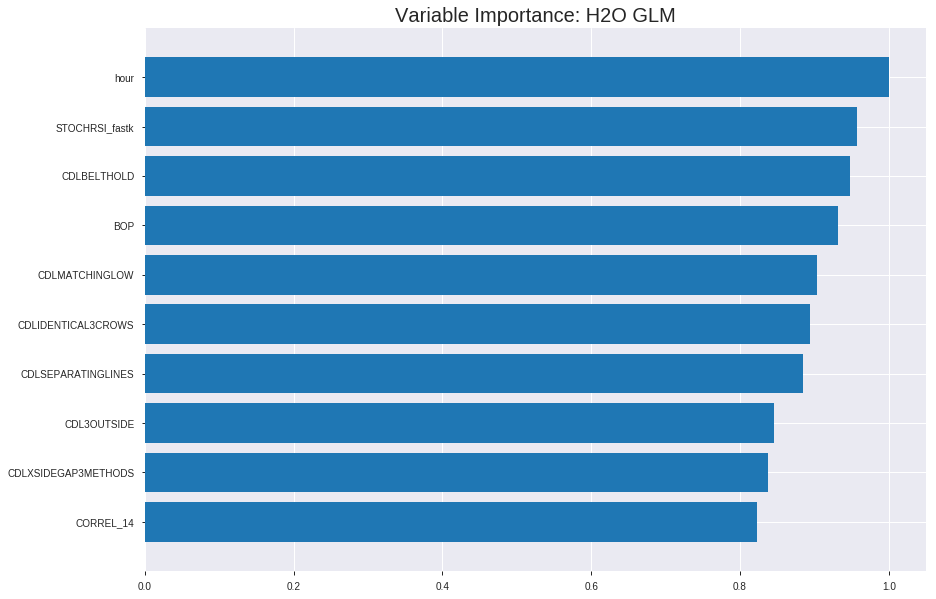

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_130732_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24733684915235288
RMSE: 0.49732971875040094
LogLoss: 0.6878052415671114
Null degrees of freedom: 1534
Residual degrees of freedom: 499
Null deviance: 2126.970858206576
Residual deviance: 2111.562091611032
AIC: 4183.562091611032
AUC: 0.5846017163940775
pr_auc: 0.5927521397802473
Gini: 0.16920343278815508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4801019100945452: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   717   0.9586   (717.0/748.0)
1      11   776   0.014    (11.0/787.0)
Total  42   1493  0.4743   (728.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480102     0.680702  370
max f2                       0.463413     0.841171  394
max f0point5                 0.496498     0.583319  306
max accuracy                 0.509558     0.566124  223
max precision                0.591946     1         0
max recall                   0.463413     1         394
max specificity              0.591946     1         0
max absolute_mcc             0.516752     0.136645  177
max min_per_class_accuracy   0.512047     0.559085  208
max mean_per_class_accuracy  0.515586     0.567461  184

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.565392           1.70664   1.70664            0.875            0.576036  0.875                       0.576036            0.0177891       0.0177891                  70.6639   70.6639
    2        0.0201954                   0.557985           1.17027   1.4471             0.6              0.561475  0.741935                    0.56899             0.0114358       0.0292249                  17.0267   44.7104
    3        0.0306189                   0.551771           1.46283   1.45246            0.75             0.553965  0.744681                    0.563875            0.0152478       0.0444727                  46.2834   45.2459
    4        0.0403909                   0.545965           0.780178  1.28981            0.4              0.548307  0.66129                     0.560109            0.00762389      0.0520966                  -21.9822  28.981
    5        0.0501629                   0.54231            1.3003    1.29185            0.666667         0.544261  0.662338                    0.557022            0.0127065       0.064803                   30.0296   29.1853
    6        0.100326                    0.534432           1.1652    1.22853            0.597403         0.537988  0.62987                     0.547505            0.0584498       0.123253                   16.5201   22.8527
    7        0.150489                    0.529472           1.19053   1.21586            0.61039          0.531554  0.623377                    0.542188            0.0597205       0.182973                   19.0531   21.5862
    8        0.2                         0.526097           1.18053   1.20712            0.605263         0.527913  0.618893                    0.538654            0.0584498       0.241423                   18.0532   20.7116
    9        0.300326                    0.520995           1.1652    1.19311            0.597403         0.523268  0.611714                    0.533514            0.1169          0.358323                   16.5201   19.3114
    10       0.4                         0.516507           1.07083   1.16264            0.54902          0.518888  0.596091                    0.52987             0.106734        0.465057                   7.08324   16.2643
    11       0.500326                    0.51202            0.937227  1.11744            0.480519         0.514185  0.572917                    0.526724            0.094028        0.559085                   -6.27733  11.7442
    12       0.6                         0.507855           0.9561    1.09064            0.490196         0.509859  0.559175                    0.523923            0.0952986       0.654384                   -4.38996  9.06396
    13       0.699674                    0.503045           0.943352  1.06966            0.48366          0.505587  0.548417                    0.521311            0.094028        0.748412                   -5.66476  6.96573
    14       0.8                         0.498281           0.924561  1.05146            0.474026         0.500559  0.539088                    0.518708            0.0927573       0.841169                   -7.54385  5.14612
    15       0.899674                    0.491373           0.803124  1.02395            0.411765         0.49484   0.524982                    0.516064            0.0800508       0.92122                    -19.6876  2.39482
    16       1                           0.432057           0.785244  1                  0.402597         0.48257   0.512704                    0.512704          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24967519066032634
RMSE: 0.499675085090628
LogLoss: 0.692500790580265
Null degrees of freedom: 437
Residual degrees of freedom: -598
Null deviance: 605.243449119525
Residual deviance: 606.6306925483121
AIC: 2678.6306925483123
AUC: 0.487204330517935
pr_auc: 0.5446164851055341
Gini: -0.025591338964130017
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4694395342848814: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46944      0.710914  398
max f2                       0.46944      0.8601    398
max f0point5                 0.46944      0.605832  398
max accuracy                 0.46944      0.552511  398
max precision                0.552215     0.666667  2
max recall                   0.46944      1         398
max specificity              0.590864     0.994924  0
max absolute_mcc             0.485986     0.110397  382
max min_per_class_accuracy   0.510609     0.477157  202
max mean_per_class_accuracy  0.532378     0.519336  34

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.543775           0.726971  0.726971           0.4              0.558177  0.4                         0.558177            0.00829876      0.00829876                 -27.3029   -27.3029
    2        0.0205479                   0.541373           0         0.403873           0                0.542487  0.222222                    0.551204            0               0.00829876                 -100       -59.6127
    3        0.0319635                   0.540487           1.81743   0.908714           1                0.540898  0.5                         0.547523            0.0207469       0.0290456                  81.7427    -9.12863
    4        0.0410959                   0.53846            1.36307   1.00968            0.75             0.539493  0.555556                    0.545738            0.0124481       0.0414938                  36.3071    0.968188
    5        0.0502283                   0.536183           0.454357  0.908714           0.25             0.537626  0.5                         0.544264            0.00414938      0.0456432                  -54.5643   -9.12863
    6        0.100457                    0.53069            1.32177   1.11524            0.727273         0.533314  0.613636                    0.538789            0.06639         0.112033                   32.1765    11.524
    7        0.150685                    0.526888           0.826103  1.01886            0.454545         0.529098  0.560606                    0.535558            0.0414938       0.153527                   -17.3897   1.88608
    8        0.200913                    0.524371           0.991324  1.01198            0.545455         0.525677  0.556818                    0.533088            0.0497925       0.20332                    -0.867597  1.19766
    9        0.30137                     0.518545           1.07393   1.03263            0.590909         0.521132  0.568182                    0.529103            0.107884        0.311203                   7.39344    3.26292
    10       0.399543                    0.514253           0.676252  0.945062           0.372093         0.516549  0.52                        0.526018            0.06639         0.377593                   -32.3748   -5.49378
    11       0.5                         0.510378           0.991324  0.954357           0.545455         0.512141  0.525114                    0.52323             0.0995851       0.477178                   -0.867597  -4.56432
    12       0.600457                    0.50729            1.11524   0.981273           0.613636         0.508974  0.539924                    0.520845            0.112033        0.589212                   11.524     -1.87274
    13       0.69863                     0.503355           0.972112  0.979985           0.534884         0.50545   0.539216                    0.518682            0.0954357       0.684647                   -2.78877   -2.00146
    14       0.799087                    0.499144           1.07393   0.991796           0.590909         0.501239  0.545714                    0.516489            0.107884        0.792531                   7.39344    -0.820391
    15       0.899543                    0.493728           1.03263   0.996356           0.568182         0.496433  0.548223                    0.514249            0.103734        0.896266                   3.26292    -0.364387
    16       1                           0.467169           1.03263   1                  0.568182         0.485736  0.550228        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:07:35  0.000 sec   2            3         1036          1.37561           1.385
    2019-08-28 13:07:37  1.930 sec   4            2.2       1037          1.3731            1.38591
    2019-08-28 13:07:39  3.918 sec   6            1.6       1037          1.37016           1.38725
    2019-08-28 13:07:41  5.988 sec   8            1.2       1037          1.36678           1.38917
    2019-08-28 13:07:43  7.942 sec   10           0.84      1037          1.36298           1.39183

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6459627329192547)

('auc', 0.5078746684350133)

('logloss', 0.6952860461865351)

('mean_per_class_error', 0.45905172413793105)

('rmse', 0.5010700421430833)

('mse', 0.25107118713327126)

glm prediction progress: |████████████████████████████████████████████████| 100%


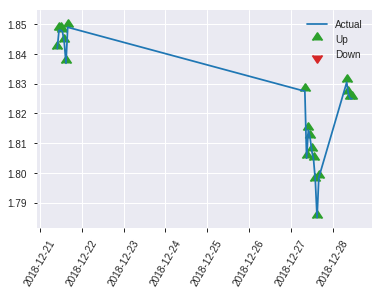


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25107118713327126
RMSE: 0.5010700421430833
LogLoss: 0.6952860461865351
Null degrees of freedom: 219
Residual degrees of freedom: -816
Null deviance: 305.73672384847293
Residual deviance: 305.92586032207544
AIC: 2377.9258603220756
AUC: 0.5078746684350133
pr_auc: 0.5088613582311797
Gini: 0.015749336870026553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4891560473876949: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    114  0.9828   (114.0/116.0)
1      0    104  0        (0.0/104.0)
Total  2    218  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489156     0.645963  217
max f2                       0.489156     0.820189  217
max f0point5                 0.506283     0.545455  193
max accuracy                 0.547236     0.563636  11
max precision                0.574488     1         0
max recall                   0.489156     1         217
max specificity              0.574488     1         0
max absolute_mcc             0.547236     0.173488  11
max min_per_class_accuracy   0.522591     0.509615  107
max mean_per_class_accuracy  0.541931     0.540948  17

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.562494           1.41026   1.41026            0.666667         0.567363  0.666667                    0.567363            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.556831           2.11538   1.69231            1                0.55728   0.8                         0.56333             0.0192308       0.0384615                  111.538   69.2308
    3        0.0318182                   0.551973           2.11538   1.81319            1                0.555432  0.857143                    0.561073            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.548981           2.11538   1.88034            1                0.54968   0.888889                    0.558541            0.0192308       0.0769231                  111.538   88.0342
    5        0.05                        0.547247           1.05769   1.73077            0.5              0.548169  0.818182                    0.556655            0.00961538      0.0865385                  5.76923   73.0769
    6        0.1                         0.541151           0.769231  1.25               0.363636         0.543239  0.590909                    0.549947            0.0384615       0.125                      -23.0769  25
    7        0.15                        0.537731           0.576923  1.02564            0.272727         0.539673  0.484848                    0.546523            0.0288462       0.153846                   -42.3077  2.5641
    8        0.2                         0.535347           0.961538  1.00962            0.454545         0.536947  0.477273                    0.544129            0.0480769       0.201923                   -3.84615  0.961538
    9        0.3                         0.529359           0.961538  0.99359            0.454545         0.532234  0.469697                    0.540164            0.0961538       0.298077                   -3.84615  -0.641026
    10       0.4                         0.525271           0.865385  0.961538           0.409091         0.526775  0.454545                    0.536816            0.0865385       0.384615                   -13.4615  -3.84615
    11       0.5                         0.52235            1.25      1.01923            0.590909         0.523876  0.481818                    0.534228            0.125           0.509615                   25        1.92308
    12       0.6                         0.518991           0.673077  0.961538           0.318182         0.520903  0.454545                    0.532008            0.0673077       0.576923                   -32.6923  -3.84615
    13       0.7                         0.51563            1.05769   0.975275           0.5              0.517137  0.461039                    0.529883            0.105769        0.682692                   5.76923   -2.47253
    14       0.8                         0.511092           1.25      1.00962            0.590909         0.513228  0.477273                    0.527801            0.125           0.807692                   25        0.961538
    15       0.9                         0.505103           1.25      1.03632            0.590909         0.508503  0.489899                    0.525657            0.125           0.932692                   25        3.63248
    16       1                           0.486671           0.673077  1                  0.318182         0.496803  0.472727                    0.522772        

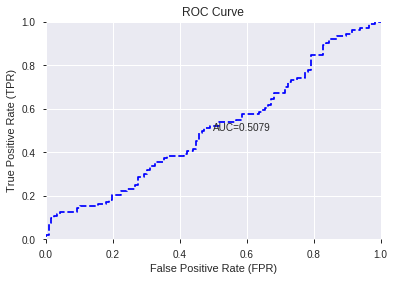

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


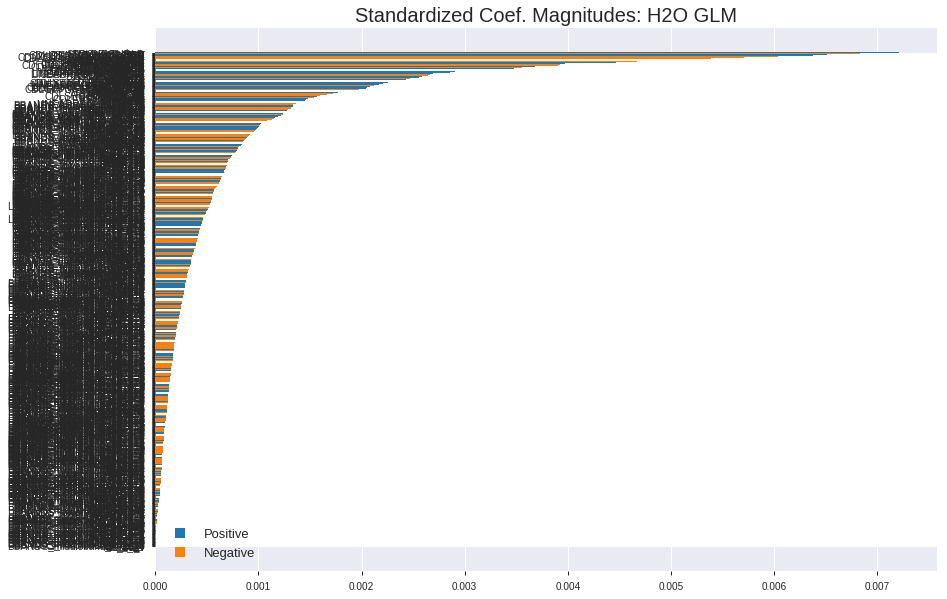

'log_likelihood'
--2019-08-28 13:08:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_130732_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_130732_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['hour',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'BOP',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLSEPARATINGLINES',
 'CDL3OUTSIDE',
 'CDLXSIDEGAP3METHODS',
 'CORREL_14',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'AD',
 'days_in_month',
 'CDLHAMMER',
 'CDLHIKKAKEMOD',
 'CDLLONGLINE',
 'OBV',
 'HT_TRENDMODE',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'HT_PHASOR_inphase',
 'CDLLADDERBOTTOM',
 'VAR_30',
 'MFI_20',
 'CDLRISEFALL3METHODS',
 'CDL3LINESTRIKE',
 'CDLTASUKIGAP',
 'STOCHF_fastk',
 'CDLEVENINGDOJISTAR',
 'CCI_8',
 'CDLONNECK',
 'CDLINNECK',
 'CDLHOMINGPIGEON',
 'CORREL_8',
 'aroondown_14',
 'weekday_name',
 'CDLADVANCEBLOCK',
 'CDLHARAMICROSS',
 'MFI_14',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'quarter',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'WILLR_8',
 'MFI_8',
 'MOM_8',
 'CCI_14',
 'VAR_24',
 'STDDEV_30',
 'CCI_12',
 'aroonup_12',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CDLHIGHWAVE',
 'CORREL_12',
 'CDLINVERTEDHAMMER',
 '

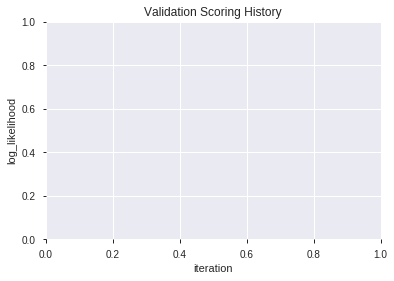

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_130817_model_7  0.527934  0.724266              0.491379  0.514463  0.264672
1  XGBoost_grid_1_AutoML_20190828_130817_model_2  0.523707  0.701990              0.491379  0.504269  0.254287
2  XGBoost_grid_1_AutoML_20190828_130817_model_3  0.523044  0.724411              0.487069  0.514708  0.264924
3               XGBoost_2_AutoML_20190828_130817  0.521883  0.713608              0.487069  0.509834  0.259931
4  XGBoost_grid_1_AutoML_20190828_130817_model_5  0.521137  0.747453              0.484251  0.523242  0.273783
5  XGBoost_grid_1_AutoML_20190828_130817_model_6  0.511273  0.718288              0.500000  0.512249  0.262399
6  XGBoost_grid_1_AutoML_20190828_130817_model_4  0.507626  0.702078              0.488064  0.504370  0.254389
7               XGBoost_1_AutoML_20190828_130817  0.496270  0.741596              0.495690  0.522259  0.272754
8               XGBoost_3_AutoML_20190828_130817  0.493534  0.719391              0.500000  0.512577  0.262735
9  XGBoost_grid_1_AutoML_20190828_130817_model_1  0.493369  0.718958              0.479940  0.512113  0.262260

variable  relative_importance  scaled_importance  percentage
0                        BOP           171.949249           1.000000    0.019913
1          HT_PHASOR_inphase           140.728226           0.818429    0.016297
2             STOCHRSI_fastd           130.555466           0.759267    0.015119
3                      ADOSC           128.522110           0.747442    0.014883
4                       hour           127.741478           0.742902    0.014793
..                       ...                  ...                ...         ...
361  BBANDS_upperband_14_5_4             2.506950           0.014580    0.000290
362                  ROCP_12             2.173074           0.012638    0.000252
363                     mama             1.735502           0.010093    0.000201
364   BBANDS_upperband_8_5_2             1.633044           0.009497    0.000189
365               aroonup_14             0.497116           0.002891    0.000058

[366 rows x 4 columns]

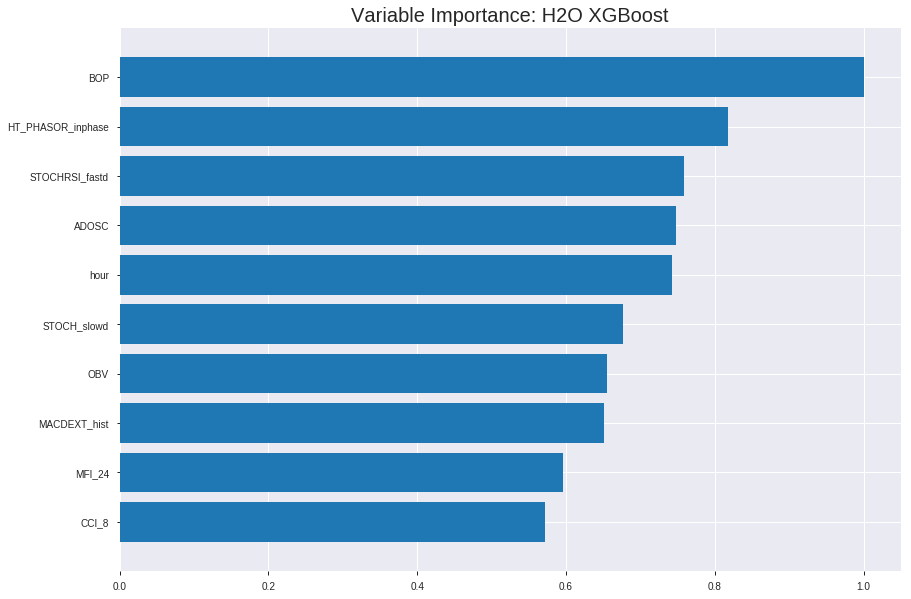

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_130817_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1320067568298459
RMSE: 0.3633273411537396
LogLoss: 0.4443101957212584
Mean Per-Class Error: 0.059774816707322875
AUC: 0.9867524750456957
pr_auc: 0.9866778852194864
Gini: 0.9735049500913915
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138948410749435: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      708  40   0.0535   (40.0/748.0)
1      52   735  0.0661   (52.0/787.0)
Total  760  775  0.0599   (92.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513895     0.941101  195
max f2                       0.46001      0.959194  225
max f0point5                 0.545765     0.957447  176
max accuracy                 0.513895     0.940065  195
max precision                0.870634     1         0
max recall                   0.339876     1         304
max specificity              0.870634     1         0
max absolute_mcc             0.513895     0.880208  195
max min_per_class_accuracy   0.510283     0.935829  198
max mean_per_class_accuracy  0.513895     0.940225  195

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.808515           1.95044    1.95044            1                0.835047  1                           0.835047            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.793949           1.95044    1.95044            1                0.800279  1                           0.818224            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.779736           1.95044    1.95044            1                0.786768  1                           0.807515            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.773264           1.95044    1.95044            1                0.776904  1                           0.800109            0.0190597       0.0787802                  95.0445   95.0445
    5        0.0501629                   0.767466           1.95044    1.95044            1                0.770221  1                           0.794287            0.0190597       0.0978399                  95.0445   95.0445
    6        0.100326                    0.736935           1.95044    1.95044            1                0.750548  1                           0.772418            0.0978399       0.19568                    95.0445   95.0445
    7        0.150489                    0.707915           1.95044    1.95044            1                0.722527  1                           0.755787            0.0978399       0.29352                    95.0445   95.0445
    8        0.2                         0.685333           1.95044    1.95044            1                0.697974  1                           0.741475            0.0965693       0.390089                   95.0445   95.0445
    9        0.300326                    0.63922            1.93778    1.94621            0.993506         0.663573  0.997831                    0.715452            0.194409        0.584498                   93.778    94.6214
    10       0.4                         0.585728           1.89945    1.93456            0.973856         0.613642  0.991857                    0.690082            0.189327        0.773825                   89.9453   93.4562
    11       0.500326                    0.515803           1.54516    1.85648            0.792208         0.55164   0.951823                    0.662322            0.155019        0.928844                   54.5158   85.6478
    12       0.6                         0.434465           0.57366    1.64337            0.294118         0.472958  0.842562                    0.630864            0.0571792       0.986023                   -42.634   64.3371
    13       0.699674                    0.378754           0.114732   1.4256             0.0588235        0.407955  0.730912                    0.599109            0.0114358       0.997459                   -88.5268  42.5604
    14       0.8                         0.332065           0.0253305  1.25               0.012987         0.353088  0.640879                    0.568256            0.0025413       1                          -97.467   25
    15       0.899674                    0.281389           0          1.11151            0                0.308105  0.569877                    0.539434            0               1                          -100      11.1513
    16       1                           0.141872           0          1                  0                0.245388  0.512704                    0.50



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26019415088034736
RMSE: 0.5100922964330548
LogLoss: 0.7154291544803425
Mean Per-Class Error: 0.47973755713292754
AUC: 0.48979505865998274
pr_auc: 0.5531047245590609
Gini: -0.02040988268003452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2853747010231018: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    197  1        (197.0/197.0)
1      0    241  0        (0.0/241.0)
Total  0    438  0.4498   (197.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.285375     0.709867   399
max f2                       0.285375     0.859486   399
max f0point5                 0.285375     0.604616   399
max accuracy                 0.310744     0.550228   397
max precision                0.722554     0.6875     31
max recall                   0.285375     1          399
max specificity              0.841259     0.994924   0
max absolute_mcc             0.722554     0.0774686  31
max min_per_class_accuracy   0.572489     0.502075   195
max mean_per_class_accuracy  0.722554     0.520262   31

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 56.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.787711           1.09046   1.09046            0.6              0.807338  0.6                         0.807338            0.0124481       0.0124481                  9.04564    9.04564
    2        0.0205479                   0.772641           0.908714  1.00968            0.5              0.78139   0.555556                    0.795806            0.00829876      0.0207469                  -9.12863   0.968188
    3        0.0319635                   0.756472           1.45394   1.16835            0.8              0.762933  0.642857                    0.784065            0.0165975       0.0373444                  45.3942    16.8346
    4        0.0410959                   0.748633           0.454357  1.00968            0.25             0.752681  0.555556                    0.777091            0.00414938      0.0414938                  -54.5643   0.968188
    5        0.0502283                   0.735625           1.81743   1.15654            1                0.74445   0.636364                    0.771156            0.0165975       0.0580913                  81.7427    15.6545
    6        0.100457                    0.700302           0.908714  1.03263            0.5              0.719522  0.568182                    0.745339            0.0456432       0.103734                   -9.12863   3.26292
    7        0.150685                    0.670514           1.07393   1.0464             0.590909         0.683702  0.575758                    0.724793            0.0539419       0.157676                   7.39344    4.63976
    8        0.200913                    0.653339           0.826103  0.991324           0.454545         0.661282  0.545455                    0.708916            0.0414938       0.19917                    -17.3897   -0.867597
    9        0.30137                     0.625963           0.908714  0.963787           0.5              0.638687  0.530303                    0.685506            0.0912863       0.290456                   -9.12863   -3.62127
    10       0.399543                    0.594003           1.14118   1.00737            0.627907         0.609123  0.554286                    0.666738            0.112033        0.40249                    14.1175    0.737404
    11       0.5                         0.570375           0.991324  1.00415            0.545455         0.583287  0.552511                    0.649971            0.0995851       0.502075                   -0.867597  0.414938
    12       0.600457                    0.540299           0.743493  0.960541           0.409091         0.554074  0.528517                    0.633928            0.0746888       0.576763                   -25.6507   -3.94585
    13       0.69863                     0.511096           1.09891   0.979985           0.604651         0.526857  0.539216                    0.618882            0.107884        0.684647                   9.89096    -2.00146
    14       0.799087                    0.470617           1.19785   1.00737            0.659091         0.492328  0.554286                    0.602972            0.120332        0.804979                   19.785     0.737404
    15       0.899543                    0.419135           0.826103  0.987131           0.454545         0.448489  0.543147                    0.58572             0.0829876       0.887967                   -17.3897   -1.28694
    16       1                           0.285375           1.11524   1                  0.613636         0.381503  0.550228         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:09:02  28.882 sec  0                  0.5              0.693147            0.5             0                  1                0.487296                         0.5                0.693147              0.5               0                    1                  0.449772
    2019-08-28 13:09:03  30.066 sec  5                  0.483588         0.66076             0.812605        0.814424           1.95044          0.280782                         0.499922           0.69298               0.483782          0.553294             1.45394            0.440639
    2019-08-28 13:09:03  30.344 sec  10                 0.465112         0.625263            0.891545        0.897108           1.95044          0.18241                          0.500297           0.693718              0.486878          0.562824             1.45394            0.449772
    2019-08-28 13:09:04  30.605 sec  15                 0.450782         0.598305            0.916338        0.919694           1.95044          0.166775                         0.502473           0.698165              0.480822          0.552304             1.09046            0.447489
    2019-08-28 13:09:04  30.887 sec  20                 0.435178         0.569563            0.940249        0.942863           1.95044          0.141368                         0.503612           0.700582              0.482002          0.55085              1.45394            0.449772
    2019-08-28 13:09:04  31.184 sec  25                 0.420177         0.542527            0.9584          0.960659           1.95044          0.110749                         0.504499           0.702492              0.482813          0.552447             1.45394            0.449772
    2019-08-28 13:09:04  31.458 sec  30                 0.407717         0.520351            0.965699        0.967539           1.95044          0.0983713                        0.505812           0.705399              0.483002          0.552808             0.726971           0.449772
    2019-08-28 13:09:05  31.745 sec  35                 0.394994         0.498058            0.972279        0.973986           1.95044          0.086645                         0.506933           0.708065              0.489016          0.556001             0.726971           0.449772
    2019-08-28 13:09:05  32.023 sec  40                 0.38374          0.4787              0.977106        0.978024           1.95044          0.0736156                        0.508291           0.711101              0.487583          0.554326             1.09046            0.449772
    2019-08-28 13:09:05  32.305 sec  45                 0.372733         0.459923            0.982354        0.98281            1.95044          0.0631922                        0.51021            0.715459              0.485077          0.552904             0.726971           0.449772
    2019-08-28 13:09:06  32.579 sec  50                 0.363327         0.44431             0.986752        0.986678           1.95044          0.0599349                        0.510092           0.715429              0.489795          0.553105             1.09046            0.449772

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      171.94924926757812     1.0                   0.019912521169979342
HT_PHASOR_inphase        140.7282257080078      0.81842884634532      0.016296981728972953
STOCHRSI_fastd           130.5554656982422      0.7592674364927225    0.01511892890283728
ADOSC                    128.52210998535156     0.7474421117439856    0.014883456873436177
hour                     127.7414779663086      0.7429022139406042    0.014793056062316802
---                      ---                    ---                   ---
BBANDS_upperband_14_5_4  2.5069503784179688     0.014579594787976003  0.00029031648986529263
ROCP_12                  2.1730737686157227     0.012637878780349327  0.0002516520287573387
mama                     1.7355022430419922     0.01009310741648716   0.00020097921510167606
BBANDS_upperband_8_5_2   1.6330437660217285     0.009497242779353309  0.0001891140479003062
aroonup_14               0.4971160888671875     0.002891062862935809  5.756835046195038e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6459627329192547)

('auc', 0.527934350132626)

('logloss', 0.7242664849850219)

('mean_per_class_error', 0.4529177718832891)

('rmse', 0.5144626683112631)

('mse', 0.2646718370859447)

xgboost prediction progress: |████████████████████████████████████████████| 100%


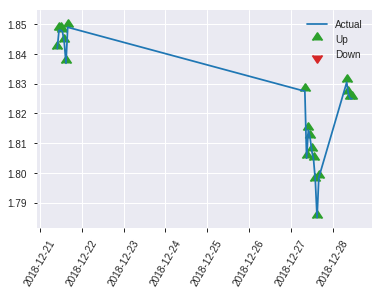


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2646718370859447
RMSE: 0.5144626683112631
LogLoss: 0.7242664849850219
Mean Per-Class Error: 0.4529177718832891
AUC: 0.527934350132626
pr_auc: 0.5127709234742288
Gini: 0.055868700265252036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33403781056404114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    114  0.9828   (114.0/116.0)
1      0    104  0        (0.0/104.0)
Total  2    218  0.5182   (114.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334038     0.645963  217
max f2                       0.334038     0.820189  217
max f0point5                 0.334038     0.532787  217
max accuracy                 0.70858      0.563636  17
max precision                0.817714     1         0
max recall                   0.334038     1         217
max specificity              0.817714     1         0
max absolute_mcc             0.70858      0.149176  17
max min_per_class_accuracy   0.582044     0.525862  109
max mean_per_class_accuracy  0.573368     0.547082  115

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 56.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.810461           1.41026   1.41026            0.666667         0.814693  0.666667                    0.814693            0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.774633           2.11538   1.69231            1                0.793563  0.8                         0.806241            0.0192308       0.0384615                  111.538   69.2308
    3        0.0318182                   0.755163           1.05769   1.51099            0.5              0.760613  0.714286                    0.793204            0.00961538      0.0480769                  5.76923   51.0989
    4        0.0409091                   0.738341           1.05769   1.41026            0.5              0.746046  0.666667                    0.782725            0.00961538      0.0576923                  5.76923   41.0256
    5        0.05                        0.72701            2.11538   1.53846            1                0.732429  0.727273                    0.77358             0.0192308       0.0769231                  111.538   53.8462
    6        0.1                         0.699427           0.961538  1.25               0.454545         0.713585  0.590909                    0.743583            0.0480769       0.125                      -3.84615  25
    7        0.15                        0.680986           0.961538  1.15385            0.454545         0.690138  0.545455                    0.725768            0.0480769       0.173077                   -3.84615  15.3846
    8        0.2                         0.663852           0.769231  1.05769            0.363636         0.673316  0.5                         0.712655            0.0384615       0.211538                   -23.0769  5.76923
    9        0.3                         0.634356           0.865385  0.99359            0.409091         0.649834  0.469697                    0.691715            0.0865385       0.298077                   -13.4615  -0.641026
    10       0.4                         0.605593           1.15385   1.03365            0.545455         0.622358  0.488636                    0.674376            0.115385        0.413462                   15.3846   3.36538
    11       0.5                         0.581796           1.15385   1.05769            0.545455         0.591546  0.5                         0.65781             0.115385        0.528846                   15.3846   5.76923
    12       0.6                         0.558667           1.05769   1.05769            0.5              0.568058  0.5                         0.642851            0.105769        0.634615                   5.76923   5.76923
    13       0.7                         0.508393           0.769231  1.01648            0.363636         0.531474  0.480519                    0.62694             0.0769231       0.711538                   -23.0769  1.64835
    14       0.8                         0.467727           1.05769   1.02163            0.5              0.488644  0.482955                    0.609653            0.105769        0.817308                   5.76923   2.16346
    15       0.9                         0.419306           0.673077  0.982906           0.318182         0.444406  0.464646                    0.591292            0.0673077       0.884615                   -32.6923  -1.7094
    16       1                           0.267186           1.15385   1                  0.545455         0.375347  0.472727                    0.569698            

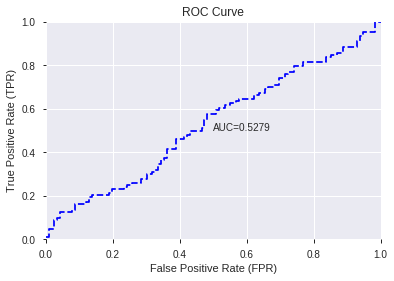

This function is available for GLM models only


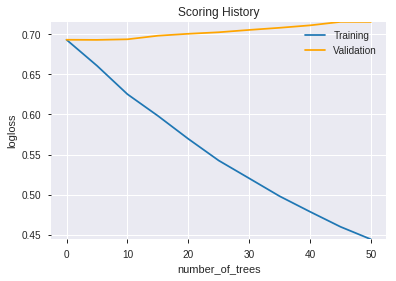

--2019-08-28 13:09:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_130817_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_130817_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'ADOSC',
 'hour',
 'STOCH_slowd',
 'OBV',
 'MACDEXT_hist',
 'MFI_24',
 'CCI_8',
 'ADXR_8',
 'ADX_8',
 'Volume',
 'AD',
 'MFI_20',
 'BETA_30',
 'STOCHRSI_fastk',
 'BETA_12',
 'DX_12',
 'CORREL_8',
 'ULTOSC',
 'ADX_12',
 'DX_24',
 'HT_DCPERIOD',
 'MFI_14',
 'STOCH_slowk',
 'MOM_20',
 'ADX_24',
 'ADXR_14',
 'STDDEV_12',
 'STOCHF_fastk',
 'MACDFIX_signal_24',
 'STDDEV_8',
 'CORREL_24',
 'BETA_20',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'CORREL_14',
 'ADX_14',
 'MINUS_DM_14',
 'PLUS_DM_20',
 'DX_8',
 'DX_14',
 'ROC_20',
 'CMO_8',
 'aroondown_24',
 'dayofyear',
 'CORREL_30',
 'MINUS_DI_30',
 'TRANGE',
 'PLUS_DM_14',
 'CORREL_12',
 'WILLR_20',
 'NATR_30',
 'DX_20',
 'STDDEV_30',
 'ADXR_12',
 'day',
 'LINEARREG_ANGLE_20',
 'HT_PHASOR_quadrature',
 'AROONOSC_30',
 'DX_30',
 'MINUS_DM_8',
 'MFI_30',
 'BETA_8',
 'PLUS_DM_24',
 'CCI_30',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_20',
 'aroondown_12',
 'BBANDS_upperband_8_6_5',
 'STDDEV_20',
 'CMO_20',
 'MOM_2

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

704

['MIDPRICE_12',
 'SAR_0.12',
 'SMA_12',
 'TEMA_12',
 'TRIMA_12',
 'WMA_12',
 'MA_12_0',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_12_1_3',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_12_1_4',
 'BBANDS_middleband_12_1_4',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_upperband_12_1_5',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_12_1_5',
 'MA_12_2',
 'MAVP_12_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_middleband_12_2_2',
 'BBANDS_lowerband_12_2_2',
 'BBANDS_upperband_12_2_3',
 'BBANDS_middleband_12_2_3',
 'BBANDS_lowerband_12_2_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_131025  0.568634  0.776894              0.484251  0.520599  0.271023
1  DeepLearning_grid_1_AutoML_20190828_131025_model_3  0.555869  0.777305              0.491379  0.535376  0.286627
2  DeepLearning_grid_1_AutoML_20190828_131025_model_6  0.548035  0.697335              0.476625  0.502088  0.252092
3  DeepLearning_grid_1_AutoML_20190828_131025_model_4  0.541529  1.029672              0.500000  0.585174  0.342428
4  DeepLearning_grid_1_AutoML_20190828_131025_model_2  0.534234  0.856991              0.466512  0.558336  0.311739
5  DeepLearning_grid_1_AutoML_20190828_131025_model_1  0.507294  2.821245              0.491877  0.688339  0.473811
6  DeepLearning_grid_1_AutoML_20190828_131025_model_8  0.500000  0.707918              0.500000  0.507283  0.257336
7  DeepLearning_grid_1_AutoML_20190828_131025_model_7  0.496436  0.855478              0.500000  0.557502  0.310809
8  DeepLearning_grid_1_AutoML_20190828_131025_model_5  0.488561  0.703716              0.500000  0.505099  0.255125
9  DeepLearning_grid_1_AutoML_20190828_131025_model_9  0.484085  0.700243              0.491379  0.503527  0.253539

variable  relative_importance  scaled_importance  percentage
0             CDLHOMINGPIGEON             1.000000           1.000000    0.002645
1              STOCHRSI_fastd             0.987028           0.987028    0.002610
2                          AD             0.944949           0.944949    0.002499
3                   CDLINNECK             0.893348           0.893348    0.002363
4                 AROONOSC_30             0.862323           0.862323    0.002281
..                        ...                  ...                ...         ...
697    LINEARREG_INTERCEPT_20             0.281388           0.281388    0.000744
698                    RSI_12             0.253539           0.253539    0.000671
699  BBANDS_middleband_30_7_2             0.248336           0.248336    0.000657
700   BBANDS_upperband_30_6_2             0.195807           0.195807    0.000518
701                   CDLDOJI             0.192442           0.192442    0.000509

[702 rows x 4 columns]

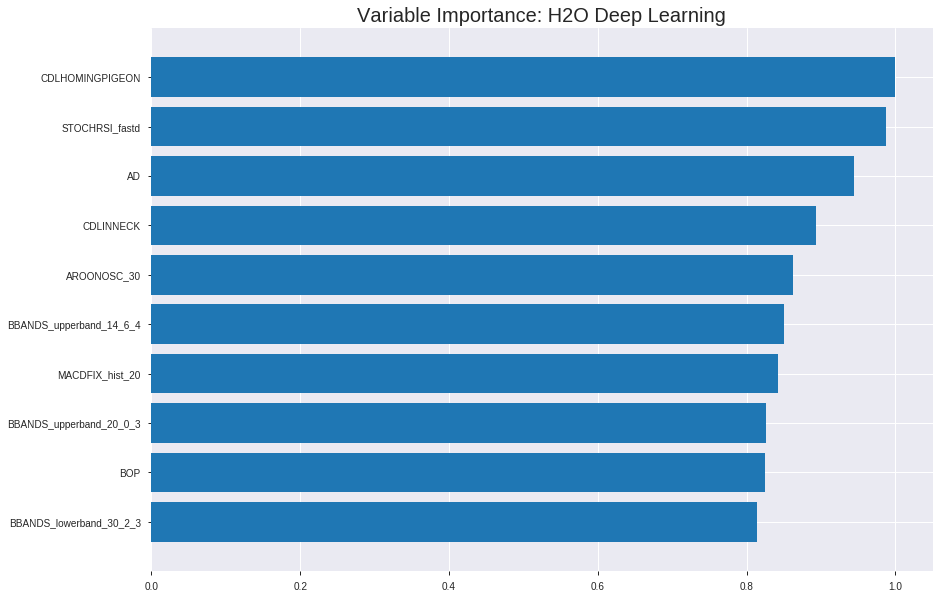

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_131025


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23792146899418415
RMSE: 0.4877719436316363
LogLoss: 0.6654836609932944
Mean Per-Class Error: 0.4243216981837208
AUC: 0.6060532449089142
pr_auc: 0.6350600606288077
Gini: 0.21210648981782843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41553531743426386: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      84   664   0.8877   (664.0/748.0)
1      27   760   0.0343   (27.0/787.0)
Total  111  1424  0.4502   (691.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415535     0.687472  319
max f2                       0.194277     0.842624  381
max f0point5                 0.491163     0.591549  272
max accuracy                 0.608414     0.569381  150
max precision                0.99989      1         0
max recall                   0.153812     1         390
max specificity              0.99989      1         0
max absolute_mcc             0.656894     0.199381  104
max min_per_class_accuracy   0.522457     0.555273  236
max mean_per_class_accuracy  0.608414     0.575678  150

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 54.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.918937           1.95044   1.95044            1                0.961852  1                           0.961852            0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.833745           1.82042   1.88753            0.933333         0.880322  0.967742                    0.922402            0.0177891       0.0381194                  82.0415   88.7527
    3        0.0306189                   0.800692           1.46283   1.74295            0.75             0.814273  0.893617                    0.885592            0.0152478       0.0533672                  46.2834   74.2951
    4        0.0403909                   0.769301           1.69039   1.73023            0.866667         0.779682  0.887097                    0.859968            0.0165184       0.0698856                  69.0385   73.0233
    5        0.0501629                   0.744745           1.3003    1.64648            0.666667         0.758084  0.844156                    0.840121            0.0127065       0.0825921                  30.0296   64.6479
    6        0.100326                    0.685469           1.34251   1.4945             0.688312         0.708553  0.766234                    0.774337            0.0673443       0.149936                   34.2514   49.4497
    7        0.150489                    0.648964           1.29185   1.42695            0.662338         0.665095  0.731602                    0.737923            0.064803        0.21474                    29.1853   42.6949
    8        0.2                         0.628366           0.975222  1.31512            0.5              0.637682  0.674267                    0.713107            0.0482846       0.263024                   -2.47776  31.5121
    9        0.300326                    0.591903           1.05121   1.22696            0.538961         0.609092  0.629067                    0.678361            0.105464        0.368488                   5.12137   22.6961
    10       0.4                         0.563504           0.815872  1.12452            0.418301         0.579286  0.576547                    0.653673            0.0813215       0.449809                   -18.4128  12.4524
    11       0.500326                    0.522177           1.05121   1.10982            0.538961         0.544341  0.56901                     0.631749            0.105464        0.555273                   5.12137   10.9823
    12       0.762866                    0.501352           0.987322  1.06766            0.506203         0.50328   0.547395                    0.587537            0.259212        0.814485                   -1.26781  6.76644
    13       0.8                         0.499918           0.889677  1.0594             0.45614          0.500721  0.54316                     0.583507            0.0330368       0.847522                   -11.0323  5.94028
    14       0.899674                    0.455363           0.9561    1.04796            0.490196         0.487028  0.537292                    0.572818            0.0952986       0.942821                   -4.38996  4.7958
    15       1                           0.028445           0.569935  1                  0.292208         0.334984  0.512704                    0.548957            0.0571792       1                          -43.0065  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25848054266881576
RMSE: 0.5084098176361426
LogLoss: 0.7143881312809585
Mean Per-Class Error: 0.49377593360995853
AUC: 0.4783368789097879
pr_auc: 0.5638489011755331
Gini: -0.043326242180424246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09470398531498138: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.094704     0.710914  94
max f2                       0.094704     0.8601    94
max f0point5                 0.094704     0.605832  94
max accuracy                 0.094704     0.552511  94
max precision                0.771479     1         0
max recall                   0.094704     1         94
max specificity              0.771479     1         0
max absolute_mcc             0.331737     0.102657  79
max min_per_class_accuracy   0.501352     0.182741  5
max mean_per_class_accuracy  0.534289     0.506224  2

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 48.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.509426           1.09046   1.09046            0.6              0.576934  0.6                         0.576934            0.0124481       0.0124481                  9.04564   9.04564
    2        0.794521                    0.501352           0.974946  0.976606           0.536443         0.501352  0.537356                    0.502438            0.763485        0.775934                   -2.50535  -2.33939
    3        0.799087                    0.501285           0.908714  0.976218           0.5              0.501315  0.537143                    0.502432            0.00414938      0.780083                   -9.12863  -2.37819
    4        0.899543                    0.499223           1.03263   0.982518           0.568182         0.500511  0.540609                    0.502217            0.103734        0.883817                   3.26292   -1.74821
    5        1                           0.0841129          1.15654   1                  0.636364         0.375555  0.550228                    0.489493            0.116183        1                          15.6545   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:10:25  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:10:25  0.381 sec   11455 obs/sec     1         1             1535       0.589445         1.05795             -0.390679      0.508909        0.51902            1.46283          0.482736                         0.582341           0.968754              -0.370313        0.467753          0.525985             1.09046            0.449772
    2019-08-28 13:10:27  1.572 sec   12260 obs/sec     10        10            15350      0.487772         0.665484            0.0476994      0.606053        0.63506            1.95044          0.450163                         0.50841            0.714388              -0.0444624       0.478337          0.563849             1.09046            0.447489

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLHOMINGPIGEON           1.0                    1.0                  0.0026447546281126036
STOCHRSI_fastd            0.9870277643203735     0.9870277643203735   0.002610446247761944
AD                        0.9449488520622253     0.9449488520622253   0.0024991578498212625
CDLINNECK                 0.8933475613594055     0.8933475613594055   0.0023626850974183956
AROONOSC_30               0.8623225092887878     0.8623225092887878   0.0022806314473671953
---                       ---                    ---                  ---
LINEARREG_INTERCEPT_20    0.2813880741596222     0.2813880741596222   0.0007442024114293533
RSI_12                    0.25353872776031494    0.25353872776031494  0.0006705477236498744
BBANDS_middleband_30_7_2  0.2483358532190323     0.2483358532190323   0.0006567873971273278
BBANDS_upperband_30_6_2   0.19580717384815216    0.19580717384815216  0.0005178619292525496
CDLDOJI                   0.19244210422039032    0.19244210422039032  0.0005089621457806053


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6433121019108281)

('auc', 0.568633952254642)

('logloss', 0.7768943705730915)

('mean_per_class_error', 0.43086870026525204)

('rmse', 0.5205985582989298)

('mse', 0.2710228589029242)

deeplearning prediction progress: |███████████████████████████████████████| 100%


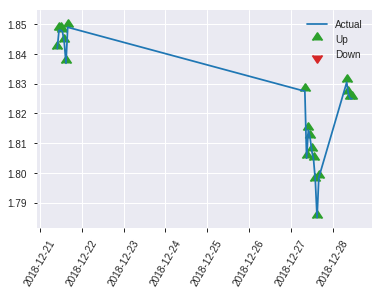


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2710228589029242
RMSE: 0.5205985582989298
LogLoss: 0.7768943705730915
Mean Per-Class Error: 0.43086870026525204
AUC: 0.568633952254642
pr_auc: 0.5463532811896818
Gini: 0.13726790450928394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4453496803053841: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    109  0.9397   (109.0/116.0)
1      3    101  0.0288   (3.0/104.0)
Total  10   210  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44535      0.643312  151
max f2                       0.0333676    0.81761   161
max f0point5                 0.500936     0.542453  127
max accuracy                 0.766444     0.581818  35
max precision                0.999386     1         0
max recall                   0.0333676    1         161
max specificity              0.999386     1         0
max absolute_mcc             0.766444     0.171825  35
max min_per_class_accuracy   0.544828     0.538462  107
max mean_per_class_accuracy  0.691832     0.569131  57

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 59.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0136364                   0.989433           1.41026   1.41026            0.666667         0.995282  0.666667                    0.995282            0.0192308       0.0192308                  41.0256    41.0256
    2        0.0227273                   0.981519           2.11538   1.69231            1                0.984107  0.8                         0.990812            0.0192308       0.0384615                  111.538    69.2308
    3        0.0318182                   0.971726           0         1.20879            0                0.975494  0.571429                    0.986435            0               0.0384615                  -100       20.8791
    4        0.0409091                   0.943133           2.11538   1.41026            1                0.968749  0.666667                    0.982505            0.0192308       0.0576923                  111.538    41.0256
    5        0.05                        0.909952           1.05769   1.34615            0.5              0.925262  0.636364                    0.972097            0.00961538      0.0673077                  5.76923    34.6154
    6        0.1                         0.80981            1.53846   1.44231            0.727273         0.86332   0.681818                    0.917709            0.0769231       0.144231                   53.8462    44.2308
    7        0.15                        0.772919           1.34615   1.41026            0.636364         0.791405  0.666667                    0.875608            0.0673077       0.211538                   34.6154    41.0256
    8        0.2                         0.727235           0.961538  1.29808            0.454545         0.750457  0.613636                    0.84432             0.0480769       0.259615                   -3.84615   29.8077
    9        0.3                         0.677523           0.865385  1.15385            0.409091         0.699231  0.545455                    0.795957            0.0865385       0.346154                   -13.4615   15.3846
    10       0.4                         0.590718           1.05769   1.12981            0.5              0.630023  0.534091                    0.754473            0.105769        0.451923                   5.76923    12.9808
    11       0.5                         0.542168           0.865385  1.07692            0.409091         0.564626  0.509091                    0.716504            0.0865385       0.538462                   -13.4615   7.69231
    12       0.827273                    0.501352           0.998932  1.04607            0.472222         0.505108  0.494505                    0.632875            0.326923        0.865385                   -0.106838  4.60693
    13       0.9                         0.497605           0.925481  1.03632            0.4375           0.499727  0.489899                    0.622115            0.0673077       0.932692                   -7.45192   3.63248
    14       1                           0.0333676          0.673077  1                  0.318182         0.351243  0.472727                    0.595028            0.0673077       1                          -32.6923   0

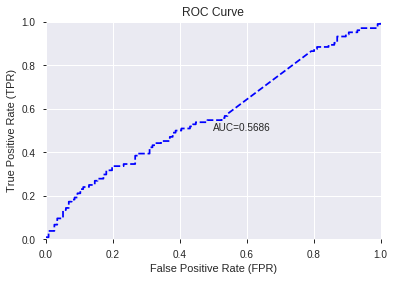

This function is available for GLM models only


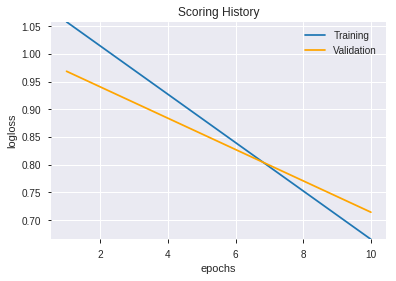

--2019-08-28 13:28:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_131025',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_131025',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_be75'

['CDLHOMINGPIGEON',
 'STOCHRSI_fastd',
 'AD',
 'CDLINNECK',
 'AROONOSC_30',
 'BBANDS_upperband_14_6_4',
 'MACDFIX_hist_20',
 'BBANDS_upperband_20_0_3',
 'BOP',
 'BBANDS_lowerband_30_2_3',
 'DX_24',
 'MAVP_14_5',
 'CDLMORNINGDOJISTAR',
 'BBANDS_middleband_12_0_4',
 'CDLINVERTEDHAMMER',
 'ATR_12',
 'MINUS_DI_20',
 'MOM_12',
 'ADXR_14',
 'DEMA_14',
 'MFI_30',
 'BBANDS_middleband_24_6_3',
 'BBANDS_upperband_24_3_4',
 'CDLIDENTICAL3CROWS',
 'BBANDS_middleband_20_7_2',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_20_7_4',
 'CDLLADDERBOTTOM',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_middleband_12_5_2',
 'MACDFIX_hist_12',
 'BBANDS_middleband_30_1_4',
 'LINEARREG_SLOPE_12',
 'ADXR_12',
 'BBANDS_middleband_24_7_5',
 'LINEARREG_ANGLE_20',
 'CDLTASUKIGAP',
 'BBANDS_lowerband_30_2_5',
 'CDLSHOOTINGSTAR',
 'MACDFIX_signal_14',
 'BBANDS_lowerband_20_1_3',
 'CDLDOJISTAR',
 'BBANDS_middleband_20_5_2',
 'BBANDS_upperband_14_4_5',
 'CCI_24',
 'aroo

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190828_132857_model_1  0.519479  0.693362               0.45126  0.50011  0.25011

variable  relative_importance  scaled_importance    percentage
0              STOCHRSI_fastk         6.909882e-03           1.000000  1.340762e-02
1                 CDLBELTHOLD         6.775822e-03           0.980599  1.314749e-02
2                         BOP         6.671830e-03           0.965549  1.294571e-02
3              CDLMATCHINGLOW         6.525790e-03           0.944414  1.266234e-02
4          CDLIDENTICAL3CROWS         6.429370e-03           0.930460  1.247525e-02
..                        ...                  ...                ...           ...
697  BBANDS_middleband_12_1_3         2.328508e-06           0.000337  4.518129e-06
698              LINEARREG_20         1.787565e-06           0.000259  3.468508e-06
699                   DEMA_14         3.526021e-07           0.000051  6.841730e-07
700  BBANDS_middleband_30_7_3         1.174166e-07           0.000017  2.278297e-07
701                       ADD         0.000000e+00           0.000000  0.000000e+00

[702 rows x 4 columns]

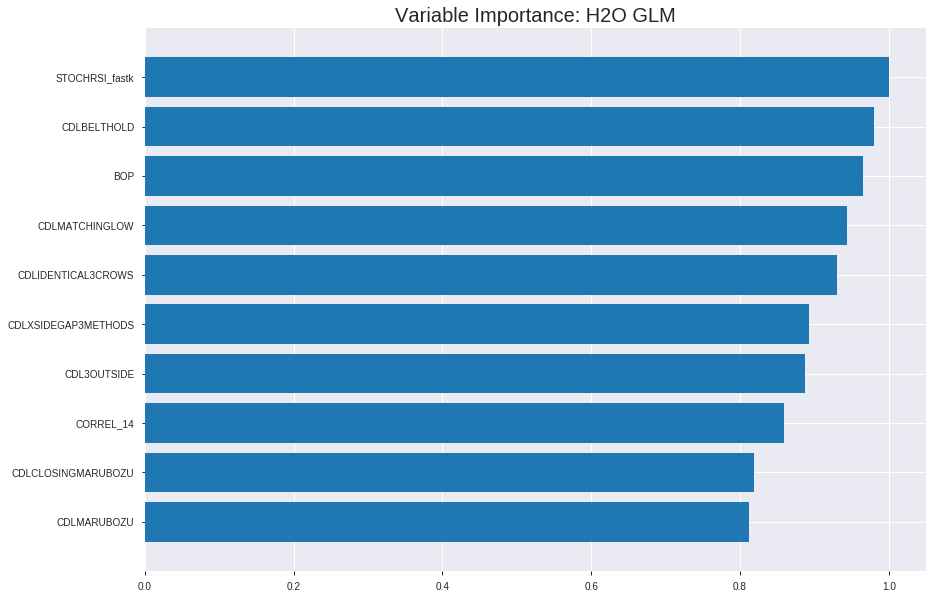

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_132857_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24766974068816502
RMSE: 0.4976642851241839
LogLoss: 0.6884750459926048
Null degrees of freedom: 1534
Residual degrees of freedom: 833
Null deviance: 2126.970858206576
Residual deviance: 2113.6183911972967
AIC: 3517.6183911972967
AUC: 0.5792430810836521
pr_auc: 0.5859921491662611
Gini: 0.15848616216730416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.481453709196861: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   721   0.9639   (721.0/748.0)
1      9    778   0.0114   (9.0/787.0)
Total  36   1499  0.4756   (730.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481454     0.680665  374
max f2                       0.469033     0.841351  393
max f0point5                 0.503489     0.585347  272
max accuracy                 0.503489     0.562866  272
max precision                0.589999     1         0
max recall                   0.469033     1         393
max specificity              0.589999     1         0
max absolute_mcc             0.503489     0.126202  272
max min_per_class_accuracy   0.511911     0.56016   212
max mean_per_class_accuracy  0.512125     0.561059  211

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.562901           1.58474   1.58474            0.8125           0.570859  0.8125                      0.570859            0.0165184       0.0165184                  58.4736   58.4736
    2        0.0201954                   0.553337           1.3003    1.4471             0.666667         0.556953  0.741935                    0.56413             0.0127065       0.0292249                  30.0296   44.7104
    3        0.0306189                   0.54903            1.21903   1.36946            0.625            0.551206  0.702128                    0.55973             0.0127065       0.0419314                  21.9028   36.9461
    4        0.0403909                   0.545412           1.3003    1.35273            0.666667         0.546888  0.693548                    0.556624            0.0127065       0.0546379                  30.0296   35.2728
    5        0.0501629                   0.542859           0.910208  1.26652            0.466667         0.54401   0.649351                    0.554166            0.00889454      0.0635324                  -8.97925  26.6523
    6        0.100326                    0.532839           1.1652    1.21586            0.597403         0.537127  0.623377                    0.545647            0.0584498       0.121982                   16.5201   21.5862
    7        0.150489                    0.528239           1.19053   1.20742            0.61039          0.530387  0.619048                    0.54056             0.0597205       0.181703                   19.0531   20.7418
    8        0.2                         0.525379           1.18053   1.20076            0.605263         0.526758  0.615635                    0.537143            0.0584498       0.240152                   18.0532   20.0762
    9        0.300326                    0.520941           1.10187   1.16773            0.564935         0.522825  0.598698                    0.53236             0.110546        0.350699                   10.1875   16.7728
    10       0.4                         0.516203           1.01984   1.13088            0.522876         0.518604  0.579805                    0.528932            0.101652        0.452351                   1.98404   13.0877
    11       0.500326                    0.511875           1.06388   1.11744            0.545455         0.514024  0.572917                    0.525943            0.106734        0.559085                   6.38789   11.7442
    12       0.6                         0.507934           0.917856  1.08429            0.470588         0.509996  0.555917                    0.523294            0.0914867       0.650572                   -8.21437  8.42863
    13       0.699674                    0.503497           1.05808   1.08055            0.542484         0.50576   0.554004                    0.520796            0.105464        0.756036                   5.80844   8.05536
    14       0.8                         0.498717           0.797909  1.04511            0.409091         0.50118   0.535831                    0.518336            0.0800508       0.836086                   -20.2091  4.5108
    15       0.899674                    0.492444           0.854116  1.02395            0.437908         0.495914  0.524982                    0.515852            0.0851334       0.92122                    -14.5884  2.39482
    16       1                           0.453018           0.785244  1                  0.402597         0.484471  0.512704                    0.512704          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24975677614568884
RMSE: 0.49975671695905083
LogLoss: 0.6926603739485839
Null degrees of freedom: 437
Residual degrees of freedom: -264
Null deviance: 605.243449119525
Residual deviance: 606.7704875789595
AIC: 2010.7704875789595
AUC: 0.4877414326937254
pr_auc: 0.5418770945932921
Gini: -0.02451713461254923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4695757298686982: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    196  0.9949   (196.0/197.0)
1      0    241  0        (0.0/241.0)
Total  1    437  0.4475   (196.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.469576     0.710914   398
max f2                       0.469576     0.8601     398
max f0point5                 0.469576     0.605832   398
max accuracy                 0.490846     0.552511   359
max precision                0.557348     1          0
max recall                   0.469576     1          398
max specificity              0.557348     1          0
max absolute_mcc             0.484857     0.0798815  382
max min_per_class_accuracy   0.507052     0.48731    199
max mean_per_class_accuracy  0.49402      0.516218   334

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 50.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.541508           1.09046   1.09046            0.6              0.547804  0.6                         0.547804            0.0124481       0.0124481                  9.04564    9.04564
    2        0.0205479                   0.538227           0.454357  0.807746           0.25             0.540307  0.444444                    0.544472            0.00414938      0.0165975                  -54.5643   -19.2254
    3        0.0319635                   0.535399           0.726971  0.778897           0.4              0.536522  0.428571                    0.541633            0.00829876      0.0248963                  -27.3029   -22.1103
    4        0.0410959                   0.534323           0.908714  0.807746           0.5              0.53519   0.444444                    0.540201            0.00829876      0.033195                   -9.12863   -19.2254
    5        0.0502283                   0.533163           0.908714  0.826103           0.5              0.533457  0.454545                    0.538975            0.00829876      0.0414938                  -9.12863   -17.3897
    6        0.100457                    0.525691           1.40438   1.11524            0.772727         0.529302  0.613636                    0.534138            0.0705394       0.112033                   40.4376    11.524
    7        0.150685                    0.522606           0.908714  1.0464             0.5              0.52445   0.575758                    0.530909            0.0456432       0.157676                   -9.12863   4.63976
    8        0.200913                    0.520188           0.908714  1.01198            0.5              0.521407  0.556818                    0.528533            0.0456432       0.20332                    -9.12863   1.19766
    9        0.30137                     0.515376           0.908714  0.977556           0.5              0.517835  0.537879                    0.524967            0.0912863       0.294606                   -9.12863   -2.24444
    10       0.399543                    0.511              0.887581  0.955448           0.488372         0.512781  0.525714                    0.521973            0.0871369       0.381743                   -11.2419   -4.45525
    11       0.5                         0.50703            1.07393   0.979253           0.590909         0.508968  0.538813                    0.51936             0.107884        0.489627                   7.39344    -2.07469
    12       0.600457                    0.503787           0.991324  0.981273           0.545455         0.505271  0.539924                    0.517003            0.0995851       0.589212                   -0.867597  -1.87274
    13       0.69863                     0.500035           0.887581  0.968107           0.488372         0.501958  0.53268                     0.514889            0.0871369       0.676349                   -11.2419   -3.18933
    14       0.799087                    0.4964             1.28046   1.00737            0.704545         0.49844   0.554286                    0.512821            0.128631        0.804979                   28.046     0.737404
    15       0.899543                    0.490857           1.03263   1.01019            0.568182         0.49366   0.555838                    0.510681            0.103734        0.908714                   3.26292    1.01944
    16       1                           0.468535           0.908714  1                  0.5              0.483935  0.550228           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:28:59  0.000 sec   2            3         702           1.37695           1.38532
    2019-08-28 13:29:00  0.961 sec   4            2.2       703           1.37479           1.38616
    2019-08-28 13:29:01  2.002 sec   6            1.6       703           1.37227           1.38734
    2019-08-28 13:29:02  2.971 sec   8            1.2       703           1.36937           1.389
    2019-08-28 13:29:03  4.021 sec   10           0.84      703           1.36614           1.39123

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6533333333333333)

('auc', 0.5194794429708223)

('logloss', 0.6933615682672972)

('mean_per_class_error', 0.44794429708222805)

('rmse', 0.5001103725535356)

('mse', 0.2501103847356362)

glm prediction progress: |████████████████████████████████████████████████| 100%


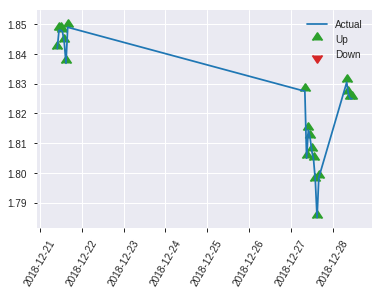


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501103847356362
RMSE: 0.5001103725535356
LogLoss: 0.6933615682672972
Null degrees of freedom: 219
Residual degrees of freedom: -482
Null deviance: 305.73672384847293
Residual deviance: 305.0790900376108
AIC: 1709.0790900376107
AUC: 0.5194794429708223
pr_auc: 0.511987027358342
Gini: 0.03895888594164454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5008891785208612: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   98   0.8448   (98.0/116.0)
1      6    98   0.0577   (6.0/104.0)
Total  24   196  0.4727   (104.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500889     0.653333  195
max f2                       0.482619     0.820189  217
max f0point5                 0.502636     0.552995  190
max accuracy                 0.54         0.563636  9
max precision                0.565004     1         0
max recall                   0.482619     1         217
max specificity              0.565004     1         0
max absolute_mcc             0.54         0.186755  9
max min_per_class_accuracy   0.516302     0.509615  107
max mean_per_class_accuracy  0.502636     0.552056  190

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 51.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.556868           1.41026   1.41026            0.666667         0.56179   0.666667                    0.56179             0.0192308       0.0192308                  41.0256   41.0256
    2        0.0227273                   0.550226           2.11538   1.69231            1                0.552857  0.8                         0.558217            0.0192308       0.0384615                  111.538   69.2308
    3        0.0318182                   0.545192           2.11538   1.81319            1                0.548141  0.857143                    0.555338            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.540647           2.11538   1.88034            1                0.543619  0.888889                    0.552734            0.0192308       0.0769231                  111.538   88.0342
    5        0.05                        0.538672           1.05769   1.73077            0.5              0.539914  0.818182                    0.550403            0.00961538      0.0865385                  5.76923   73.0769
    6        0.1                         0.531878           0.576923  1.15385            0.272727         0.535253  0.545455                    0.542828            0.0288462       0.115385                   -42.3077  15.3846
    7        0.15                        0.530398           0.769231  1.02564            0.363636         0.53105   0.484848                    0.538902            0.0384615       0.153846                   -23.0769  2.5641
    8        0.2                         0.526765           1.15385   1.05769            0.545455         0.528884  0.5                         0.536397            0.0576923       0.211538                   15.3846   5.76923
    9        0.3                         0.522362           1.05769   1.05769            0.5              0.524707  0.5                         0.5325              0.105769        0.317308                   5.76923   5.76923
    10       0.4                         0.51832            1.15385   1.08173            0.545455         0.520307  0.511364                    0.529452            0.115385        0.432692                   15.3846   8.17308
    11       0.5                         0.515985           0.769231  1.01923            0.363636         0.517282  0.481818                    0.527018            0.0769231       0.509615                   -23.0769  1.92308
    12       0.6                         0.512577           0.576923  0.945513           0.272727         0.514456  0.44697                     0.524924            0.0576923       0.567308                   -42.3077  -5.44872
    13       0.7                         0.509532           1.25      0.989011           0.590909         0.511197  0.467532                    0.522963            0.125           0.692308                   25        -1.0989
    14       0.8                         0.505267           1.25      1.02163            0.590909         0.507306  0.482955                    0.521006            0.125           0.817308                   25        2.16346
    15       0.9                         0.50034            1.25      1.04701            0.590909         0.503204  0.494949                    0.519028            0.125           0.942308                   25        4.70085
    16       1                           0.479197           0.576923  1                  0.272727         0.492104  0.472727                    0.516336         

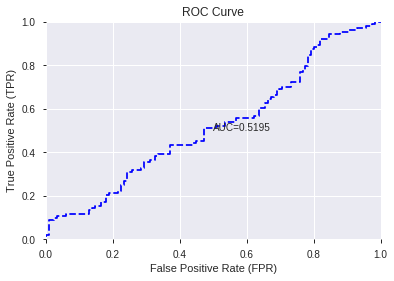

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


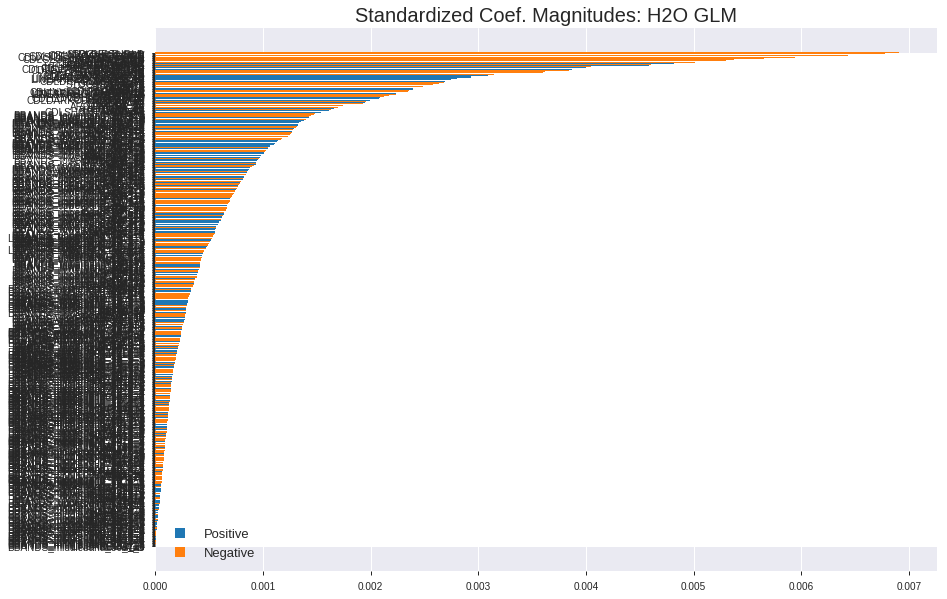

'log_likelihood'
--2019-08-28 13:29:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_132857_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_132857_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHRSI_fastk',
 'CDLBELTHOLD',
 'BOP',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLXSIDEGAP3METHODS',
 'CDL3OUTSIDE',
 'CORREL_14',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'OBV',
 'CDLHAMMER',
 'AD',
 'CDLHIKKAKEMOD',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'HT_PHASOR_inphase',
 'VAR_30',
 'MFI_20',
 'CDLLADDERBOTTOM',
 'CDLRISEFALL3METHODS',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'CDLINNECK',
 'STOCHF_fastk',
 'CCI_8',
 'CORREL_8',
 'CDLHOMINGPIGEON',
 'aroondown_14',
 'MFI_14',
 'CDLHARAMICROSS',
 'CDLADVANCEBLOCK',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'VAR_24',
 'CDLDOJISTAR',
 'STDDEV_30',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'MFI_8',
 'WILLR_8',
 'CCI_14',
 'MOM_8',
 'aroonup_12',
 'CCI_12',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CDLHIGHWAVE',
 'CORREL_12',
 'CDLINVERTEDHAMMER',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'CDLSTALLEDPATTERN',
 'STDDEV_8',
 'BETA_30',
 'ADX_8',
 'CDLTHRUST

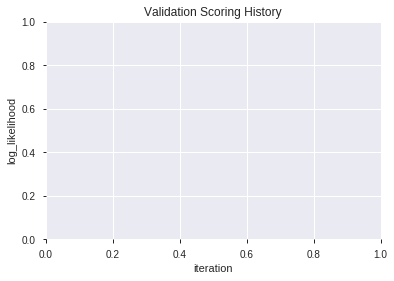

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_132931_model_5  0.555371  0.713594              0.488064  0.509214  0.259299
1               XGBoost_3_AutoML_20190828_132931  0.541777  0.705621              0.462699  0.505795  0.255829
2  XGBoost_grid_1_AutoML_20190828_132931_model_7  0.541777  0.728266              0.500000  0.516332  0.266599
3  XGBoost_grid_1_AutoML_20190828_132931_model_3  0.537881  0.706854              0.471817  0.506673  0.256718
4  XGBoost_grid_1_AutoML_20190828_132931_model_1  0.536638  0.708592              0.474635  0.507066  0.257116
5  XGBoost_grid_1_AutoML_20190828_132931_model_6  0.527271  0.706716              0.500000  0.506589  0.256633
6  XGBoost_grid_1_AutoML_20190828_132931_model_4  0.513014  0.705636              0.500000  0.506097  0.256134
7  XGBoost_grid_1_AutoML_20190828_132931_model_2  0.512351  0.713080              0.495690  0.509550  0.259641
8               XGBoost_2_AutoML_20190828_132931  0.506714  0.722115              0.495690  0.513644  0.263831
9               XGBoost_1_AutoML_20190828_132931  0.502735  0.719415              0.491877  0.512258  0.262409

variable  relative_importance  scaled_importance  percentage
0                         BOP           476.940704           1.000000    0.022373
1                    SAR_0.12           314.665222           0.659758    0.014761
2                        DX_8           289.888397           0.607808    0.013599
3        HT_PHASOR_quadrature           277.414734           0.581655    0.013014
4           HT_PHASOR_inphase           255.001526           0.534661    0.011962
..                        ...                  ...                ...         ...
510   BBANDS_upperband_30_2_3             1.178902           0.002472    0.000055
511   BBANDS_upperband_12_2_2             1.119231           0.002347    0.000053
512  BBANDS_middleband_14_6_4             0.919367           0.001928    0.000043
513                   MA_14_4             0.848316           0.001779    0.000040
514  BBANDS_middleband_12_5_3             0.086544           0.000181    0.000004

[515 rows x 4 columns]

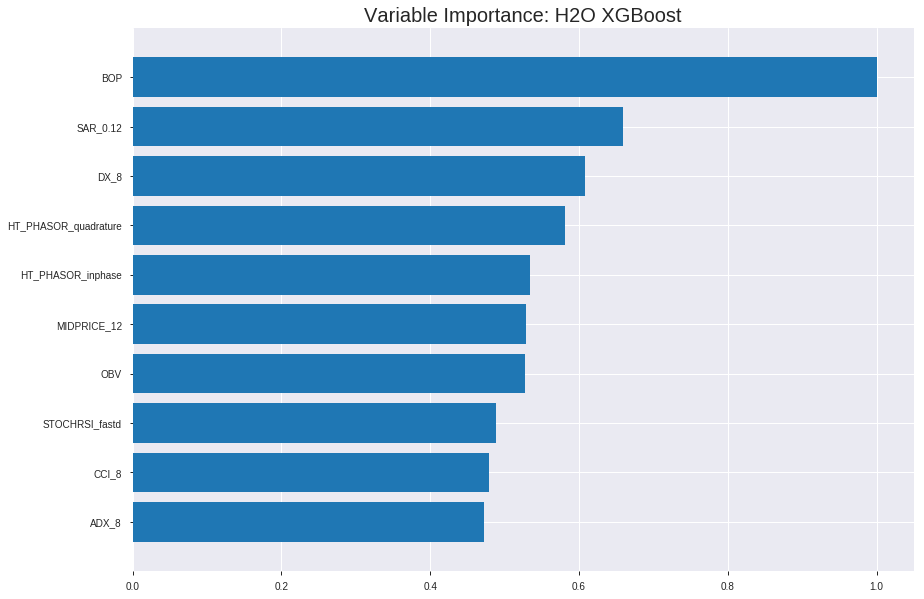

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_132931_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.039554238770411046
RMSE: 0.1988824747694252
LogLoss: 0.2127296199860669
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987293519695044
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5592309832572937: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      748  0    0        (0.0/748.0)
1      0    787  0        (0.0/787.0)
Total  748  787  0        (0.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.559231     1        200
max f2                       0.559231     1        200
max f0point5                 0.559231     1        200
max accuracy                 0.559231     1        200
max precision                0.927576     1        0
max recall                   0.559231     1        200
max specificity              0.927576     1        0
max absolute_mcc             0.559231     1        200
max min_per_class_accuracy   0.559231     1        200
max mean_per_class_accuracy  0.559231     1        200

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.906219           1.95044   1.95044            1                0.91369   1                           0.91369             0.0203304       0.0203304                  95.0445   95.0445
    2        0.0201954                   0.898856           1.95044   1.95044            1                0.90219   1                           0.908126            0.0190597       0.0393901                  95.0445   95.0445
    3        0.0306189                   0.893711           1.95044   1.95044            1                0.896206  1                           0.904068            0.0203304       0.0597205                  95.0445   95.0445
    4        0.0403909                   0.88991            1.95044   1.95044            1                0.891317  1                           0.900983            0.0190597       0.0787802                  95.0445   95.0445
    5        0.0501629                   0.88588            1.95044   1.95044            1                0.887082  1                           0.898275            0.0190597       0.0978399                  95.0445   95.0445
    6        0.100326                    0.869203           1.95044   1.95044            1                0.877097  1                           0.887686            0.0978399       0.19568                    95.0445   95.0445
    7        0.150489                    0.852873           1.95044   1.95044            1                0.861259  1                           0.878877            0.0978399       0.29352                    95.0445   95.0445
    8        0.2                         0.840523           1.95044   1.95044            1                0.846454  1                           0.87085             0.0965693       0.390089                   95.0445   95.0445
    9        0.300326                    0.806793           1.95044   1.95044            1                0.823412  1                           0.855003            0.19568         0.585769                   95.0445   95.0445
    10       0.4                         0.768032           1.95044   1.95044            1                0.78927   1                           0.838624            0.194409        0.780178                   95.0445   95.0445
    11       0.500326                    0.663976           1.95044   1.95044            1                0.73683   1                           0.818212            0.19568         0.975858                   95.0445   95.0445
    12       0.6                         0.247821           0.242212  1.66667            0.124183         0.333147  0.854506                    0.737631            0.0241423       1                          -75.7788  66.6667
    13       0.699674                    0.203584           0         1.42924            0                0.222215  0.732775                    0.664206            0               1                          -100      42.9236
    14       0.8                         0.173459           0         1.25               0                0.188191  0.640879                    0.60451             0               1                          -100      25
    15       0.899674                    0.139177           0         1.11151            0                0.156854  0.569877                    0.554915            0               1                          -100      11.1513
    16       1                           0.0773787          0         1                  0                0.115933  0.512704                    0.510874            0 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26292822581150715
RMSE: 0.5127652736013888
LogLoss: 0.7230836409837631
Mean Per-Class Error: 0.4755987109547781
AUC: 0.5069823282852749
pr_auc: 0.5525058326831773
Gini: 0.013964656570549794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1923418492078781: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    197  1        (197.0/197.0)
1      0    241  0        (0.0/241.0)
Total  0    438  0.4498   (197.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.192342     0.709867   399
max f2                       0.192342     0.859486   399
max f0point5                 0.394796     0.608071   353
max accuracy                 0.394796     0.559361   353
max precision                0.756936     0.652174   22
max recall                   0.192342     1          399
max specificity              0.854765     0.994924   0
max absolute_mcc             0.295675     0.0864519  388
max min_per_class_accuracy   0.545899     0.497925   195
max mean_per_class_accuracy  0.509704     0.524401   238

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 54.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.804884           0.726971  0.726971           0.4              0.82881   0.4                         0.82881             0.00829876      0.00829876                 -27.3029  -27.3029
    2        0.0205479                   0.784441           1.36307   1.00968            0.75             0.790491  0.555556                    0.811779            0.0124481       0.0207469                  36.3071   0.968188
    3        0.0319635                   0.776486           1.09046   1.03853            0.6              0.779827  0.571429                    0.800368            0.0124481       0.033195                   9.04564   3.85299
    4        0.0410959                   0.768945           1.36307   1.11065            0.75             0.772518  0.611111                    0.794179            0.0124481       0.0456432                  36.3071   11.065
    5        0.0502283                   0.757443           1.36307   1.15654            0.75             0.763283  0.636364                    0.788561            0.0124481       0.0580913                  36.3071   15.6545
    6        0.100457                    0.718784           0.826103  0.991324           0.454545         0.73594   0.545455                    0.762251            0.0414938       0.0995851                  -17.3897  -0.867597
    7        0.150685                    0.686652           1.15654   1.0464             0.636364         0.703144  0.575758                    0.742548            0.0580913       0.157676                   15.6545   4.63976
    8        0.200913                    0.6633             0.826103  0.991324           0.454545         0.675358  0.545455                    0.725751            0.0414938       0.19917                    -17.3897  -0.867597
    9        0.30137                     0.623712           1.03263   1.00509            0.568182         0.639327  0.55303                     0.696943            0.103734        0.302905                   3.26292   0.509242
    10       0.399543                    0.573053           1.01438   1.00737            0.55814          0.600409  0.554286                    0.673223            0.0995851       0.40249                    1.43781   0.737404
    11       0.5                         0.543494           0.950019  0.995851           0.522727         0.558842  0.547945                    0.650242            0.0954357       0.497925                   -4.99811  -0.414938
    12       0.600457                    0.509591           1.23916   1.03656            0.681818         0.526311  0.570342                    0.629509            0.124481        0.622407                   23.9155   3.65555
    13       0.69863                     0.474049           0.718518  0.991864           0.395349         0.490926  0.545752                    0.610034            0.0705394       0.692946                   -28.1482  -0.813603
    14       0.799087                    0.438647           1.11524   1.00737            0.613636         0.455804  0.554286                    0.590646            0.112033        0.804979                   11.524    0.737404
    15       0.899543                    0.39266            1.07393   1.01481            0.590909         0.418331  0.558376                    0.571402            0.107884        0.912863                   7.39344   1.48072
    16       1                           0.192342           0.867409  1                  0.477273         0.327361  0.550228                    0.546


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:29:55  11.626 sec  0                  0.5              0.693147            0.5             0                  1                0.487296                         0.5                0.693147              0.5               0                    1                  0.449772
    2019-08-28 13:29:56  12.713 sec  5                  0.450581         0.598468            0.965301        0.965896           1.95044          0.100326                         0.500546           0.69425               0.497894          0.550841             0.726971           0.442922
    2019-08-28 13:29:57  13.231 sec  10                 0.407151         0.52122             0.990818        0.990594           1.95044          0.0462541                        0.49907            0.691377              0.527003          0.557534             0.726971           0.438356
    2019-08-28 13:29:57  13.812 sec  15                 0.36768          0.45523             0.997917        0.995497           1.95044          0.0214984                        0.501566           0.696593              0.51803           0.558578             1.09046            0.440639
    2019-08-28 13:29:58  14.386 sec  20                 0.333355         0.400911            0.999477        0.998239           1.95044          0.00912052                       0.502528           0.698913              0.524127          0.556157             0.726971           0.449772
    2019-08-28 13:29:58  14.963 sec  25                 0.302717         0.354642            0.999865        0.998602           1.95044          0.00456026                       0.504783           0.703711              0.515039          0.551194             0.726971           0.447489
    2019-08-28 13:29:59  15.537 sec  30                 0.28035          0.322221            0.999971        0.997431           1.95044          0.00260586                       0.507618           0.709739              0.505571          0.551354             0.726971           0.447489
    2019-08-28 13:29:59  16.088 sec  35                 0.257476         0.289989            0.999989        0.998719           1.95044          0.000651466                      0.5078             0.710503              0.509952          0.550455             0.363485           0.449772
    2019-08-28 13:30:00  16.698 sec  40                 0.236009         0.260657            0.999997        0.998726           1.95044          0.000651466                      0.509898           0.715326              0.503044          0.551324             0.726971           0.449772
    2019-08-28 13:30:01  17.315 sec  45                 0.216675         0.235294            1               0.998729           1.95044          0                                0.511587           0.71968               0.502717          0.550514             0.726971           0.449772
    2019-08-28 13:30:01  17.940 sec  50                 0.198882         0.21273             1               0.998729           1.95044          0                                0.512765           0.723084              0.506982          0.552506             0.726971           0.449772

Variable Importances: 


variable                  relative_importance    scaled_importance       percentage
------------------------  ---------------------  ----------------------  ----------------------
BOP                       476.9407043457031      1.0                     0.022373267815604416
SAR_0.12                  314.66522216796875     0.6597575323323389      0.01476093196423371
DX_8                      289.8883972167969      0.6078080452673541      0.013598652177245527
HT_PHASOR_quadrature      277.41473388671875     0.5816545565497361      0.01301351316985387
HT_PHASOR_inphase         255.00152587890625     0.53466085732551        0.0119621105514643
---                       ---                    ---                     ---
BBANDS_upperband_30_2_3   1.17890202999115       0.0024717999936877707   5.53022432453858e-05
BBANDS_upperband_12_2_2   1.1192306280136108     0.002346687162189356    5.250306035910319e-05
BBANDS_middleband_14_6_4  0.9193666577339172     0.0019276330356310467   4.3127450156379934e-05
MA_14_4                   0.8483160734176636     0.0017786615100957596   3.979447031867981e-05
BBANDS_middleband_12_5_3  0.0865435004234314     0.00018145547158143516  4.059751862298245e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6435331230283912)

('auc', 0.5553713527851458)

('logloss', 0.713594037802391)

('mean_per_class_error', 0.442970822281167)

('rmse', 0.5092136349916327)

('mse', 0.2592985260613918)

xgboost prediction progress: |████████████████████████████████████████████| 100%


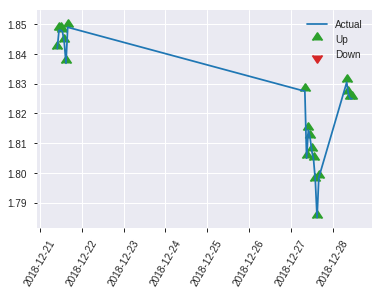


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2592985260613918
RMSE: 0.5092136349916327
LogLoss: 0.713594037802391
Mean Per-Class Error: 0.442970822281167
AUC: 0.5553713527851458
pr_auc: 0.5381056688961026
Gini: 0.11074270557029164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34986716508865356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    111  0.9569   (111.0/116.0)
1      2    102  0.0192   (2.0/104.0)
Total  7    213  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349867     0.643533  212
max f2                       0.264819     0.81761   219
max f0point5                 0.494551     0.548611  153
max accuracy                 0.777368     0.563636  9
max precision                0.866206     1         0
max recall                   0.264819     1         219
max specificity              0.866206     1         0
max absolute_mcc             0.777368     0.186755  9
max min_per_class_accuracy   0.57232      0.538462  107
max mean_per_class_accuracy  0.580914     0.557029  100

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 56.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.860462           2.11538   2.11538            1                0.864365  1                           0.864365            0.0288462       0.0288462                  111.538   111.538
    2        0.0227273                   0.825812           1.05769   1.69231            0.5              0.850099  0.8                         0.858659            0.00961538      0.0384615                  5.76923   69.2308
    3        0.0318182                   0.783077           2.11538   1.81319            1                0.792714  0.857143                    0.839817            0.0192308       0.0576923                  111.538   81.3187
    4        0.0409091                   0.777717           2.11538   1.88034            1                0.77918   0.888889                    0.826342            0.0192308       0.0769231                  111.538   88.0342
    5        0.05                        0.770145           1.05769   1.73077            0.5              0.774803  0.818182                    0.816972            0.00961538      0.0865385                  5.76923   73.0769
    6        0.1                         0.708162           0.769231  1.25               0.363636         0.743707  0.590909                    0.780339            0.0384615       0.125                      -23.0769  25
    7        0.15                        0.681101           0.384615  0.961538           0.181818         0.694652  0.454545                    0.751777            0.0192308       0.144231                   -61.5385  -3.84615
    8        0.2                         0.656352           1.34615   1.05769            0.636364         0.66954   0.5                         0.731218            0.0673077       0.211538                   34.6154   5.76923
    9        0.3                         0.627568           1.15385   1.08974            0.545455         0.639202  0.515152                    0.700546            0.115385        0.326923                   15.3846   8.97436
    10       0.4                         0.601212           1.15385   1.10577            0.545455         0.616596  0.522727                    0.679558            0.115385        0.442308                   15.3846   10.5769
    11       0.5                         0.56852            0.961538  1.07692            0.454545         0.58305   0.509091                    0.660257            0.0961538       0.538462                   -3.84615  7.69231
    12       0.6                         0.51997            1.05769   1.07372            0.5              0.542506  0.507576                    0.640632            0.105769        0.644231                   5.76923   7.37179
    13       0.7                         0.494331           1.15385   1.08516            0.545455         0.509388  0.512987                    0.621882            0.115385        0.759615                   15.3846   8.51648
    14       0.8                         0.465802           0.769231  1.04567            0.363636         0.480193  0.494318                    0.604171            0.0769231       0.836538                   -23.0769  4.56731
    15       0.9                         0.417916           0.673077  1.00427            0.318182         0.440745  0.474747                    0.586013            0.0673077       0.903846                   -32.6923  0.42735
    16       1                           0.264819           0.961538  1                  0.454545         0.365377  0.472727                    0.563949            0

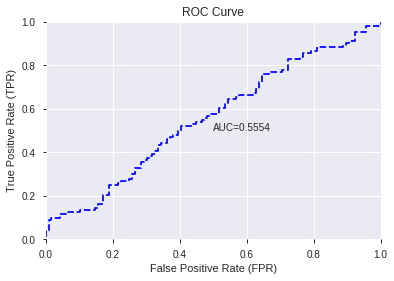

This function is available for GLM models only


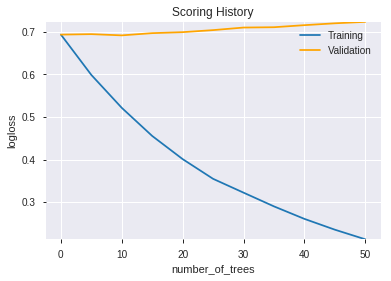

--2019-08-28 13:30:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_132931_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_132931_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_be75',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'SAR_0.12',
 'DX_8',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'MIDPRICE_12',
 'OBV',
 'STOCHRSI_fastd',
 'CCI_8',
 'ADX_8',
 'ADXR_8',
 'BETA_12',
 'STOCH_slowk',
 'CORREL_14',
 'AD',
 'CORREL_8',
 'WILLR_8',
 'MFI_8',
 'TRANGE',
 'MFI_14',
 'BETA_30',
 'BETA_14',
 'DIV',
 'ULTOSC',
 'ADOSC',
 'MOM_12',
 'DX_12',
 'CORREL_24',
 'CMO_8',
 'STOCH_slowd',
 'MACDEXT_hist',
 'MOM_8',
 'MFI_30',
 'ADXR_14',
 'MOM_20',
 'BETA_8',
 'STOCHF_fastk',
 'CORREL_12',
 'MFI_20',
 'STOCHRSI_fastk',
 'ADX_12',
 'BETA_20',
 'MFI_24',
 'WILLR_12',
 'STDDEV_8',
 'STDDEV_30',
 'DX_30',
 'RSI_8',
 'PLUS_DM_8',
 'MINUS_DI_8',
 'MACDFIX_hist_12',
 'PLUS_DI_8',
 'TEMA_12',
 'MACDFIX_hist_8',
 'ADXR_12',
 'PLUS_DI_12',
 'ADX_14',
 'CCI_12',
 'CORREL_20',
 'SMA_12',
 'WILLR_24',
 'STDDEV_12',
 'AROONOSC_8',
 'NATR_8',
 'ROC_12',
 'MINUS_DI_30',
 'BETA_24',
 'DX_14',
 'DX_24',
 'MINUS_DM_8',
 'MACDFIX_8',
 'MOM_14',
 'aroondown_8',
 'aroonup_8',
 'BBANDS_upperband_12_0_3',
 'LINEARREG_ANGLE_8',
 '

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.614
GLM             0.564
XGBoost         0.573
dtype: float64

DeepLearning    GLM  XGBoost
All          0.614  0.564    0.564
DLF          0.582  0.545    0.573
Fwe          0.591  0.564    0.564
RFE          0.582  0.564    0.564
XGBF         0.586  0.545    0.573





F1


DeepLearning    0.654
GLM             0.653
XGBoost         0.646
dtype: float64

DeepLearning    GLM  XGBoost
All          0.650  0.646    0.646
DLF          0.644  0.652    0.644
Fwe          0.654  0.646    0.646
RFE          0.643  0.653    0.644
XGBF         0.646  0.652    0.644





auc


DeepLearning    0.574
GLM             0.519
XGBoost         0.562
dtype: float64

DeepLearning    GLM  XGBoost
All          0.559  0.508    0.528
DLF          0.512  0.496    0.562
Fwe          0.574  0.508    0.528
RFE          0.569  0.519    0.555
XGBF         0.554  0.496    0.562





logloss


DeepLearning    0.901
GLM             0.696
XGBoost         0.724
dtype: float64

DeepLearning    GLM  XGBoost
All          0.772  0.695    0.724
DLF          0.781  0.696    0.693
Fwe          0.901  0.695    0.724
RFE          0.777  0.693    0.714
XGBF         0.775  0.696    0.693





mean_per_class_error


DeepLearning    0.438
GLM             0.476
XGBoost         0.453
dtype: float64

DeepLearning    GLM  XGBoost
All          0.406  0.459    0.453
DLF          0.438  0.476    0.439
Fwe          0.419  0.459    0.453
RFE          0.431  0.448    0.443
XGBF         0.431  0.476    0.439





rmse


DeepLearning    0.538
GLM             0.501
XGBoost         0.514
dtype: float64

DeepLearning    GLM  XGBoost
All          0.534  0.501    0.514
DLF          0.538  0.501    0.500
Fwe          0.535  0.501    0.514
RFE          0.521  0.500    0.509
XGBF         0.530  0.501    0.500





mse


DeepLearning    0.290
GLM             0.251
XGBoost         0.265
dtype: float64

DeepLearning    GLM  XGBoost
All          0.285  0.251    0.265
DLF          0.290  0.251    0.250
Fwe          0.286  0.251    0.265
RFE          0.271  0.250    0.259
XGBF         0.281  0.251    0.250

{'F1':       DeepLearning    GLM  XGBoost
 All          0.650    NaN      NaN
 DLF          0.644    NaN      NaN
 DLF            NaN  0.652      NaN
 DLF            NaN    NaN    0.644
 All            NaN  0.646      NaN
 All            NaN    NaN    0.646
 XGBF         0.646    NaN      NaN
 XGBF           NaN  0.652      NaN
 XGBF           NaN    NaN    0.644
 Fwe          0.654    NaN      NaN
 Fwe            NaN  0.646      NaN
 Fwe            NaN    NaN    0.646
 RFE          0.643    NaN      NaN
 RFE            NaN  0.653      NaN
 RFE            NaN    NaN    0.644,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.614    NaN      NaN
 DLF          0.582    NaN      NaN
 DLF            NaN  0.545      NaN
 DLF            NaN    NaN    0.573
 All            NaN  0.564      NaN
 All            NaN    NaN    0.564
 XGBF         0.586    NaN      NaN
 XGBF           NaN  0.545      NaN
 XGBF           NaN    NaN    0.573
 Fwe          0.591    NaN      NaN
 Fwe     